# DDPM (Denoising Diffusion Probabilistic Models)

- 구조

    - forward diffusion : 원본 image + gaussion noise (t 시점마다) 점진적으로 추가 (Markov Chain 마르코프 연쇄) -> 완전한 noise 생성

   - reverse diffusion : 완전한 noise -> 학습된 모델이 예측하여 (Noise Prediction) t 시점마다 noise 제거 -> 원본 image 복원


In [1]:
import torch

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.nn import Module, Conv2d, ReLU, MaxPool2d, BatchNorm2d, ConvTranspose2d, Linear, Sequential, MSELoss
from torch.optim import Adam
from torchvision.utils import make_grid

import os
from time import time
from math import floor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

elif torch.xpu.is_available():
    device = torch.device("xpu")

elif torch.backends.mps.is_available():
    device = torch.device("mps")

else: 
    device = torch.device("cpu")

device

device(type='cuda')

In [3]:
# cifar10 크기처럼 32로 크기 확장
transform = Compose([
    Resize(32),
    ToTensor(),
    Normalize([0.5], [0.5]) 
])

batch_size=128
trainset = DataLoader(MNIST(root="data_mnist", train=True, download=True, transform=transform),
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=os.cpu_count()//2,
                      pin_memory=True,
                      persistent_workers=True
)

In [4]:
timestep = 1000
img_size = 32
# mnist 는 단색
channels = 1

# forward
# t(timestep) 가 커질수록 noise를 더 많이 추가하여, 확산 과정을 안정적으로
# beta : image에 추가되는 noise의 분산 스케쥴 값
betas = torch.linspace(0.0001, 0.02, timestep, device=device)
# alpha : 원본 image 비율 (이전 시점의 정보가 얼마나 보존되는지)
alphas = 1.0 - betas

# reverse
# 누적곱 계산 (gaussion 분포의 평균 계산) -> t 시점에서 원본 image 예측
alphas_bar = torch.cumprod(alphas, dim=0)
# 이전 t의 누적곱 계산
alphas_bar_prev = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]])

In [5]:
# schedule_params : betas, alphas, alphas_bar, alphas_bar_prev
def extract(schedule_params, t, x_shape):
    # t에 해당하는 값을 schedule_params에서 추출하고 x_shape에 맞게 reshape
    batch_size = t.shape[0]
    
    # schedule_params의 마지막 차원(-1)에서 t 인덱스에 해당하는 값을 추출
    out = schedule_params.gather(-1, t).to(t.device)
    
    # out.reshape(batch_size, 1, 1, 1, ...) 형태로 변환하여 x_shape와 브로드캐스트 가능하게
    # len(x_shape) - 1은 (채널, 높이, 너비)에 해당하는 차원의 수만큼 1을 추가함
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

In [6]:
# forward
# t 시점의 노이즈가 섞인 이미지 x_t 계산
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_bar_t = extract(torch.sqrt(alphas_bar), t, x_start.shape)
    sqrt_one_minus_alphas_bar_t = extract(torch.sqrt(1.0 - alphas_bar), t, x_start.shape)

    return sqrt_alphas_bar_t * x_start + sqrt_one_minus_alphas_bar_t * noise

In [7]:
# reverse
# t 시점에서 t-1 시점으로의 역확산 단계 (Single Reverse Step)
def p_sample(model, x, t, t_index):
    # predict noise
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_bar_t = extract(torch.sqrt(1.0 - alphas_bar), t, x.shape)
    sqrt_recip_alphas_t = extract(torch.sqrt(1.0 / alphas), t, x.shape)
    
    # predict image
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_bar_t
    )
    
    if t_index == 0:
        return model_mean
    
    # t-1 시점의 분산
    posterior_variance_t = extract(betas * (1.0 - alphas_bar_prev) / (1.0 - alphas_bar), t, x.shape)
    
    # 정규분포로 noise 추가
    noise = torch.randn_like(x)
    
    return model_mean + torch.sqrt(posterior_variance_t) * noise

In [8]:
# image 복원
@torch.no_grad()
def p_sample_loop(model, shape):
    # t 에서 0까지 역확산 과정 (Full Reverse Process)
    batch_size = shape[0]
    # x : 완전한 noise
    x = torch.randn(shape, device=device)
    
    # t, t-1, ..., 1 -> reverse
    for i in range(timestep - 1, -1, -1):
        t = torch.tensor([i] * batch_size, device=device).long()
        # noise 제거 (완벽한 noise 에서 timestep이 줄어들며 조금씩 noise 제거)
        x = p_sample(model, x, t, i)
        
    # 복원된 image
    # -1 ~ 1 사이의 값으로 제한 -> 0 ~ 1 값으로 변환 (정규화)
    x = (x.clamp(-1, 1) + 1) / 2
    return x

In [9]:
# t 시점의 noise 를 featuremap에 주입 -> NoisePredictor가 예측을 잘 할 수 있도록
class Block(Module):
    def __init__(self, in_channel, out_channel, time_embedding_dim):
        super().__init__()

        # time ebedding dim을 out channel과 일치
        self.time_mlp = Linear(time_embedding_dim, out_channel)
        # image 특징 추출
        self.conv = Conv2d(in_channel, out_channel, 3, padding=1)
        self.normal = BatchNorm2d(out_channel)
        self.relu = ReLU()
        
    def forward(self, x, t_emb):
        h = self.normal(self.conv(x))
        h = self.relu(h)
        # time embedding + channel
        time_embedding = self.time_mlp(self.relu(t_emb))
        # (batch size, channel) -> (batch size, channel, 1, 1)로 확장
        # (..., ) : 그대로 유지해라
        # conditioning (time conditioning) : featuremap + t 
        h = h + time_embedding[(..., ) + (None, ) * 2]
        return h

In [10]:
# block 상속 + downsampling (encoder)
class DownBlock(Block):
    def __init__(self, in_channel, out_channel, time_embedding_dim):
        super().__init__(in_channel, out_channel, time_embedding_dim)
        self.downsample = MaxPool2d(2)

    def forward(self, x, t_embedding):
        h = super().forward(x, t_embedding)
        # 크기가 절반으로 줄어든 featuremap, skip connection map
        # skip connection map : U net (encoder - decoder) 구조에서, 다음 layer로 전달되지 않고 바로 자기와 같은 step의 layer로 정보 전달 
        # -> 정보의 손실을 막기 위함
        return self.downsample(h), h


In [11]:
# upsampling (decoder)
class UpBlock(Module):
    def __init__(self, in_channel, out_channel, skip_channel, time_embedding_dim):
        super().__init__()
        self.time_mlp = Linear(time_embedding_dim, out_channel)
        self.upsample = ConvTranspose2d(in_channel, out_channel, 4, 2, 1)
        # upsampling 된 featuremap (out_channel) + skip connection map channel
        # 두개의 feature map이 합쳐져서 처리됨
        self.conv = Conv2d(out_channel + skip_channel, out_channel, 3, padding=1)
        self.normal = BatchNorm2d(out_channel)
        self.relu = ReLU()

    def forward(self, x, skip_x, t_embedding):
        x = self.upsample(x)
         # skip connection으로 연결된 정보 추가
        x = torch.cat([x, skip_x], dim=1)
        h = self.normal(self.conv(x))
        h = self.relu(h)
        time_embedding = self.time_mlp(self.relu(t_embedding))
        # conditioning
        h = h + time_embedding[(..., ) + (None, ) * 2] 
        return h


In [12]:
class NoisePredictor(Module):
    def __init__(self, in_channel=channels, out_channel=channels, time_embedding_dim=256):
        super().__init__()
        
        # time embedding
        self.time_mlp = Sequential(
            Linear(1, time_embedding_dim),
            ReLU(),
            Linear(time_embedding_dim, time_embedding_dim)
        )

        # U-Net 구조
        # encoder : downsampling
        self.in_conv = Block(in_channel, 64, time_embedding_dim)
        self.down1 = DownBlock(64, 128, time_embedding_dim)
        self.down2 = DownBlock(128, 256, time_embedding_dim)
        # decoder : upsampling
        self.up2 = UpBlock(256, 128, 256, time_embedding_dim)
        self.up1 = UpBlock(128, 64, 128, time_embedding_dim)
        self.out_conv = Conv2d(64, out_channel, 1)

    def forward(self, x, t):
        # time embedding
        # t를 [0, 1] 범위로 정규화
        t = t.unsqueeze(-1).type(torch.float) / timestep
        t_emb = self.time_mlp(t)

        h = self.in_conv(x, t_emb)
        h1, skip1 = self.down1(h, t_emb)
        h2, skip2 = self.down2(h1, t_emb)
        
        h = self.up2(h2, skip2, t_emb)
        h = self.up1(h, skip1, t_emb)
        
        return self.out_conv(h)

In [13]:
model = NoisePredictor().to(device)

In [14]:
learning_rate = 0.0001
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = MSELoss()

In [ ]:
# x_start : 원본 image
# x_t : t 시점의 image (원본 + noise)
# x_restored : 복원된 image
def plot_images(x_start, x_t, x_restored, t, epoch):
    fig, axes = plt.subplots(1, 3, figsize=(10, 20))
    
    x_start_normalized = (x_start.cpu().clamp(-1, 1) + 1) / 2
    img_start = make_grid(x_start_normalized, nrow=1).permute(1, 2, 0).numpy()
    
    axes[0].imshow(img_start, cmap='gray')
    axes[0].set_title("Original")
    
    img_t = make_grid((x_t.cpu().clamp(-1, 1) + 1) / 2, nrow=1).permute(1, 2, 0).numpy()
    axes[1].imshow(img_t, cmap='gray')
    axes[1].set_title(f"Noisy")

    img_restored = make_grid(x_restored.cpu(), nrow=1).permute(1, 2, 0).numpy()
    axes[2].imshow(img_restored, cmap='gray')
    axes[2].set_title("Restored")
    
    for ax in axes:
        ax.axis('off')
        
    plt.suptitle(f"Epoch: {epoch} Time Step (t): {t}", fontsize=12)
    plt.show()
    plt.close()

epoch:   1/50 	 iter :  50/469 	 loss: 0.213230
epoch:   1/50 	 iter : 100/469 	 loss: 0.146932
epoch:   1/50 	 iter : 150/469 	 loss: 0.119384
epoch:   1/50 	 iter : 200/469 	 loss: 0.103738
epoch:   1/50 	 iter : 250/469 	 loss: 0.093783
epoch:   1/50 	 iter : 300/469 	 loss: 0.086985
epoch:   1/50 	 iter : 350/469 	 loss: 0.081572
epoch:   1/50 	 iter : 400/469 	 loss: 0.077236
epoch:   1/50 	 iter : 450/469 	 loss: 0.073835
epoch:   1/50 	 total loss: 0.072772


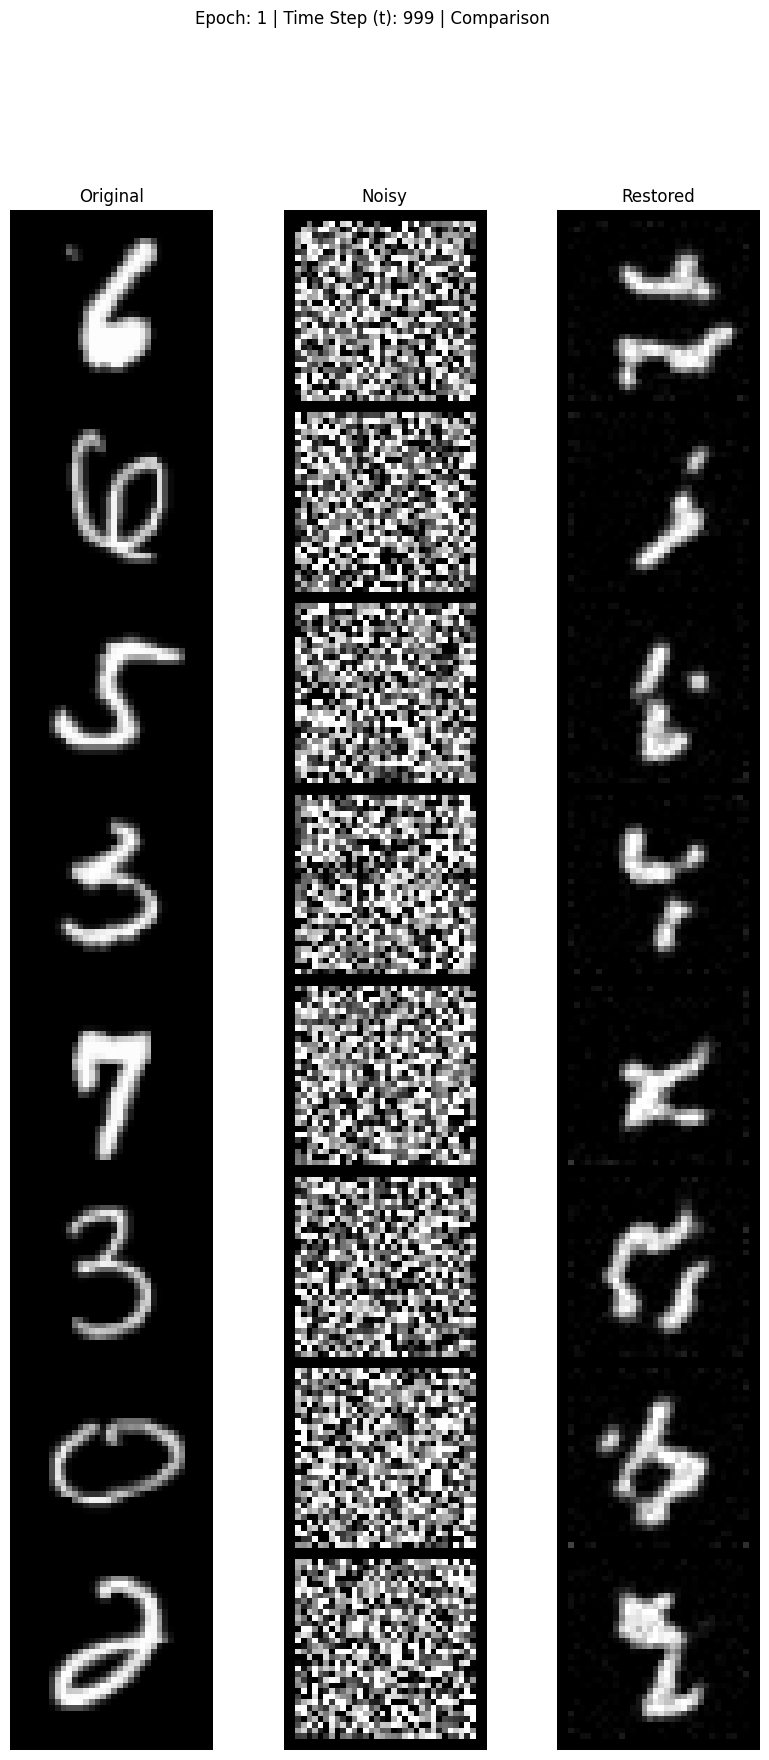

epoch:   2/50 	 iter :  50/469 	 loss: 0.044879
epoch:   2/50 	 iter : 100/469 	 loss: 0.044508
epoch:   2/50 	 iter : 150/469 	 loss: 0.043931
epoch:   2/50 	 iter : 200/469 	 loss: 0.043290
epoch:   2/50 	 iter : 250/469 	 loss: 0.043079
epoch:   2/50 	 iter : 300/469 	 loss: 0.042857
epoch:   2/50 	 iter : 350/469 	 loss: 0.042458
epoch:   2/50 	 iter : 400/469 	 loss: 0.042183
epoch:   2/50 	 iter : 450/469 	 loss: 0.041696
epoch:   2/50 	 total loss: 0.041610


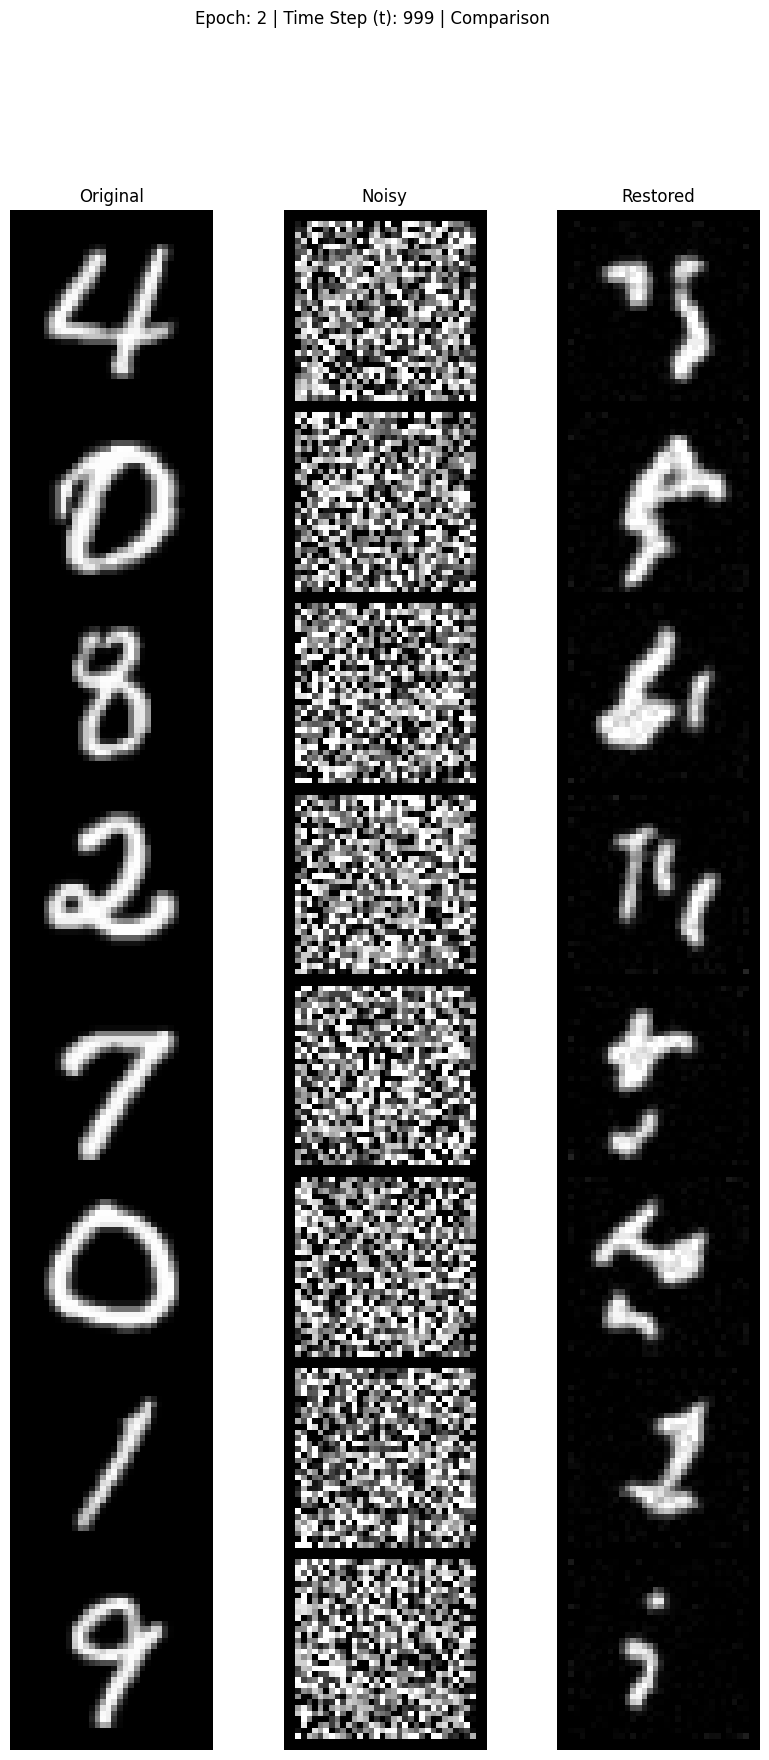

epoch:   3/50 	 iter :  50/469 	 loss: 0.038383
epoch:   3/50 	 iter : 100/469 	 loss: 0.038146
epoch:   3/50 	 iter : 150/469 	 loss: 0.037583
epoch:   3/50 	 iter : 200/469 	 loss: 0.037121
epoch:   3/50 	 iter : 250/469 	 loss: 0.037138
epoch:   3/50 	 iter : 300/469 	 loss: 0.036894
epoch:   3/50 	 iter : 350/469 	 loss: 0.036847
epoch:   3/50 	 iter : 400/469 	 loss: 0.036786
epoch:   3/50 	 iter : 450/469 	 loss: 0.036641
epoch:   3/50 	 total loss: 0.036545


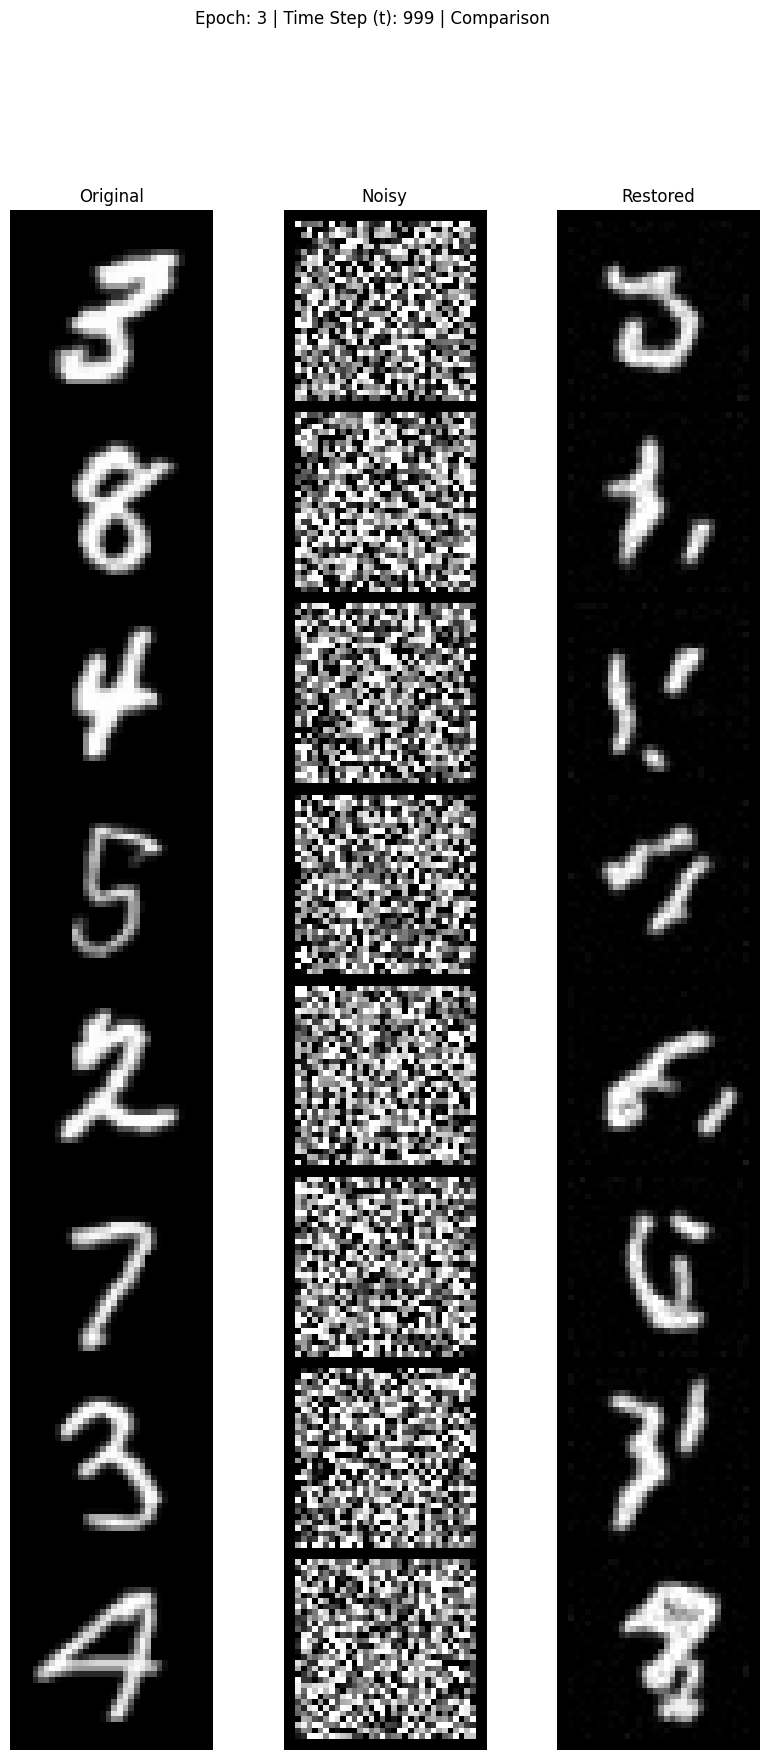

epoch:   4/50 	 iter :  50/469 	 loss: 0.034867
epoch:   4/50 	 iter : 100/469 	 loss: 0.034759
epoch:   4/50 	 iter : 150/469 	 loss: 0.034108
epoch:   4/50 	 iter : 200/469 	 loss: 0.033942
epoch:   4/50 	 iter : 250/469 	 loss: 0.033721
epoch:   4/50 	 iter : 300/469 	 loss: 0.034124
epoch:   4/50 	 iter : 350/469 	 loss: 0.033791
epoch:   4/50 	 iter : 400/469 	 loss: 0.033461
epoch:   4/50 	 iter : 450/469 	 loss: 0.033341
epoch:   4/50 	 total loss: 0.033340


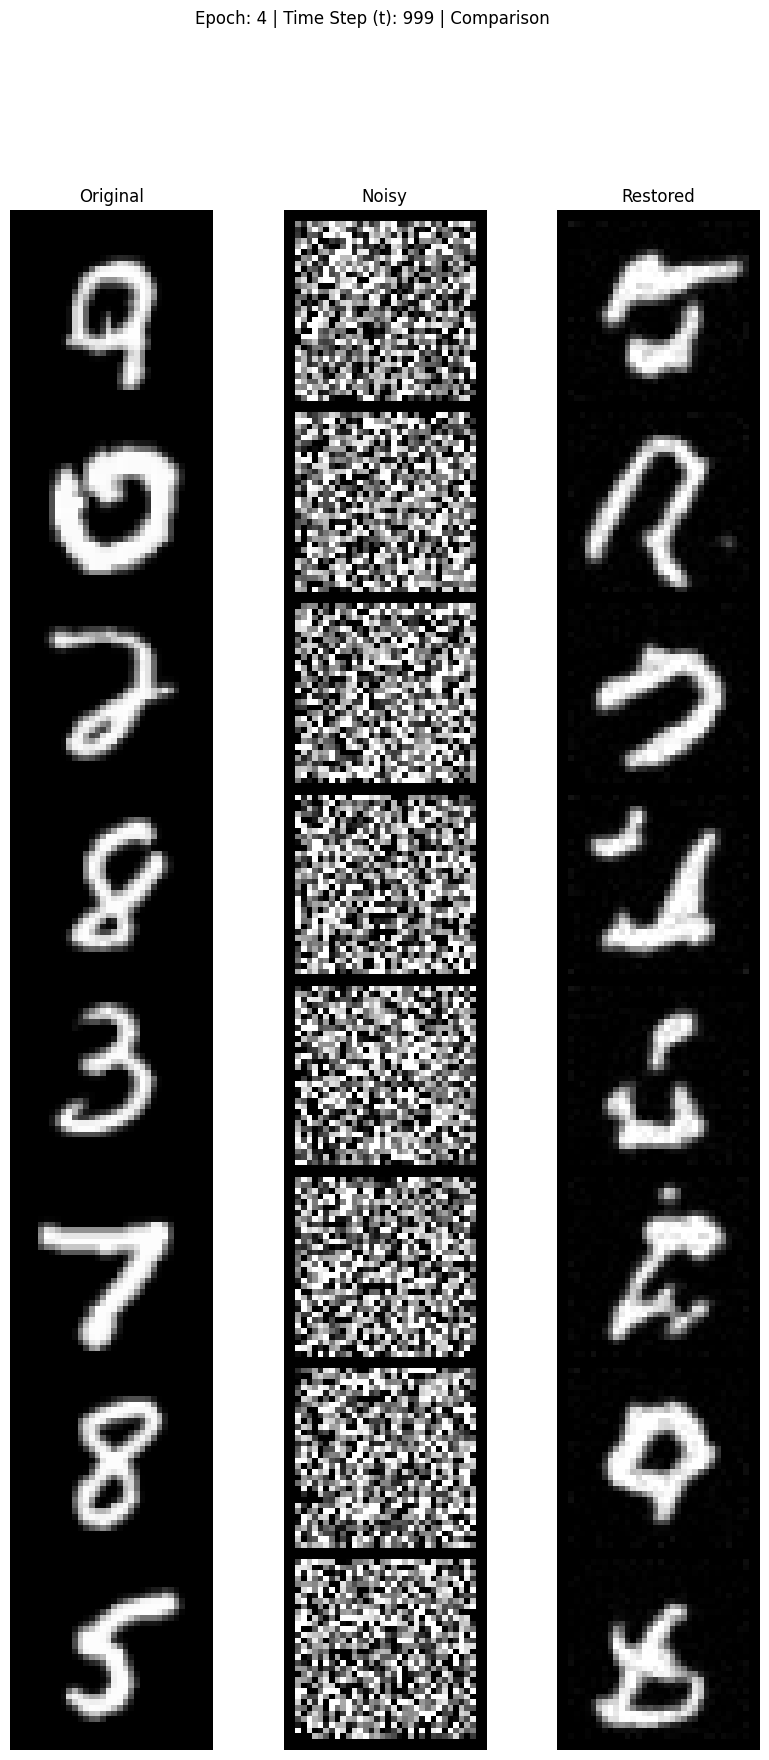

epoch:   5/50 	 iter :  50/469 	 loss: 0.031922
epoch:   5/50 	 iter : 100/469 	 loss: 0.031126
epoch:   5/50 	 iter : 150/469 	 loss: 0.031035
epoch:   5/50 	 iter : 200/469 	 loss: 0.030952
epoch:   5/50 	 iter : 250/469 	 loss: 0.031133
epoch:   5/50 	 iter : 300/469 	 loss: 0.031130
epoch:   5/50 	 iter : 350/469 	 loss: 0.030998
epoch:   5/50 	 iter : 400/469 	 loss: 0.031066
epoch:   5/50 	 iter : 450/469 	 loss: 0.030962
epoch:   5/50 	 total loss: 0.030922


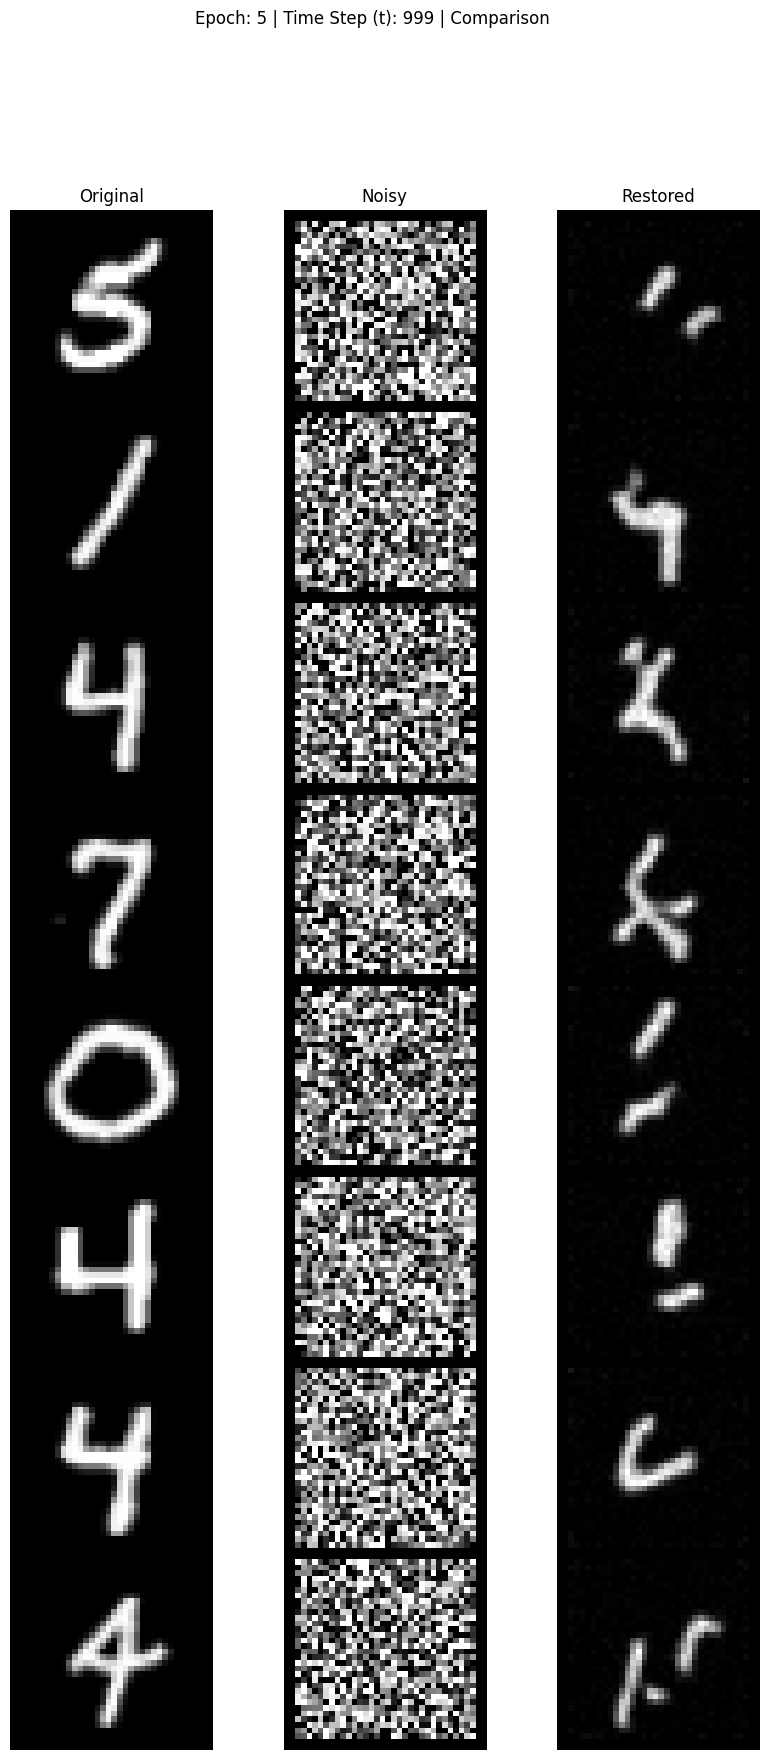

epoch:   6/50 	 iter :  50/469 	 loss: 0.030272
epoch:   6/50 	 iter : 100/469 	 loss: 0.030844
epoch:   6/50 	 iter : 150/469 	 loss: 0.030507
epoch:   6/50 	 iter : 200/469 	 loss: 0.030771
epoch:   6/50 	 iter : 250/469 	 loss: 0.030468
epoch:   6/50 	 iter : 300/469 	 loss: 0.030349
epoch:   6/50 	 iter : 350/469 	 loss: 0.030510
epoch:   6/50 	 iter : 400/469 	 loss: 0.030376
epoch:   6/50 	 iter : 450/469 	 loss: 0.030255
epoch:   6/50 	 total loss: 0.030163


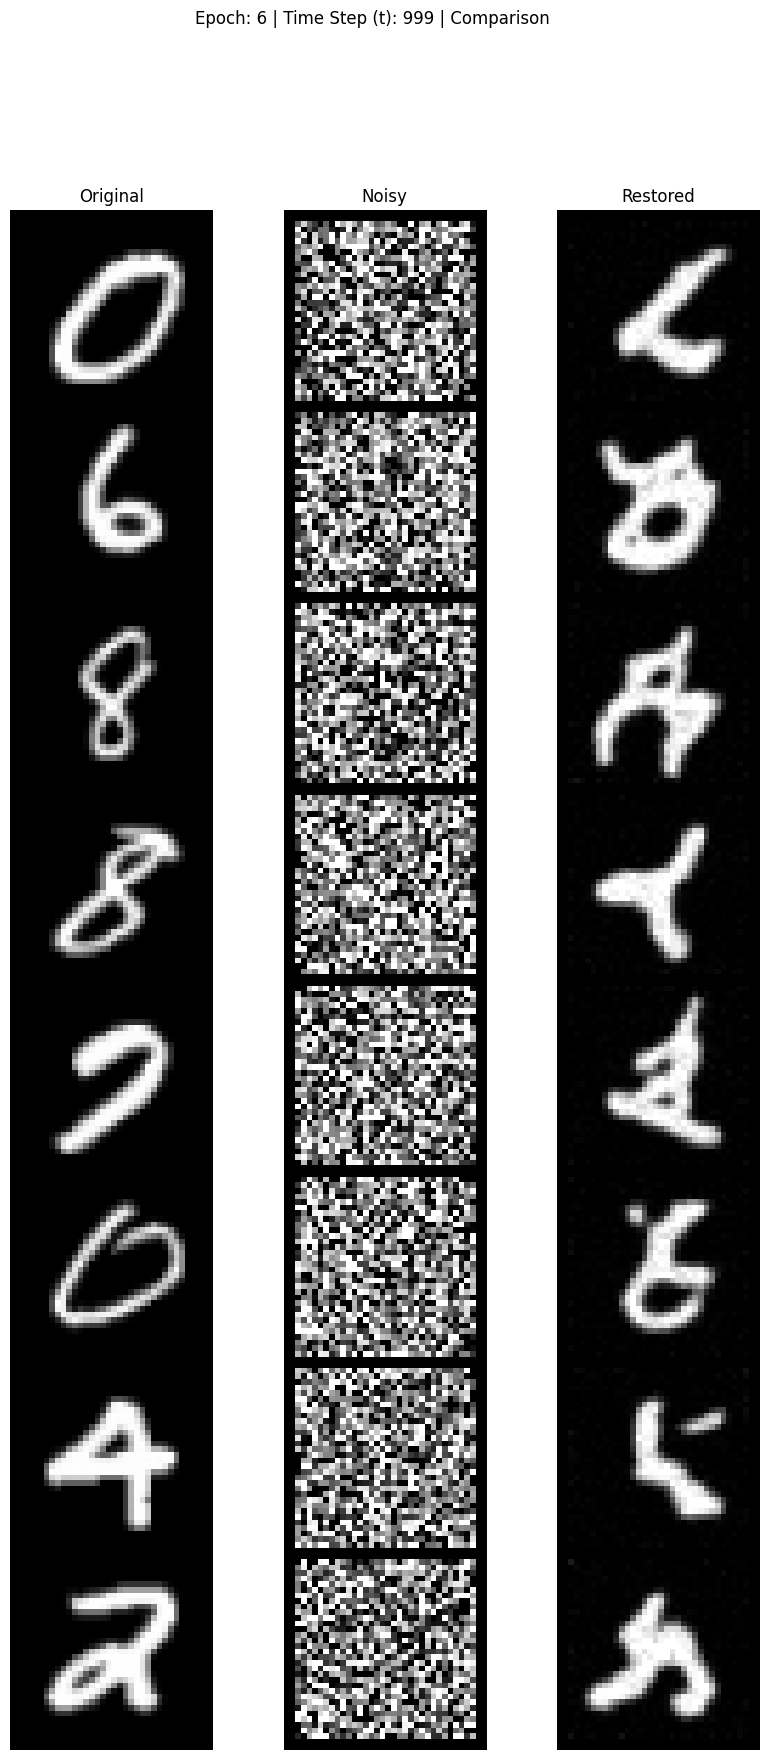

epoch:   7/50 	 iter :  50/469 	 loss: 0.029873
epoch:   7/50 	 iter : 100/469 	 loss: 0.029463
epoch:   7/50 	 iter : 150/469 	 loss: 0.029649
epoch:   7/50 	 iter : 200/469 	 loss: 0.029661
epoch:   7/50 	 iter : 250/469 	 loss: 0.029204
epoch:   7/50 	 iter : 300/469 	 loss: 0.029046
epoch:   7/50 	 iter : 350/469 	 loss: 0.028902
epoch:   7/50 	 iter : 400/469 	 loss: 0.028739
epoch:   7/50 	 iter : 450/469 	 loss: 0.028674
epoch:   7/50 	 total loss: 0.028701


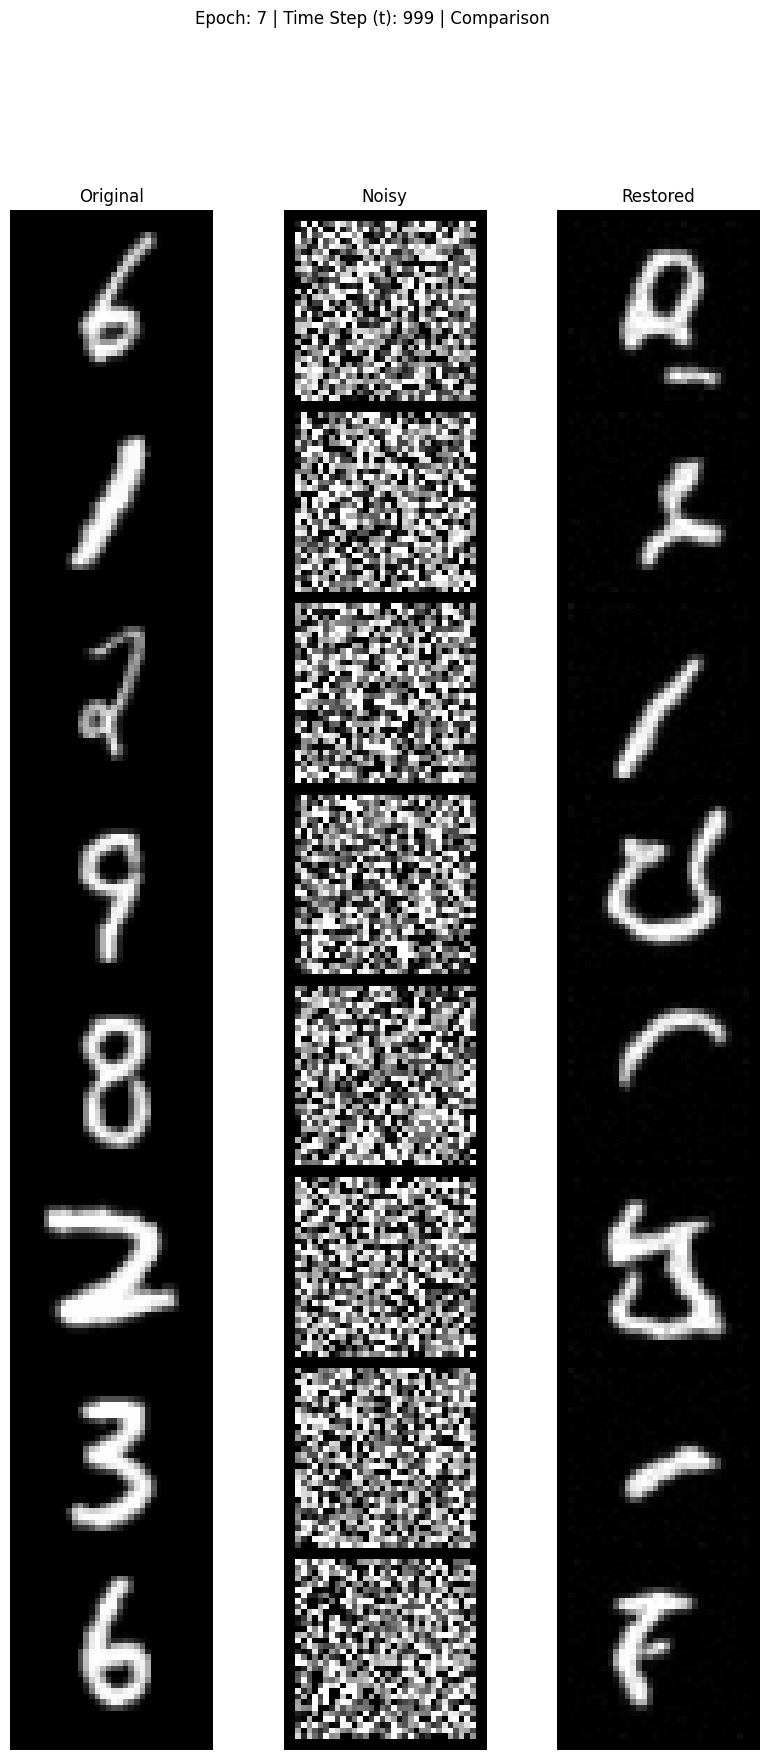

epoch:   8/50 	 iter :  50/469 	 loss: 0.028724
epoch:   8/50 	 iter : 100/469 	 loss: 0.027959
epoch:   8/50 	 iter : 150/469 	 loss: 0.027873
epoch:   8/50 	 iter : 200/469 	 loss: 0.028072
epoch:   8/50 	 iter : 250/469 	 loss: 0.028002
epoch:   8/50 	 iter : 300/469 	 loss: 0.028072
epoch:   8/50 	 iter : 350/469 	 loss: 0.027845
epoch:   8/50 	 iter : 400/469 	 loss: 0.027868
epoch:   8/50 	 iter : 450/469 	 loss: 0.027828
epoch:   8/50 	 total loss: 0.027830


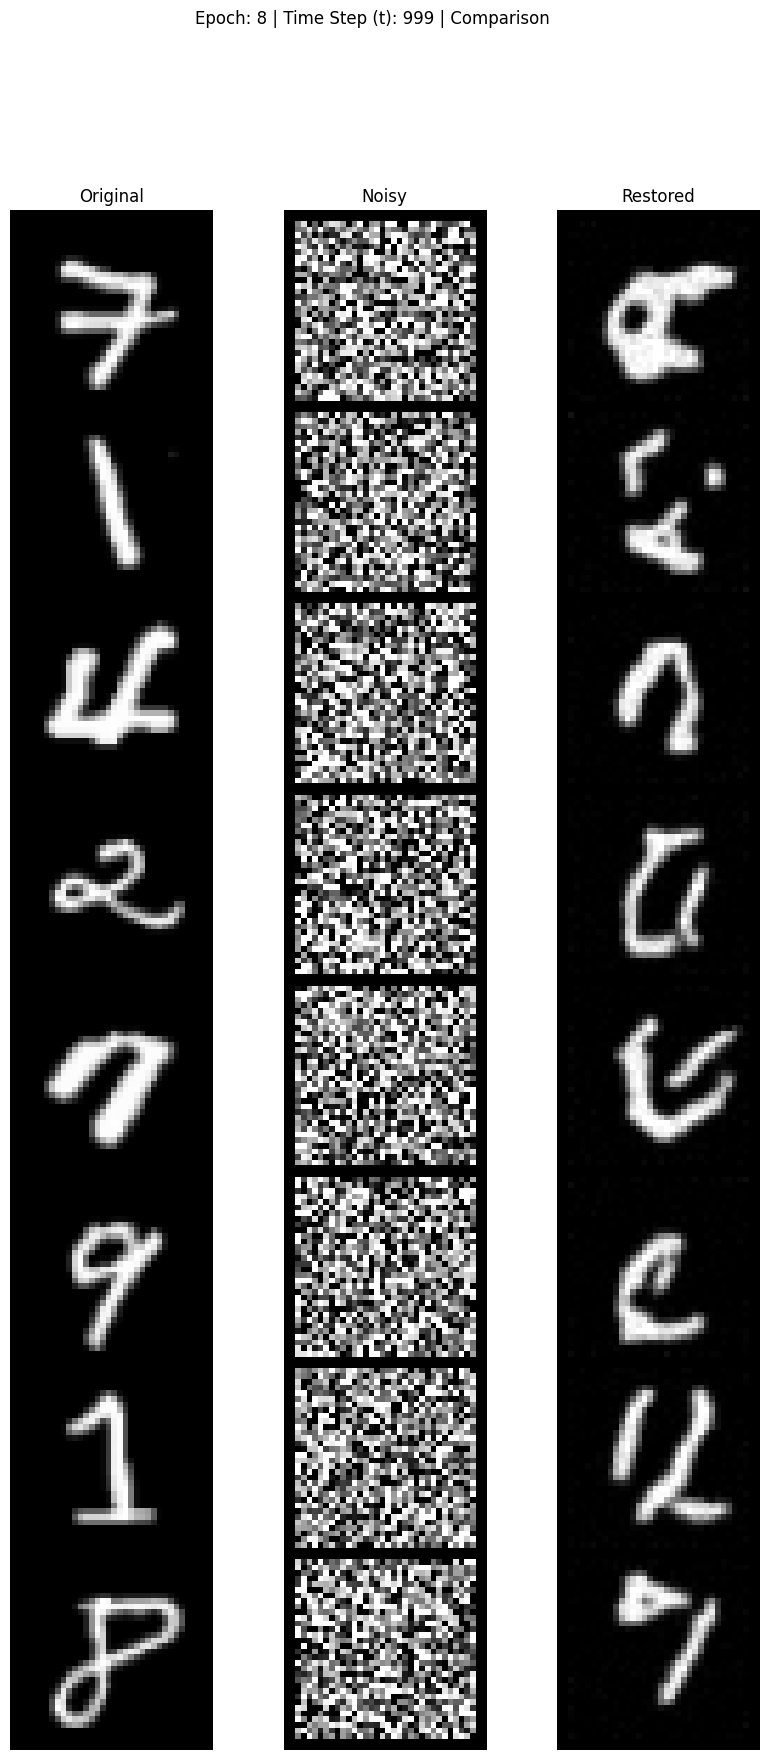

epoch:   9/50 	 iter :  50/469 	 loss: 0.026814
epoch:   9/50 	 iter : 100/469 	 loss: 0.026672
epoch:   9/50 	 iter : 150/469 	 loss: 0.027049
epoch:   9/50 	 iter : 200/469 	 loss: 0.026754
epoch:   9/50 	 iter : 250/469 	 loss: 0.026867
epoch:   9/50 	 iter : 300/469 	 loss: 0.026856
epoch:   9/50 	 iter : 350/469 	 loss: 0.026874
epoch:   9/50 	 iter : 400/469 	 loss: 0.026968
epoch:   9/50 	 iter : 450/469 	 loss: 0.026907
epoch:   9/50 	 total loss: 0.026831


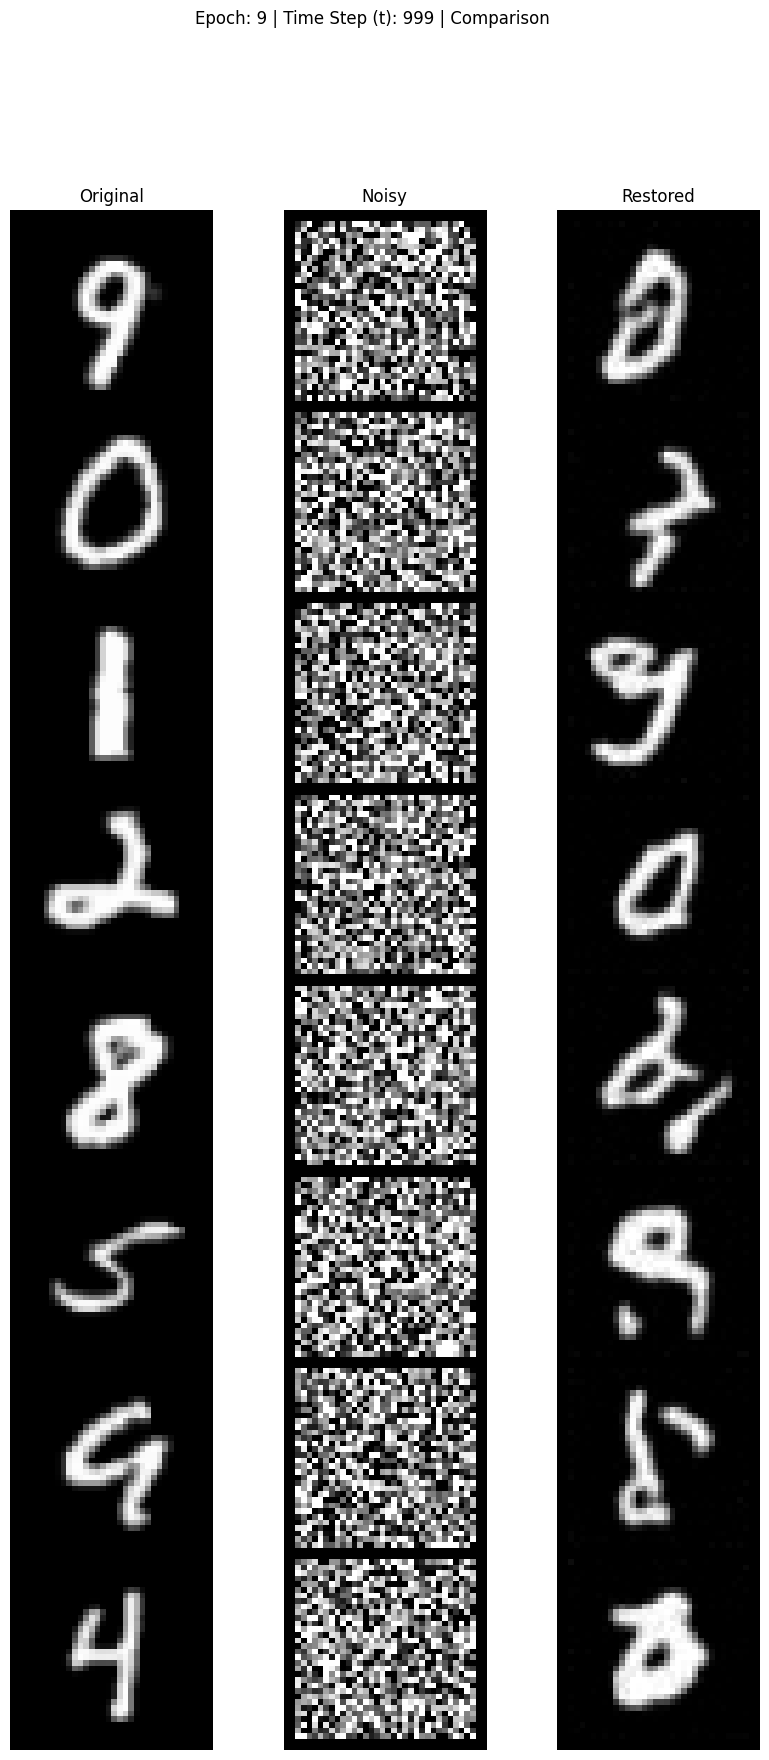

epoch:  10/50 	 iter :  50/469 	 loss: 0.026715
epoch:  10/50 	 iter : 100/469 	 loss: 0.026288
epoch:  10/50 	 iter : 150/469 	 loss: 0.026215
epoch:  10/50 	 iter : 200/469 	 loss: 0.025952
epoch:  10/50 	 iter : 250/469 	 loss: 0.025837
epoch:  10/50 	 iter : 300/469 	 loss: 0.026048
epoch:  10/50 	 iter : 350/469 	 loss: 0.026098
epoch:  10/50 	 iter : 400/469 	 loss: 0.026147
epoch:  10/50 	 iter : 450/469 	 loss: 0.026231
epoch:  10/50 	 total loss: 0.026260


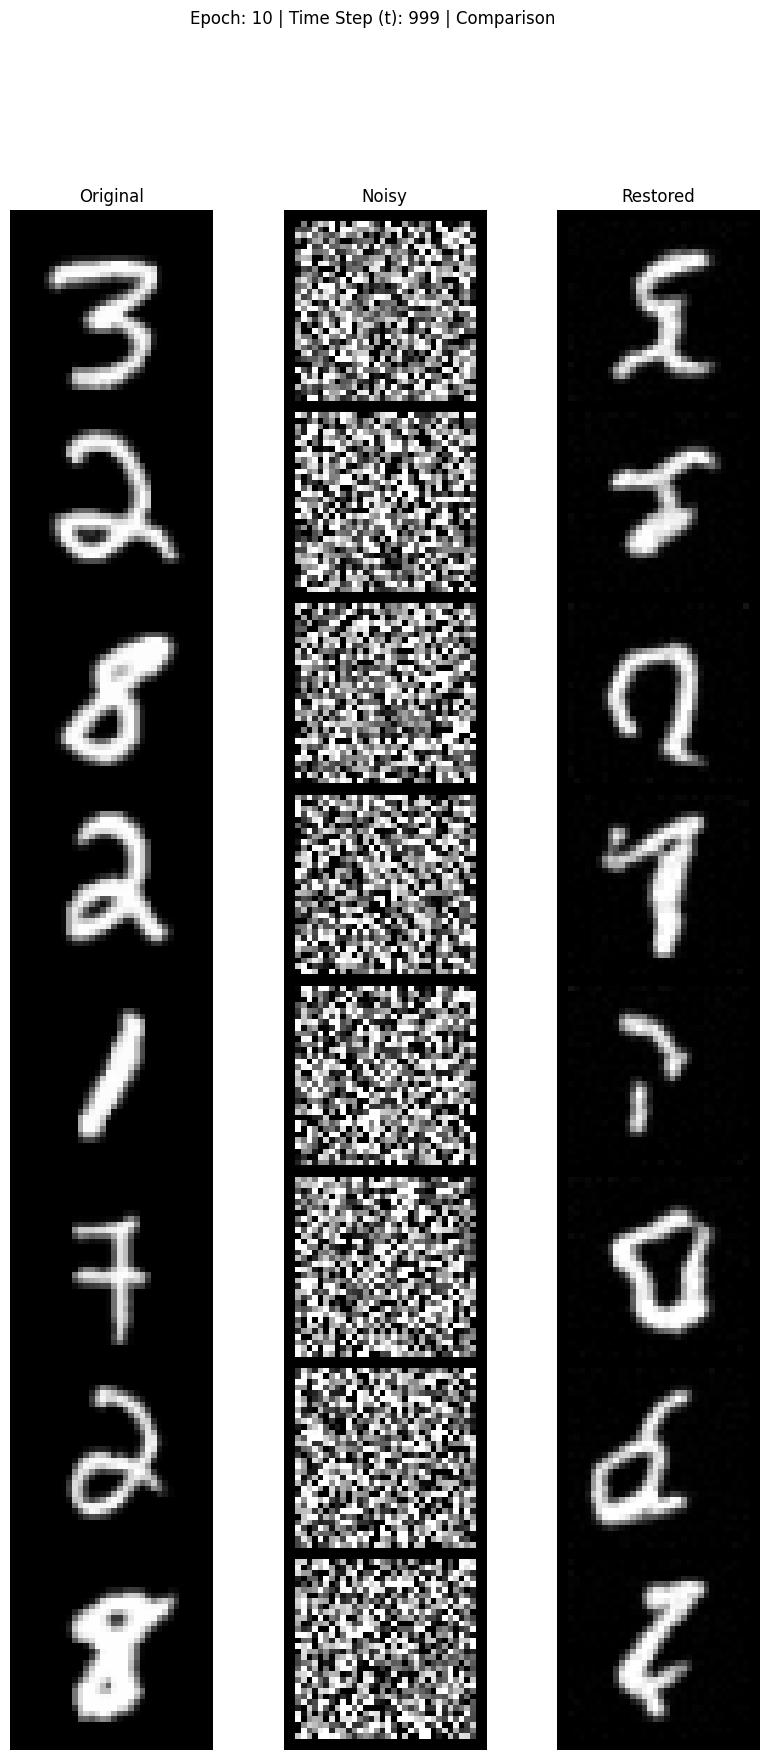

epoch:  11/50 	 iter :  50/469 	 loss: 0.025558
epoch:  11/50 	 iter : 100/469 	 loss: 0.025348
epoch:  11/50 	 iter : 150/469 	 loss: 0.025711
epoch:  11/50 	 iter : 200/469 	 loss: 0.025698
epoch:  11/50 	 iter : 250/469 	 loss: 0.025752
epoch:  11/50 	 iter : 300/469 	 loss: 0.025926
epoch:  11/50 	 iter : 350/469 	 loss: 0.025918
epoch:  11/50 	 iter : 400/469 	 loss: 0.026062
epoch:  11/50 	 iter : 450/469 	 loss: 0.026033
epoch:  11/50 	 total loss: 0.026032


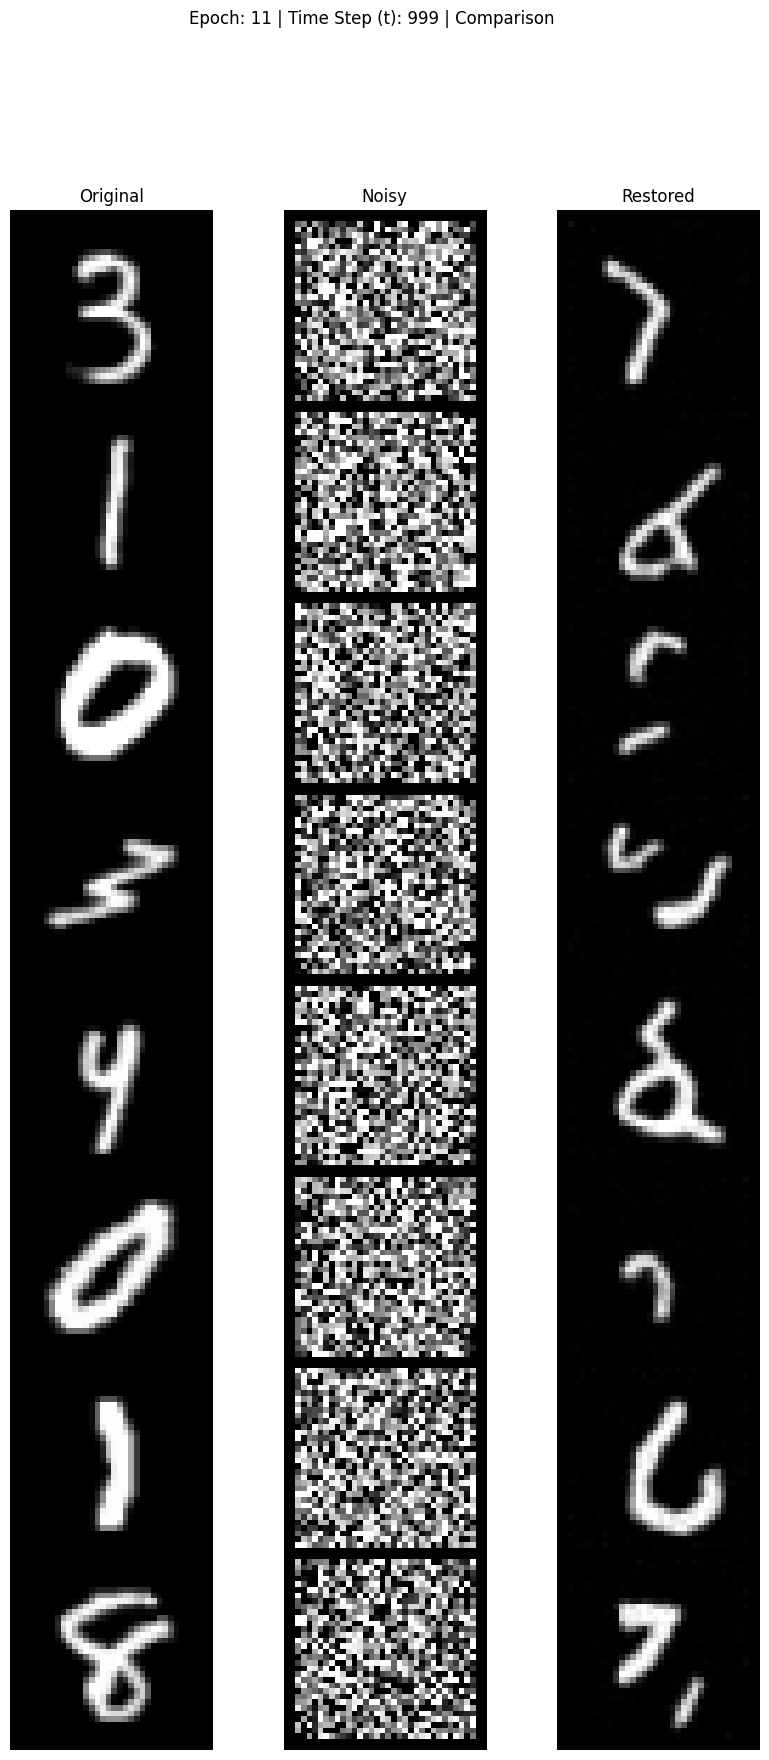

epoch:  12/50 	 iter :  50/469 	 loss: 0.025116
epoch:  12/50 	 iter : 100/469 	 loss: 0.025065
epoch:  12/50 	 iter : 150/469 	 loss: 0.025417
epoch:  12/50 	 iter : 200/469 	 loss: 0.025788
epoch:  12/50 	 iter : 250/469 	 loss: 0.025501
epoch:  12/50 	 iter : 300/469 	 loss: 0.025455
epoch:  12/50 	 iter : 350/469 	 loss: 0.025556
epoch:  12/50 	 iter : 400/469 	 loss: 0.025553
epoch:  12/50 	 iter : 450/469 	 loss: 0.025487
epoch:  12/50 	 total loss: 0.025522


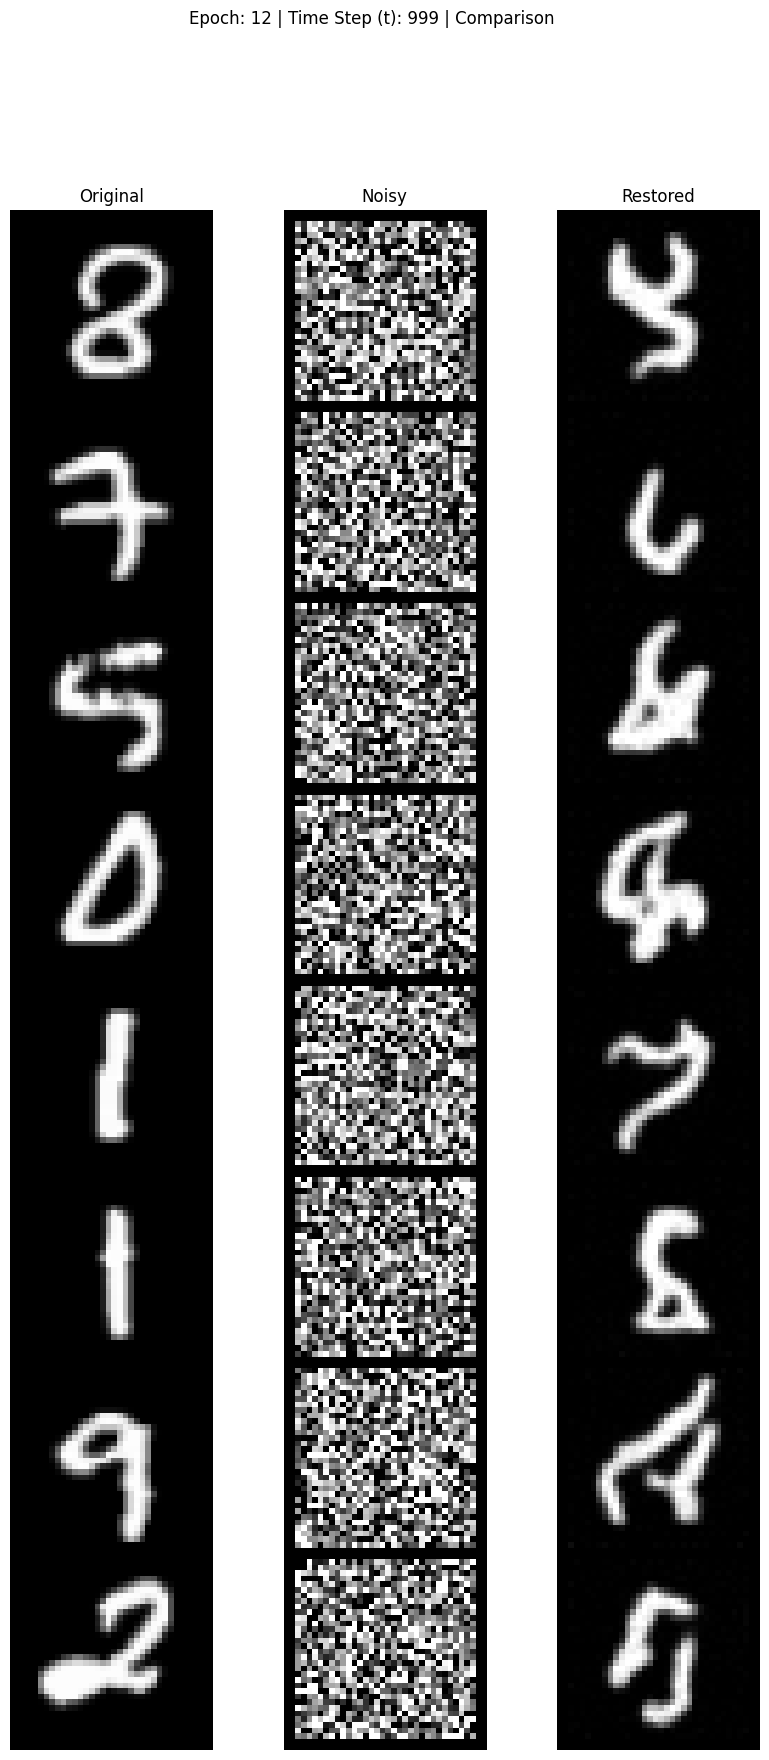

epoch:  13/50 	 iter :  50/469 	 loss: 0.025020
epoch:  13/50 	 iter : 100/469 	 loss: 0.024573
epoch:  13/50 	 iter : 150/469 	 loss: 0.024820
epoch:  13/50 	 iter : 200/469 	 loss: 0.024978
epoch:  13/50 	 iter : 250/469 	 loss: 0.025097
epoch:  13/50 	 iter : 300/469 	 loss: 0.025034
epoch:  13/50 	 iter : 350/469 	 loss: 0.024975
epoch:  13/50 	 iter : 400/469 	 loss: 0.024993
epoch:  13/50 	 iter : 450/469 	 loss: 0.024970
epoch:  13/50 	 total loss: 0.024942


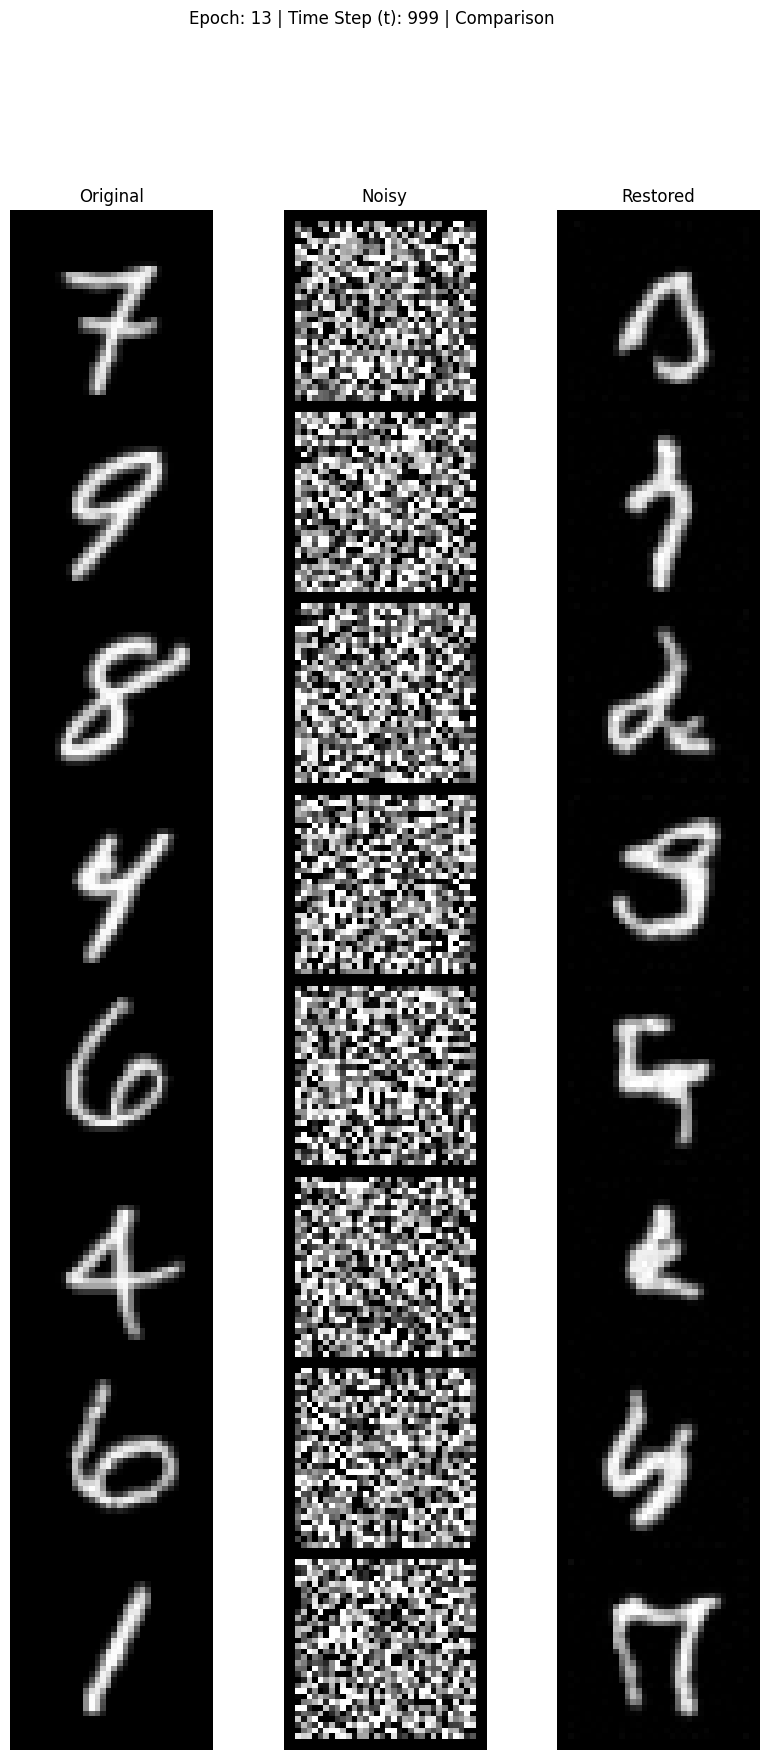

epoch:  14/50 	 iter :  50/469 	 loss: 0.025522
epoch:  14/50 	 iter : 100/469 	 loss: 0.024999
epoch:  14/50 	 iter : 150/469 	 loss: 0.025142
epoch:  14/50 	 iter : 200/469 	 loss: 0.024841
epoch:  14/50 	 iter : 250/469 	 loss: 0.024717
epoch:  14/50 	 iter : 300/469 	 loss: 0.024619
epoch:  14/50 	 iter : 350/469 	 loss: 0.024509
epoch:  14/50 	 iter : 400/469 	 loss: 0.024444
epoch:  14/50 	 iter : 450/469 	 loss: 0.024467
epoch:  14/50 	 total loss: 0.024444


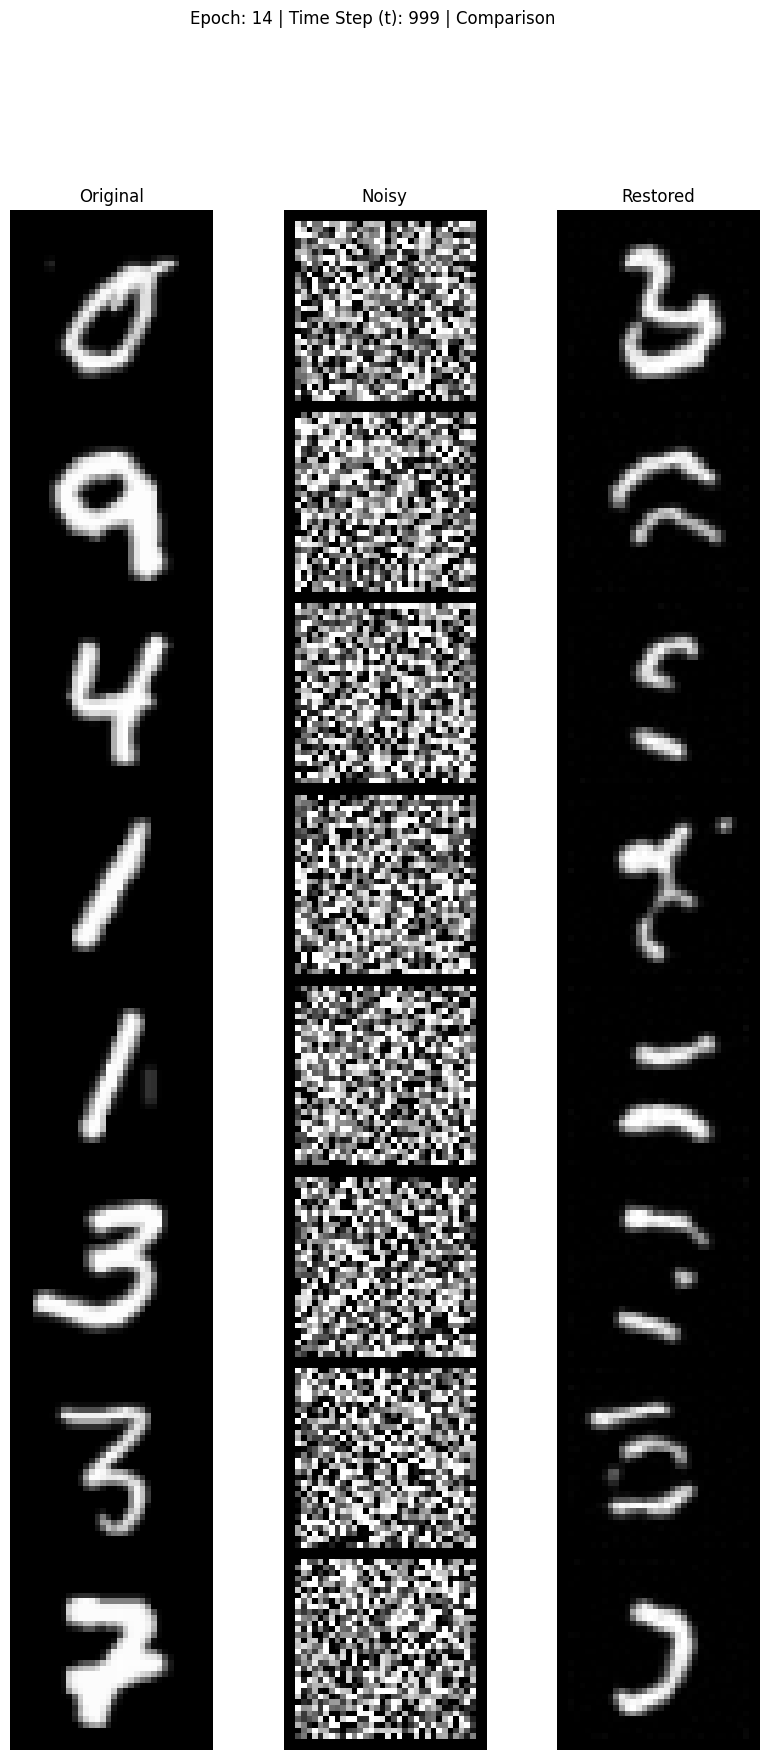

epoch:  15/50 	 iter :  50/469 	 loss: 0.024685
epoch:  15/50 	 iter : 100/469 	 loss: 0.024549
epoch:  15/50 	 iter : 150/469 	 loss: 0.025141
epoch:  15/50 	 iter : 200/469 	 loss: 0.024843
epoch:  15/50 	 iter : 250/469 	 loss: 0.024591
epoch:  15/50 	 iter : 300/469 	 loss: 0.024592
epoch:  15/50 	 iter : 350/469 	 loss: 0.024514
epoch:  15/50 	 iter : 400/469 	 loss: 0.024420
epoch:  15/50 	 iter : 450/469 	 loss: 0.024416
epoch:  15/50 	 total loss: 0.024451


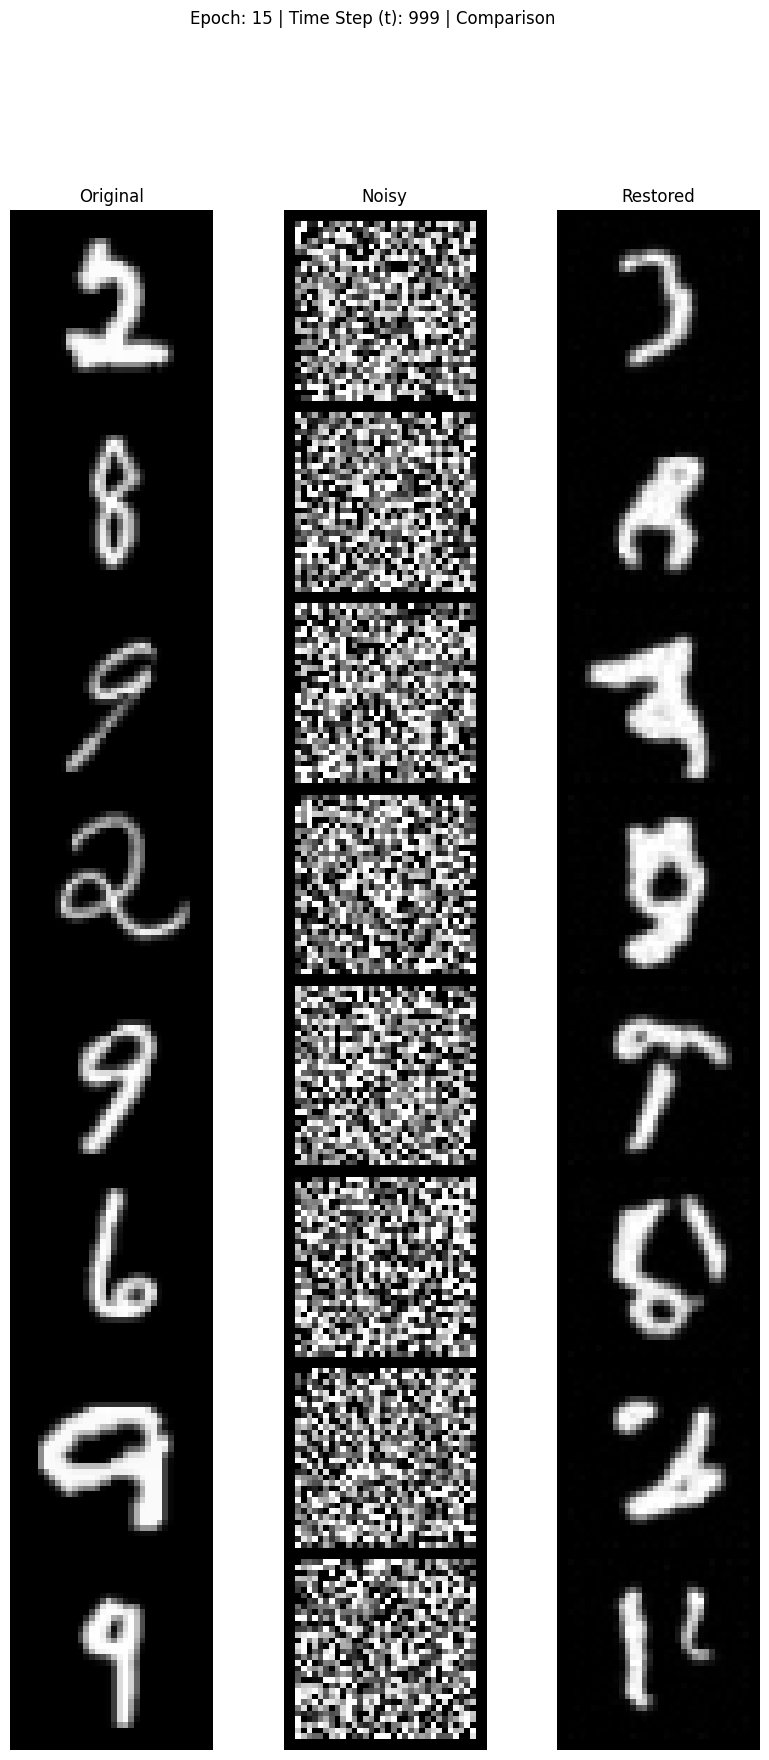

epoch:  16/50 	 iter :  50/469 	 loss: 0.024173
epoch:  16/50 	 iter : 100/469 	 loss: 0.023921
epoch:  16/50 	 iter : 150/469 	 loss: 0.023557
epoch:  16/50 	 iter : 200/469 	 loss: 0.023706
epoch:  16/50 	 iter : 250/469 	 loss: 0.023791
epoch:  16/50 	 iter : 300/469 	 loss: 0.023778
epoch:  16/50 	 iter : 350/469 	 loss: 0.023926
epoch:  16/50 	 iter : 400/469 	 loss: 0.023961
epoch:  16/50 	 iter : 450/469 	 loss: 0.023998
epoch:  16/50 	 total loss: 0.023929


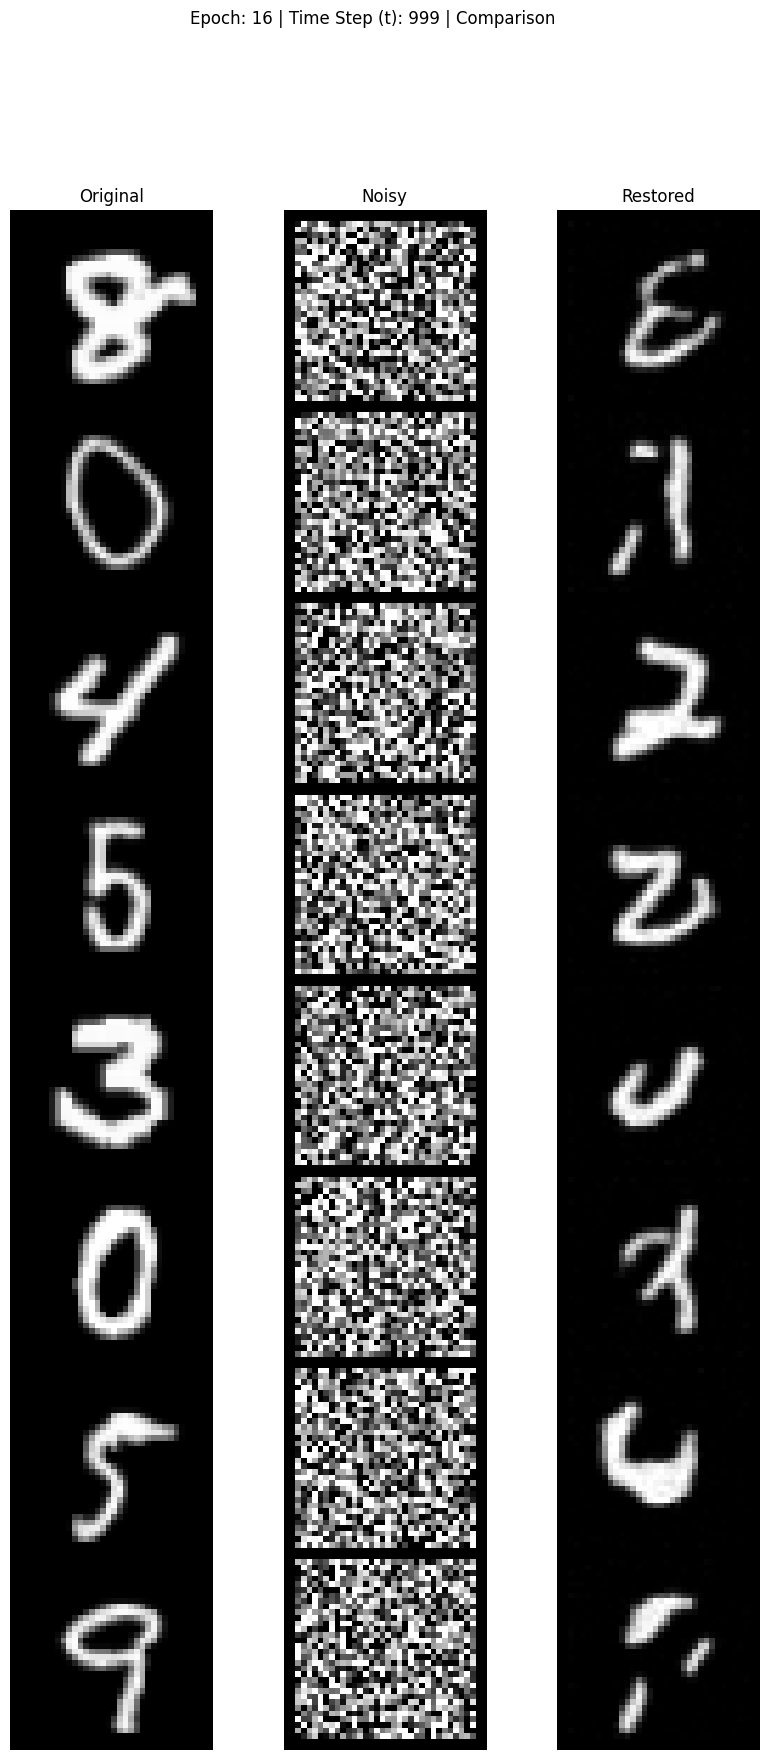

epoch:  17/50 	 iter :  50/469 	 loss: 0.023665
epoch:  17/50 	 iter : 100/469 	 loss: 0.023561
epoch:  17/50 	 iter : 150/469 	 loss: 0.023527
epoch:  17/50 	 iter : 200/469 	 loss: 0.023401
epoch:  17/50 	 iter : 250/469 	 loss: 0.023421
epoch:  17/50 	 iter : 300/469 	 loss: 0.023593
epoch:  17/50 	 iter : 350/469 	 loss: 0.023681
epoch:  17/50 	 iter : 400/469 	 loss: 0.023689
epoch:  17/50 	 iter : 450/469 	 loss: 0.023868
epoch:  17/50 	 total loss: 0.023891


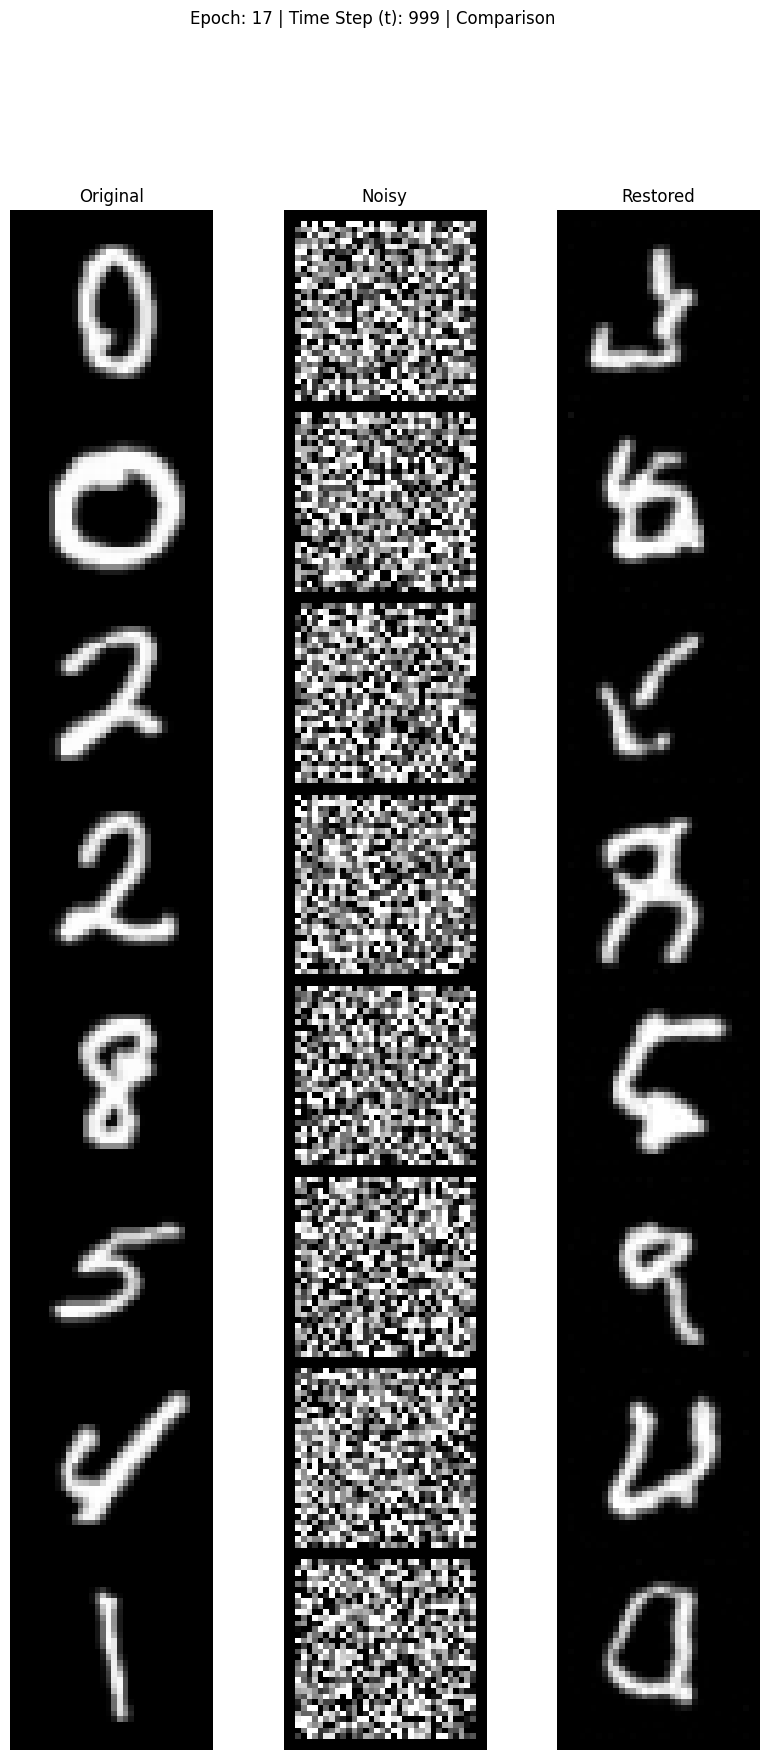

epoch:  18/50 	 iter :  50/469 	 loss: 0.023480
epoch:  18/50 	 iter : 100/469 	 loss: 0.023516
epoch:  18/50 	 iter : 150/469 	 loss: 0.023608
epoch:  18/50 	 iter : 200/469 	 loss: 0.023580
epoch:  18/50 	 iter : 250/469 	 loss: 0.023464
epoch:  18/50 	 iter : 300/469 	 loss: 0.023366
epoch:  18/50 	 iter : 350/469 	 loss: 0.023463
epoch:  18/50 	 iter : 400/469 	 loss: 0.023499
epoch:  18/50 	 iter : 450/469 	 loss: 0.023431
epoch:  18/50 	 total loss: 0.023442


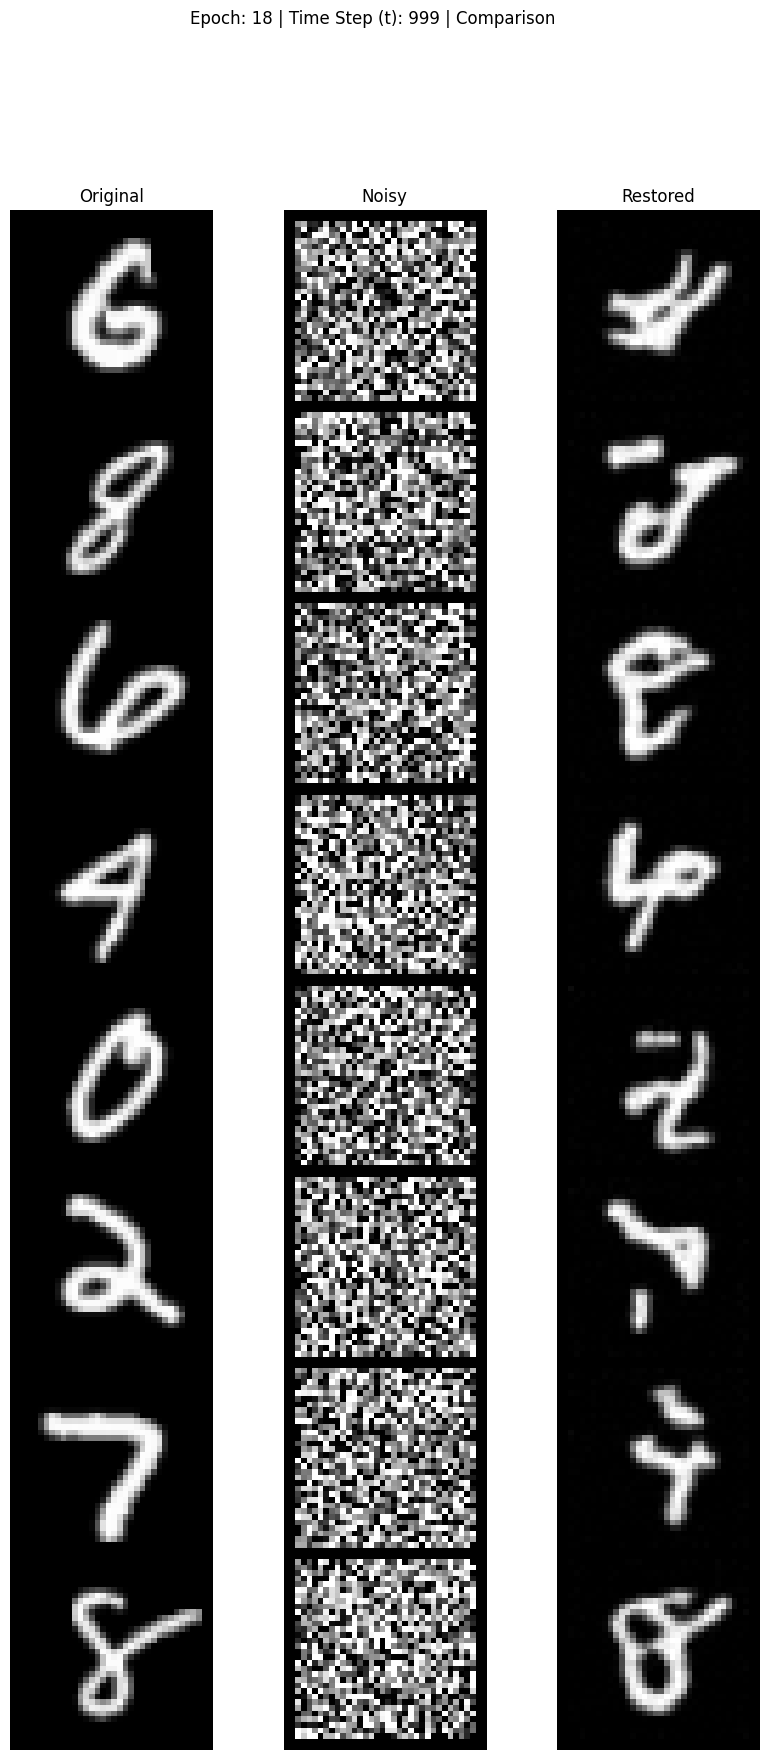

epoch:  19/50 	 iter :  50/469 	 loss: 0.022776
epoch:  19/50 	 iter : 100/469 	 loss: 0.023279
epoch:  19/50 	 iter : 150/469 	 loss: 0.022914
epoch:  19/50 	 iter : 200/469 	 loss: 0.022939
epoch:  19/50 	 iter : 250/469 	 loss: 0.023021
epoch:  19/50 	 iter : 300/469 	 loss: 0.022945
epoch:  19/50 	 iter : 350/469 	 loss: 0.023023
epoch:  19/50 	 iter : 400/469 	 loss: 0.023004
epoch:  19/50 	 iter : 450/469 	 loss: 0.023071
epoch:  19/50 	 total loss: 0.023046


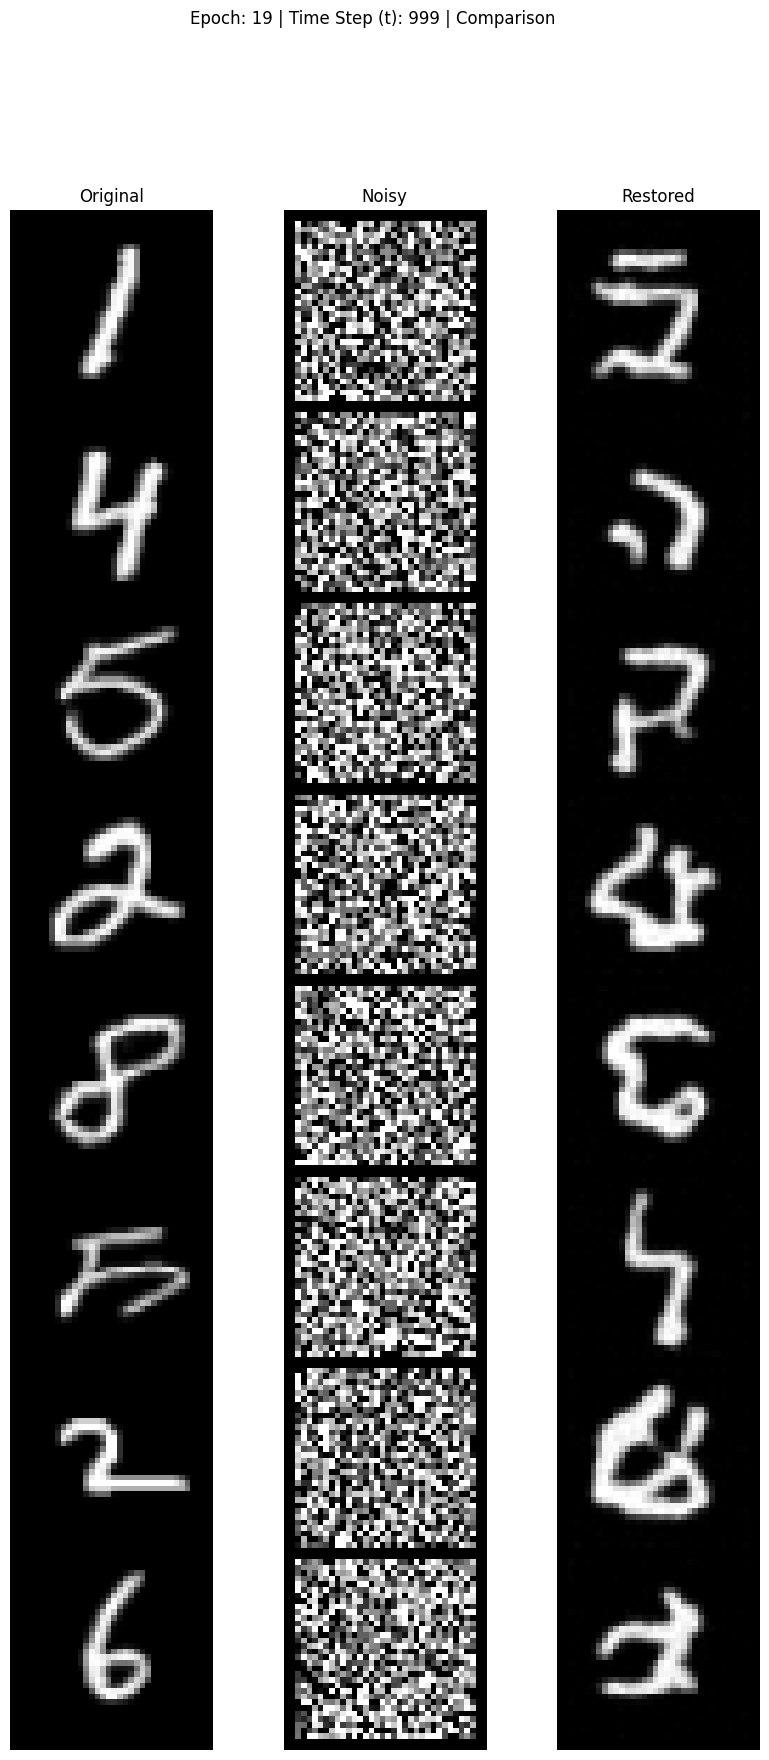

epoch:  20/50 	 iter :  50/469 	 loss: 0.023281
epoch:  20/50 	 iter : 100/469 	 loss: 0.023904
epoch:  20/50 	 iter : 150/469 	 loss: 0.023570
epoch:  20/50 	 iter : 200/469 	 loss: 0.023367
epoch:  20/50 	 iter : 250/469 	 loss: 0.023256
epoch:  20/50 	 iter : 300/469 	 loss: 0.023136
epoch:  20/50 	 iter : 350/469 	 loss: 0.023096
epoch:  20/50 	 iter : 400/469 	 loss: 0.023019
epoch:  20/50 	 iter : 450/469 	 loss: 0.022964
epoch:  20/50 	 total loss: 0.023016


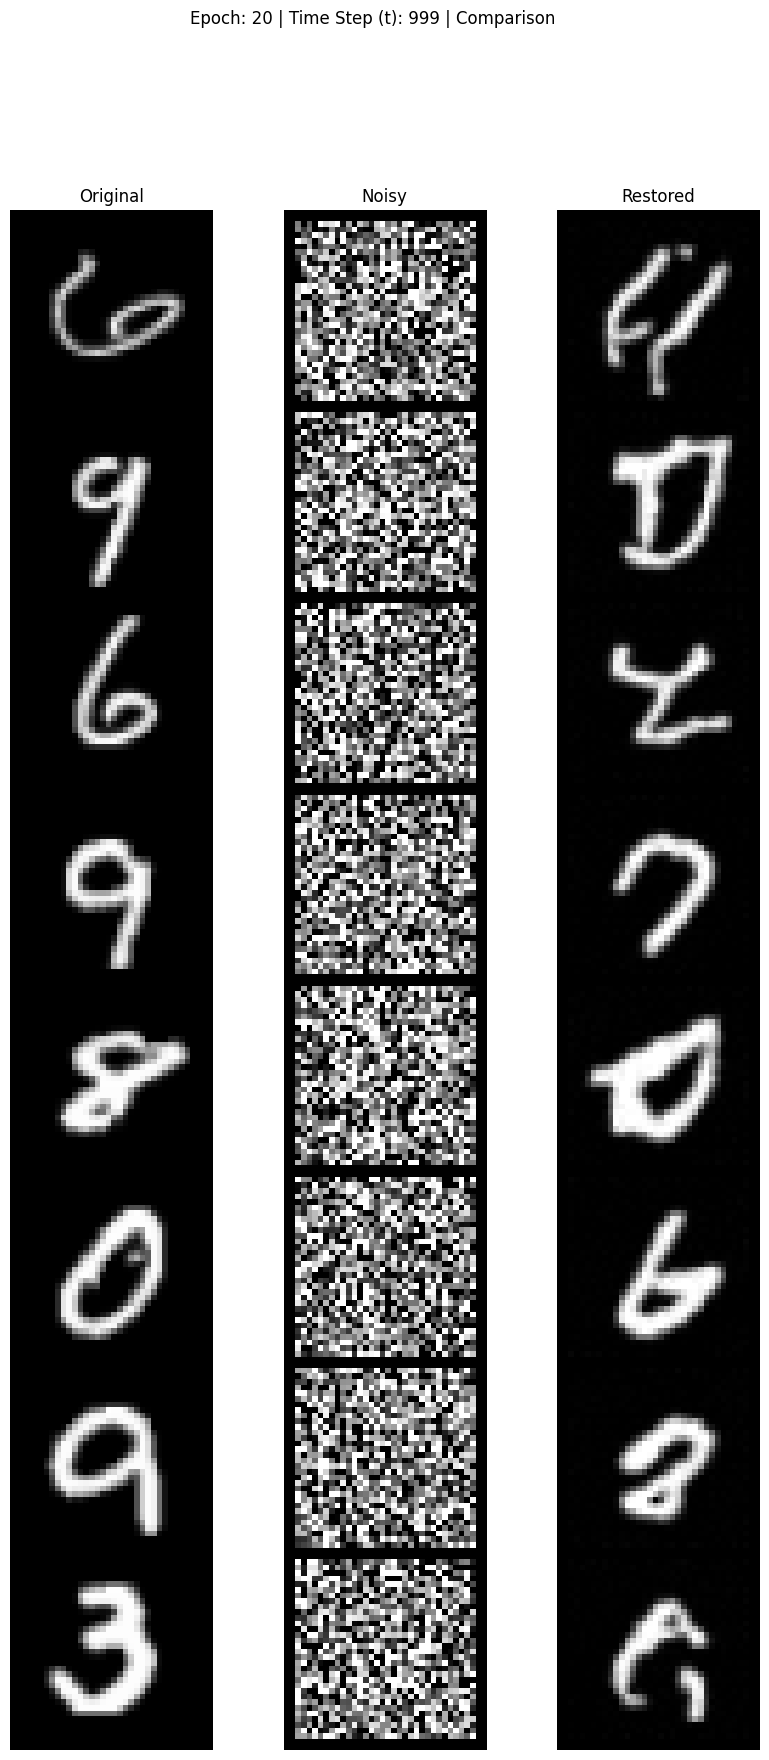

epoch:  21/50 	 iter :  50/469 	 loss: 0.022929
epoch:  21/50 	 iter : 100/469 	 loss: 0.022557
epoch:  21/50 	 iter : 150/469 	 loss: 0.022644
epoch:  21/50 	 iter : 200/469 	 loss: 0.022507
epoch:  21/50 	 iter : 250/469 	 loss: 0.022634
epoch:  21/50 	 iter : 300/469 	 loss: 0.022726
epoch:  21/50 	 iter : 350/469 	 loss: 0.022939
epoch:  21/50 	 iter : 400/469 	 loss: 0.022874
epoch:  21/50 	 iter : 450/469 	 loss: 0.022724
epoch:  21/50 	 total loss: 0.022739


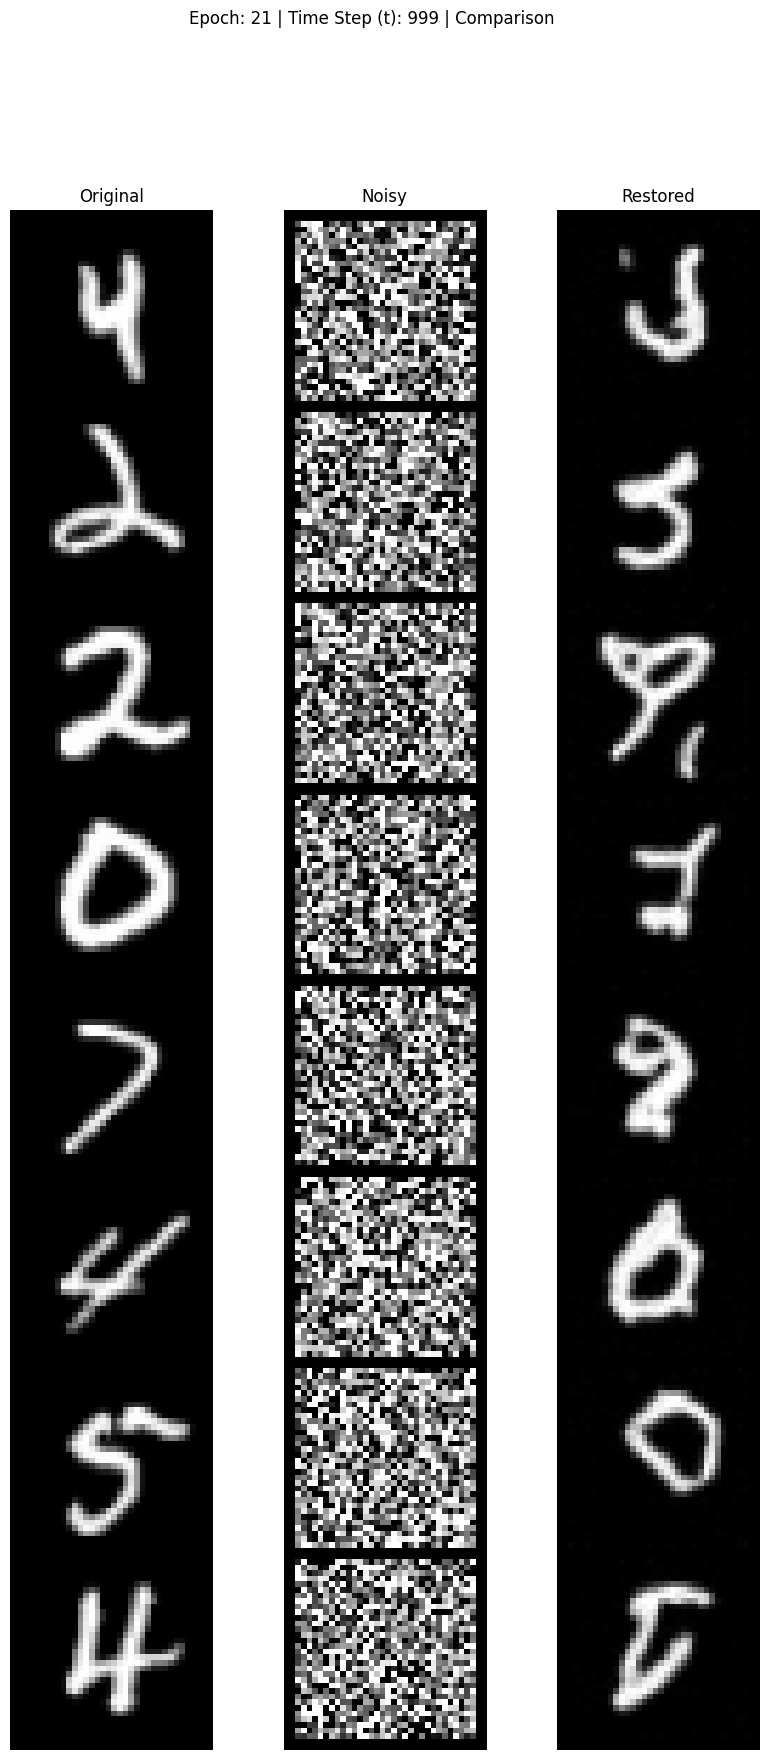

epoch:  22/50 	 iter :  50/469 	 loss: 0.022921
epoch:  22/50 	 iter : 100/469 	 loss: 0.022751
epoch:  22/50 	 iter : 150/469 	 loss: 0.022492
epoch:  22/50 	 iter : 200/469 	 loss: 0.022522
epoch:  22/50 	 iter : 250/469 	 loss: 0.022483
epoch:  22/50 	 iter : 300/469 	 loss: 0.022544
epoch:  22/50 	 iter : 350/469 	 loss: 0.022667
epoch:  22/50 	 iter : 400/469 	 loss: 0.022548
epoch:  22/50 	 iter : 450/469 	 loss: 0.022565
epoch:  22/50 	 total loss: 0.022536


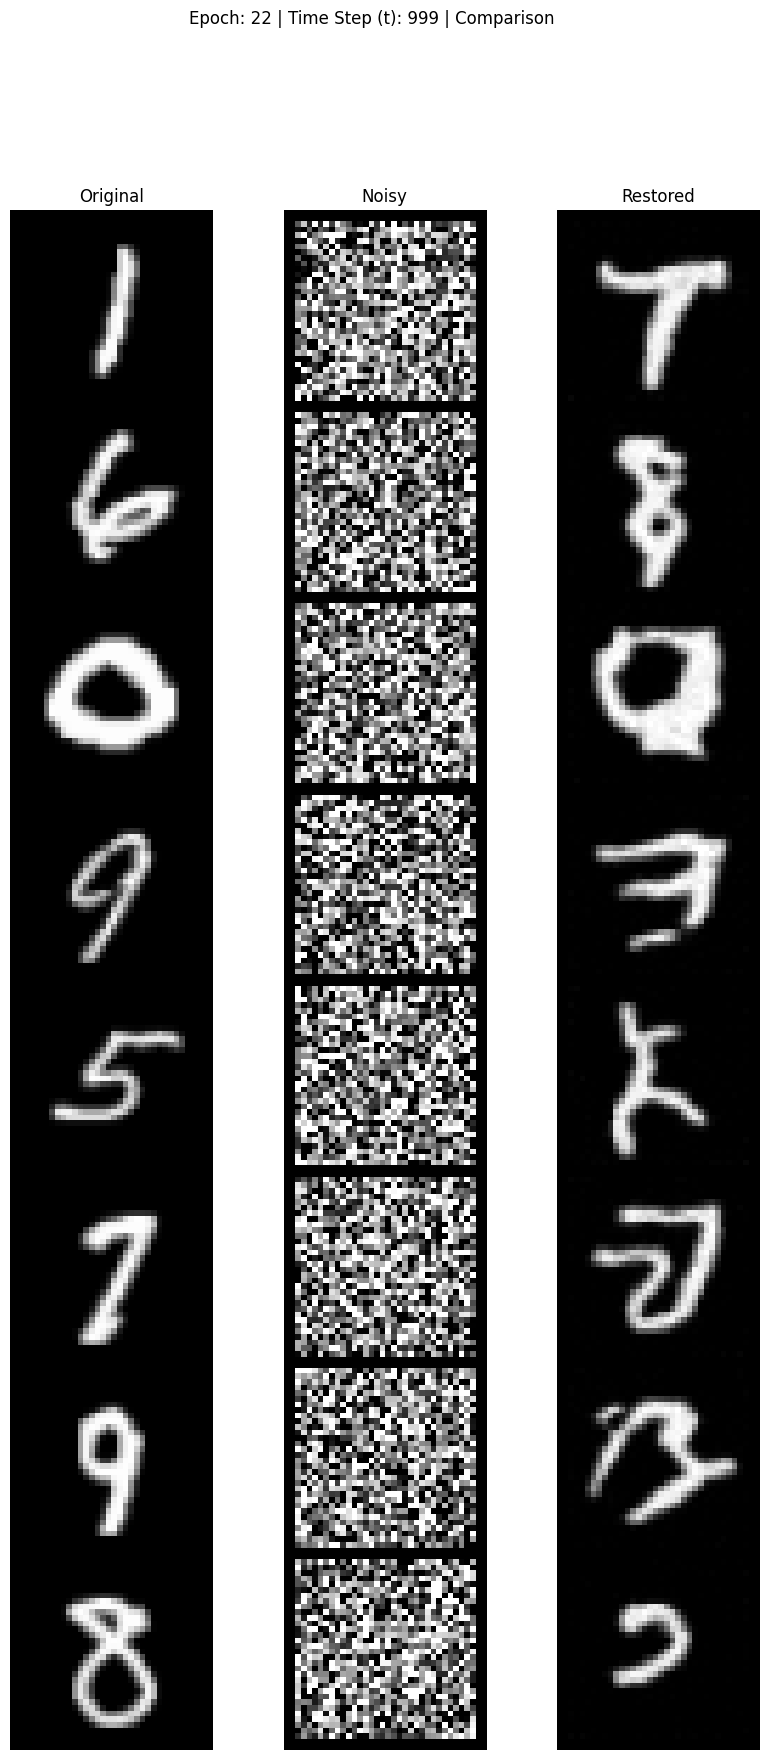

epoch:  23/50 	 iter :  50/469 	 loss: 0.021725
epoch:  23/50 	 iter : 100/469 	 loss: 0.022308
epoch:  23/50 	 iter : 150/469 	 loss: 0.022581
epoch:  23/50 	 iter : 200/469 	 loss: 0.022663
epoch:  23/50 	 iter : 250/469 	 loss: 0.022458
epoch:  23/50 	 iter : 300/469 	 loss: 0.022509
epoch:  23/50 	 iter : 350/469 	 loss: 0.022651
epoch:  23/50 	 iter : 400/469 	 loss: 0.022549
epoch:  23/50 	 iter : 450/469 	 loss: 0.022598
epoch:  23/50 	 total loss: 0.022589


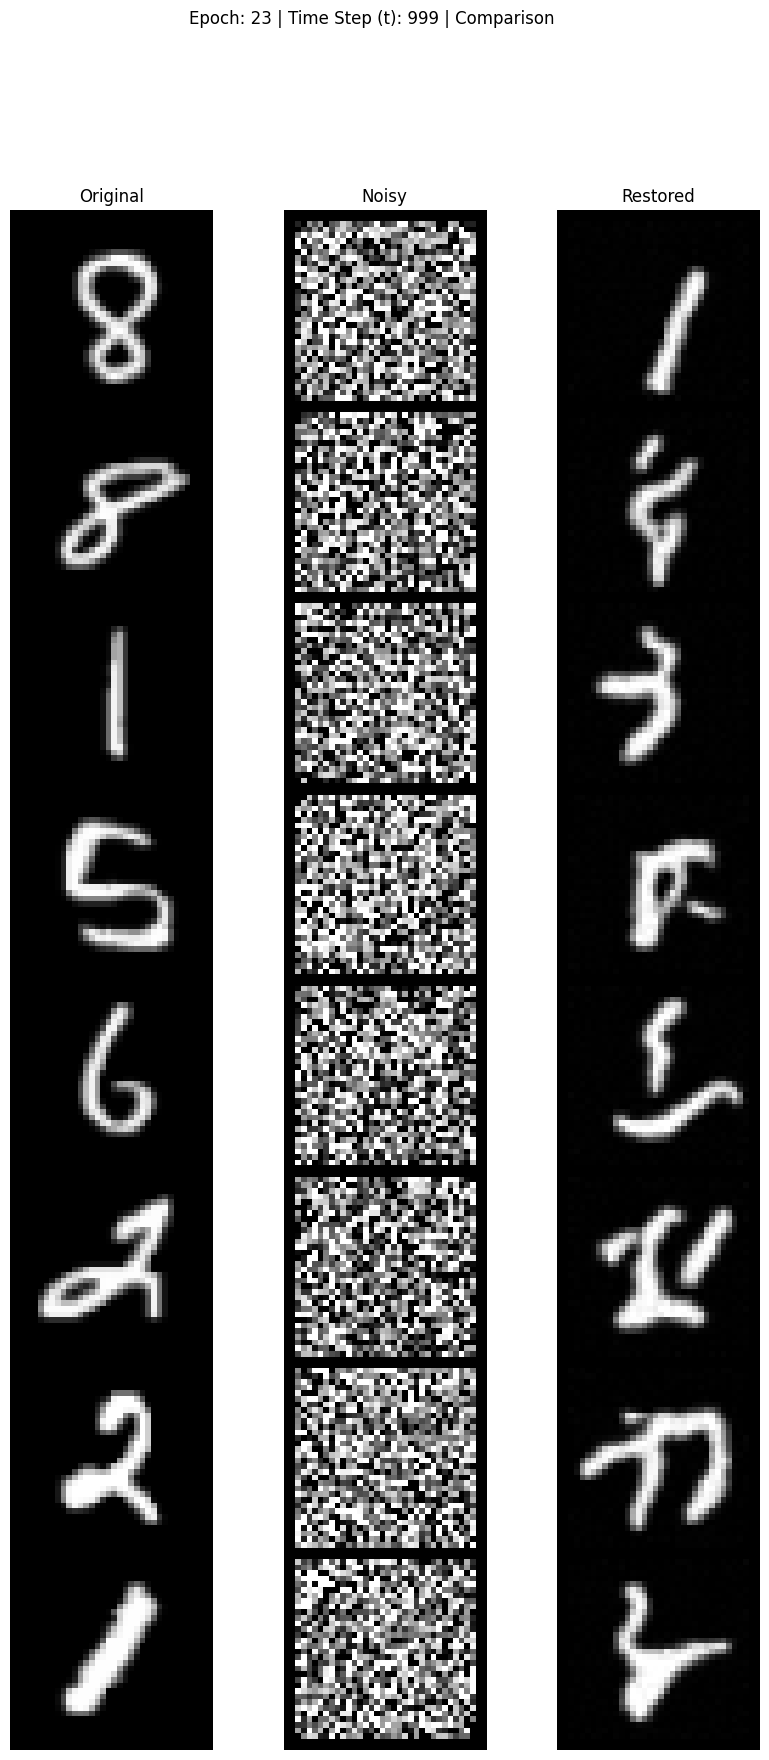

epoch:  24/50 	 iter :  50/469 	 loss: 0.021893
epoch:  24/50 	 iter : 100/469 	 loss: 0.022485
epoch:  24/50 	 iter : 150/469 	 loss: 0.022202
epoch:  24/50 	 iter : 200/469 	 loss: 0.022568
epoch:  24/50 	 iter : 250/469 	 loss: 0.022521
epoch:  24/50 	 iter : 300/469 	 loss: 0.022458
epoch:  24/50 	 iter : 350/469 	 loss: 0.022341
epoch:  24/50 	 iter : 400/469 	 loss: 0.022307
epoch:  24/50 	 iter : 450/469 	 loss: 0.022372
epoch:  24/50 	 total loss: 0.022386


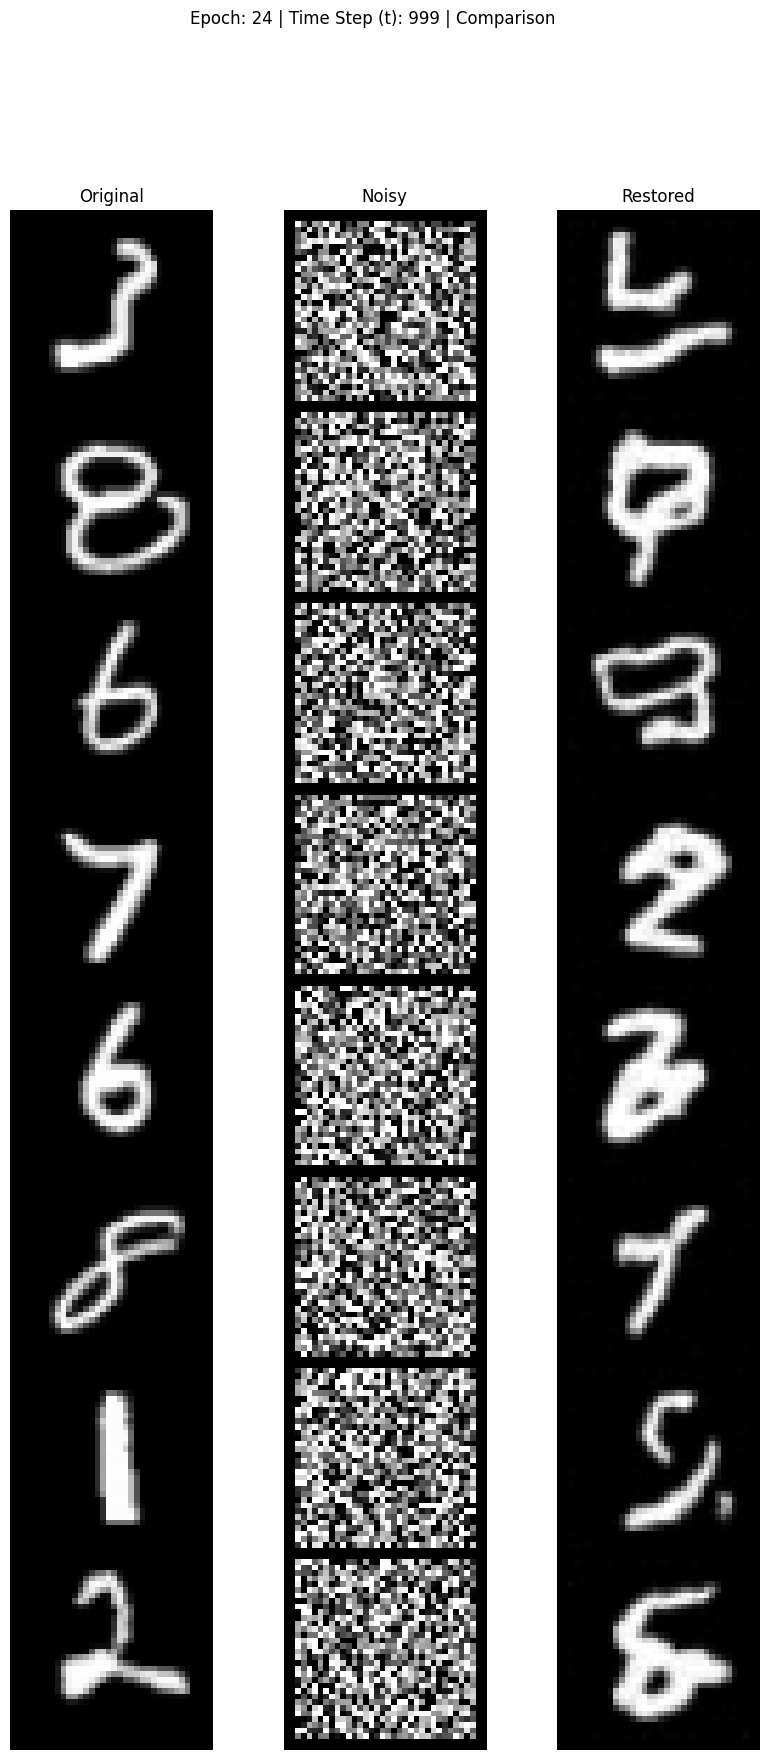

epoch:  25/50 	 iter :  50/469 	 loss: 0.021997
epoch:  25/50 	 iter : 100/469 	 loss: 0.021713
epoch:  25/50 	 iter : 150/469 	 loss: 0.021738
epoch:  25/50 	 iter : 200/469 	 loss: 0.021991
epoch:  25/50 	 iter : 250/469 	 loss: 0.021851
epoch:  25/50 	 iter : 300/469 	 loss: 0.021949
epoch:  25/50 	 iter : 350/469 	 loss: 0.021925
epoch:  25/50 	 iter : 400/469 	 loss: 0.021959
epoch:  25/50 	 iter : 450/469 	 loss: 0.022011
epoch:  25/50 	 total loss: 0.021930


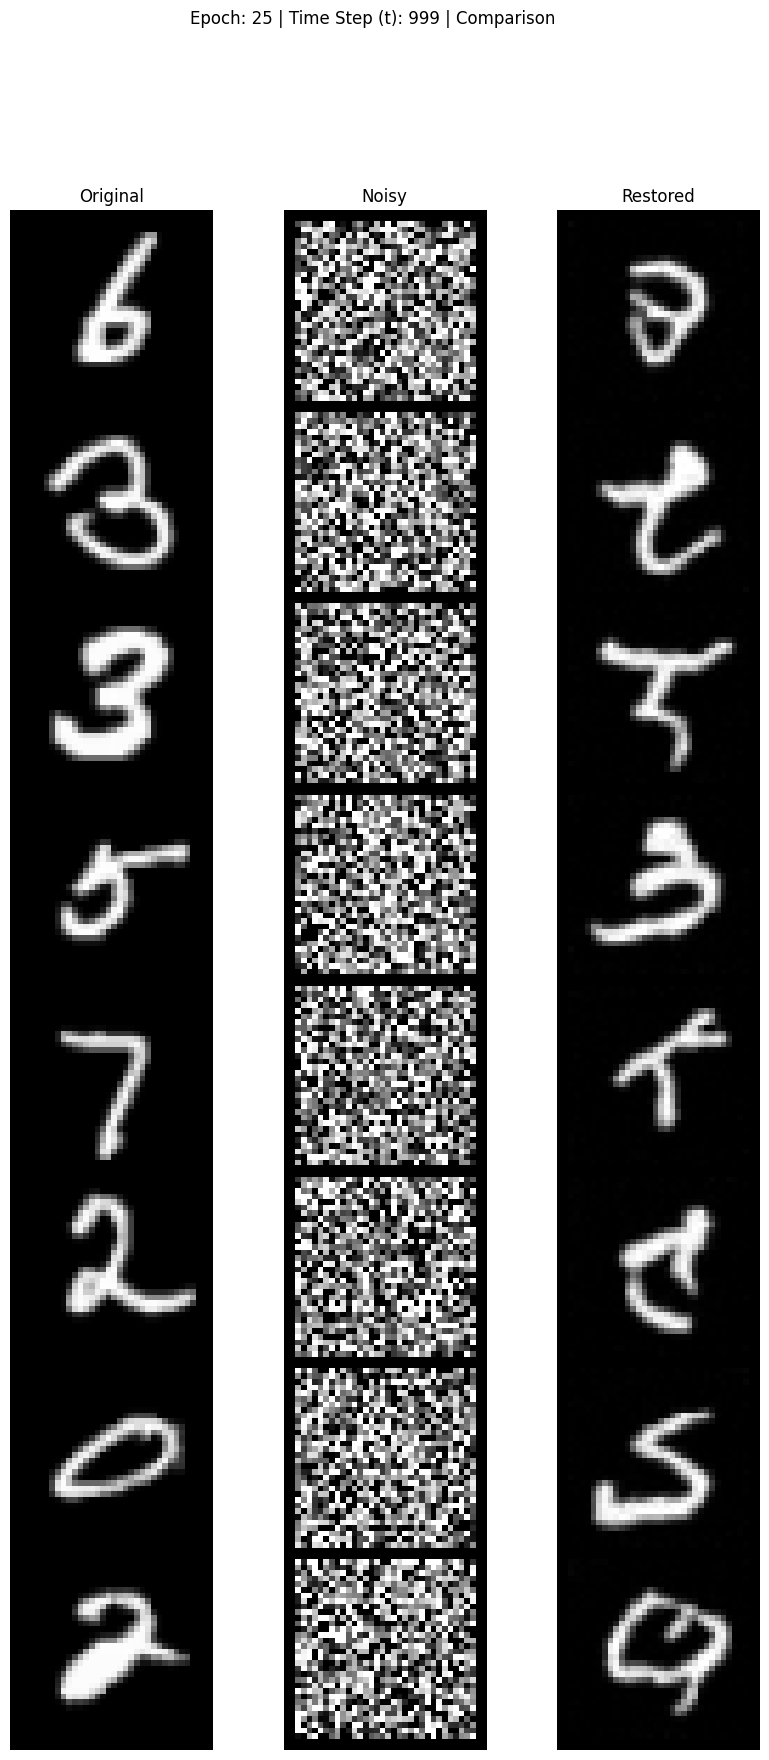

epoch:  26/50 	 iter :  50/469 	 loss: 0.021948
epoch:  26/50 	 iter : 100/469 	 loss: 0.022115
epoch:  26/50 	 iter : 150/469 	 loss: 0.022063
epoch:  26/50 	 iter : 200/469 	 loss: 0.021963
epoch:  26/50 	 iter : 250/469 	 loss: 0.022162
epoch:  26/50 	 iter : 300/469 	 loss: 0.022029
epoch:  26/50 	 iter : 350/469 	 loss: 0.021996
epoch:  26/50 	 iter : 400/469 	 loss: 0.021958
epoch:  26/50 	 iter : 450/469 	 loss: 0.021877
epoch:  26/50 	 total loss: 0.021868


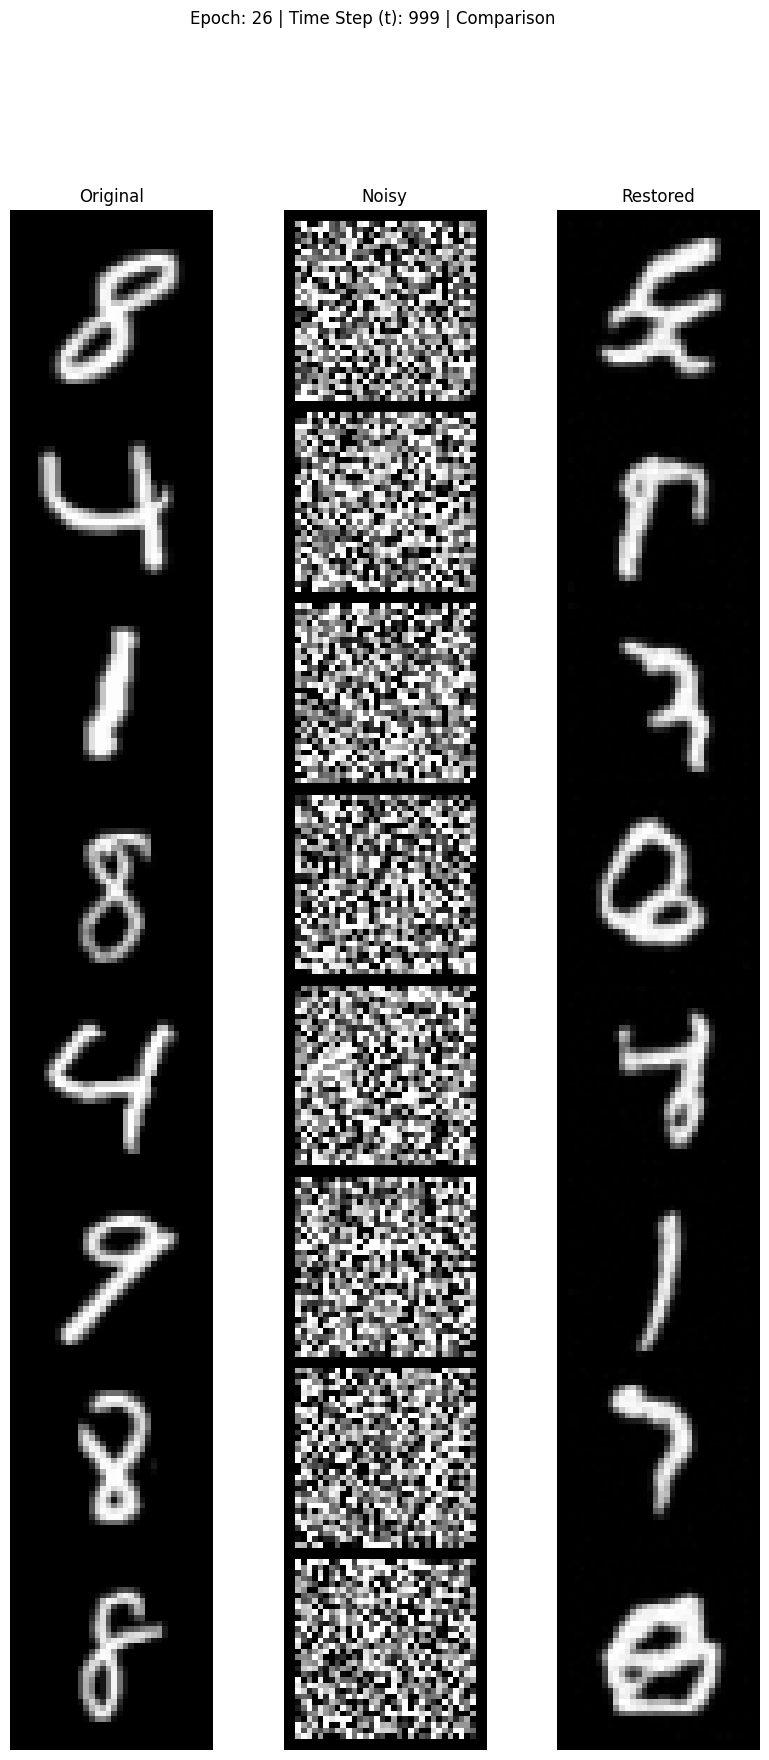

epoch:  27/50 	 iter :  50/469 	 loss: 0.021810
epoch:  27/50 	 iter : 100/469 	 loss: 0.021687
epoch:  27/50 	 iter : 150/469 	 loss: 0.021647
epoch:  27/50 	 iter : 200/469 	 loss: 0.021661
epoch:  27/50 	 iter : 250/469 	 loss: 0.021675
epoch:  27/50 	 iter : 300/469 	 loss: 0.021723
epoch:  27/50 	 iter : 350/469 	 loss: 0.021686
epoch:  27/50 	 iter : 400/469 	 loss: 0.021762
epoch:  27/50 	 iter : 450/469 	 loss: 0.021752
epoch:  27/50 	 total loss: 0.021701


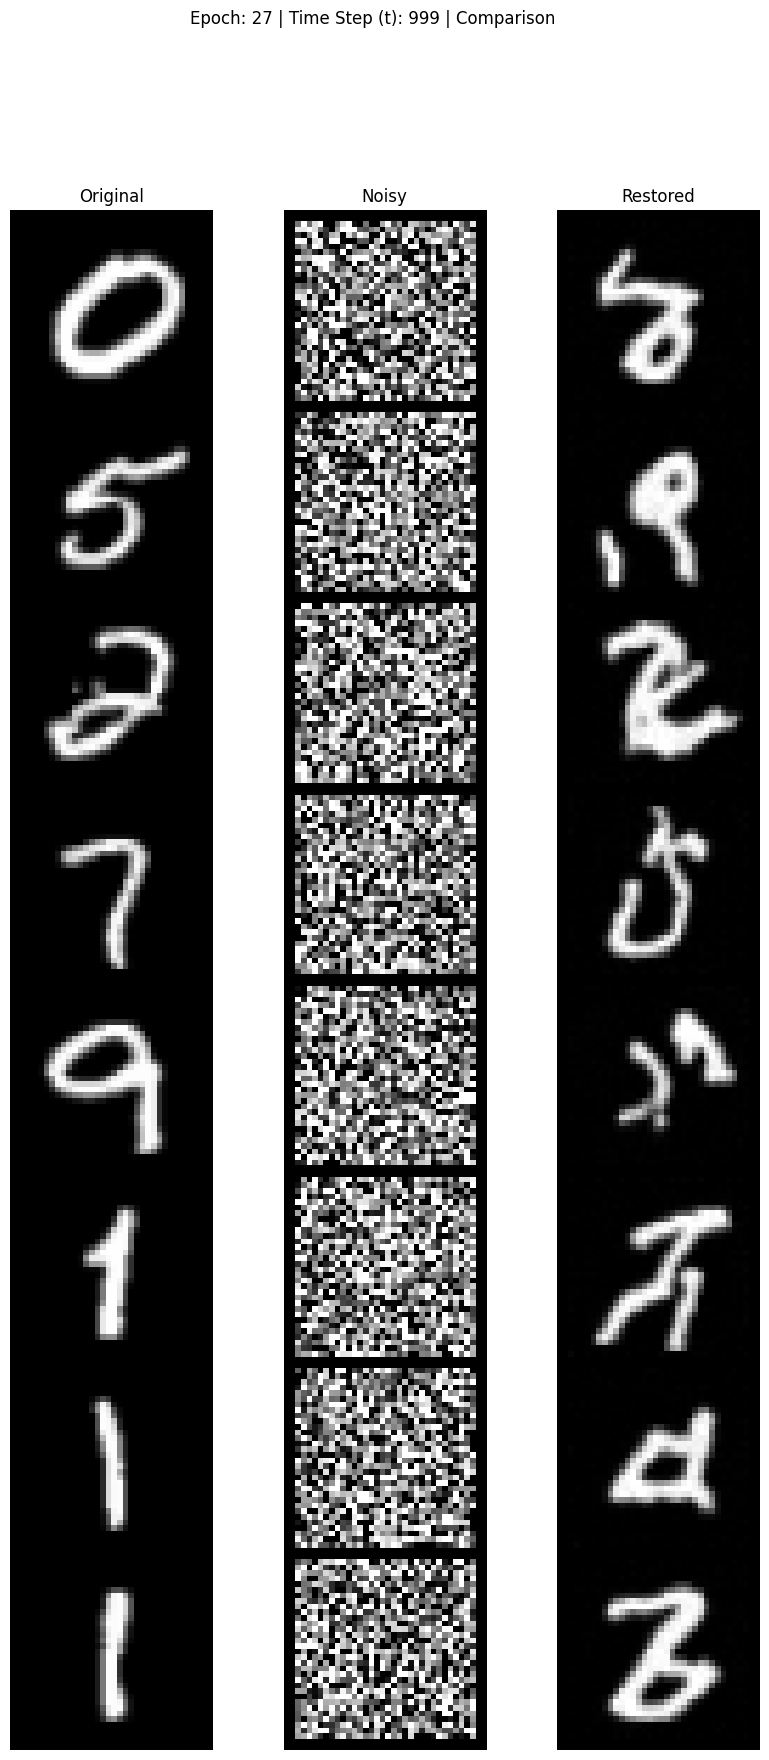

epoch:  28/50 	 iter :  50/469 	 loss: 0.021662
epoch:  28/50 	 iter : 100/469 	 loss: 0.021416
epoch:  28/50 	 iter : 150/469 	 loss: 0.021428
epoch:  28/50 	 iter : 200/469 	 loss: 0.021351
epoch:  28/50 	 iter : 250/469 	 loss: 0.021389
epoch:  28/50 	 iter : 300/469 	 loss: 0.021481
epoch:  28/50 	 iter : 350/469 	 loss: 0.021549
epoch:  28/50 	 iter : 400/469 	 loss: 0.021585
epoch:  28/50 	 iter : 450/469 	 loss: 0.021635
epoch:  28/50 	 total loss: 0.021578


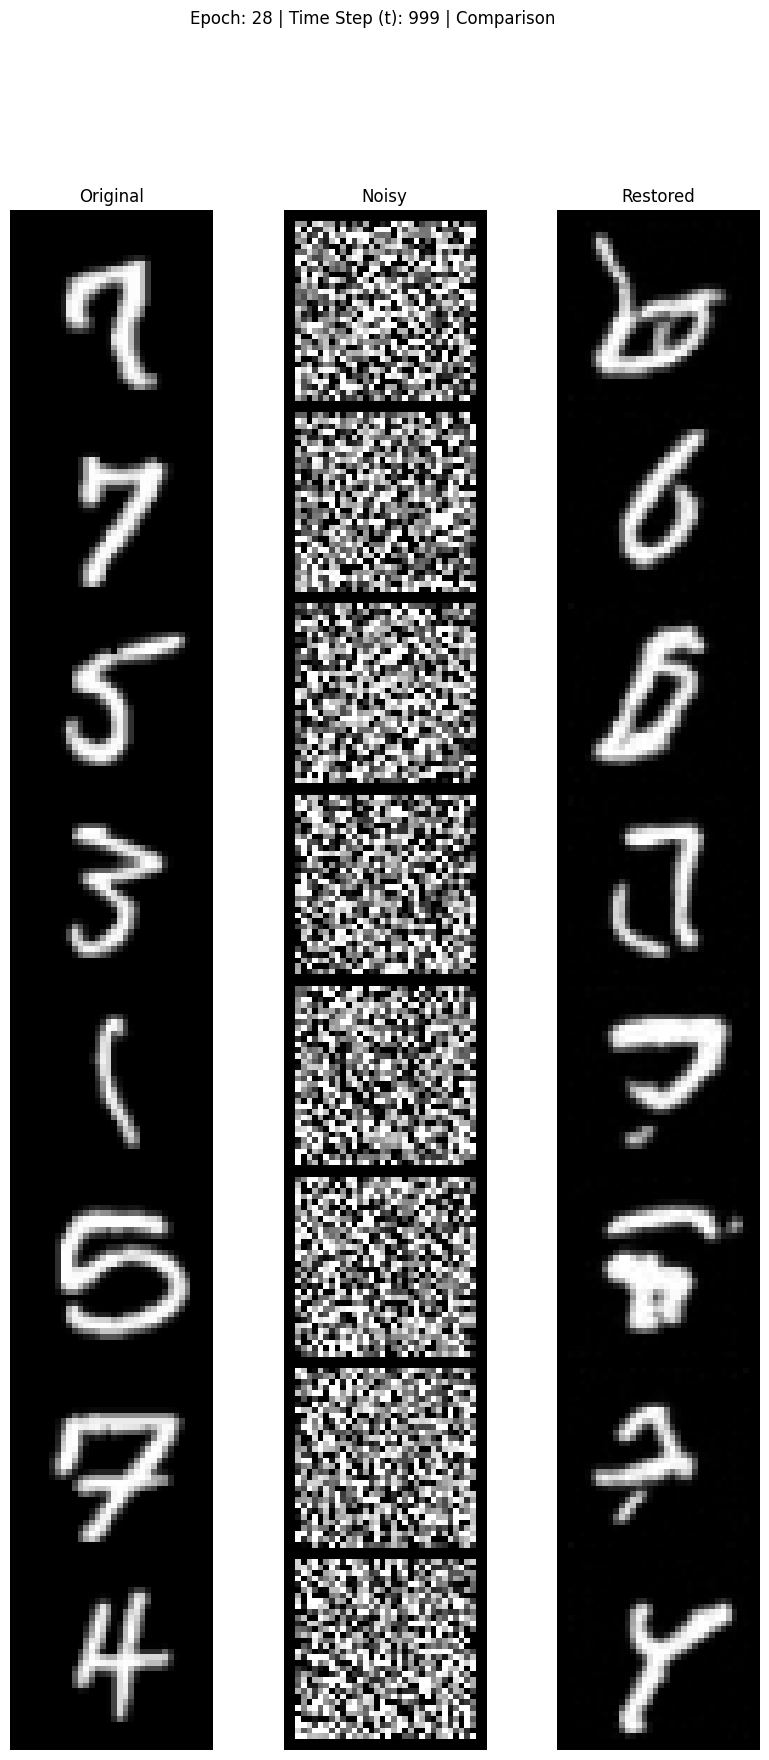

epoch:  29/50 	 iter :  50/469 	 loss: 0.020908
epoch:  29/50 	 iter : 100/469 	 loss: 0.021627
epoch:  29/50 	 iter : 150/469 	 loss: 0.021622
epoch:  29/50 	 iter : 200/469 	 loss: 0.021647
epoch:  29/50 	 iter : 250/469 	 loss: 0.021667
epoch:  29/50 	 iter : 300/469 	 loss: 0.021658
epoch:  29/50 	 iter : 350/469 	 loss: 0.021627
epoch:  29/50 	 iter : 400/469 	 loss: 0.021627
epoch:  29/50 	 iter : 450/469 	 loss: 0.021647
epoch:  29/50 	 total loss: 0.021627


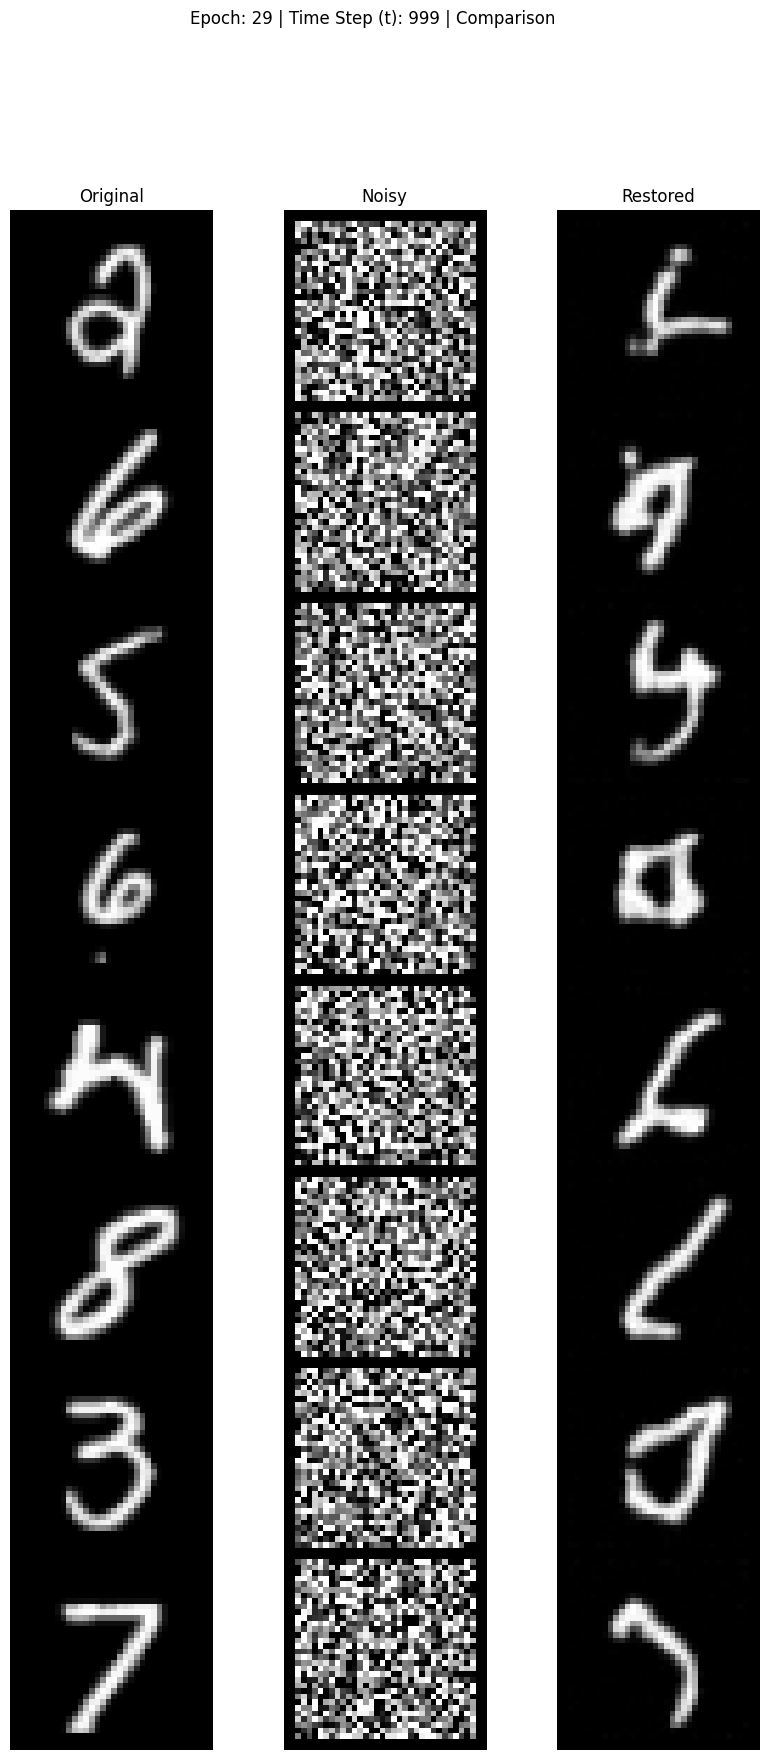

epoch:  30/50 	 iter :  50/469 	 loss: 0.022377
epoch:  30/50 	 iter : 100/469 	 loss: 0.021747
epoch:  30/50 	 iter : 150/469 	 loss: 0.021592
epoch:  30/50 	 iter : 200/469 	 loss: 0.021496
epoch:  30/50 	 iter : 250/469 	 loss: 0.021624
epoch:  30/50 	 iter : 300/469 	 loss: 0.021628
epoch:  30/50 	 iter : 350/469 	 loss: 0.021491
epoch:  30/50 	 iter : 400/469 	 loss: 0.021523
epoch:  30/50 	 iter : 450/469 	 loss: 0.021587
epoch:  30/50 	 total loss: 0.021537


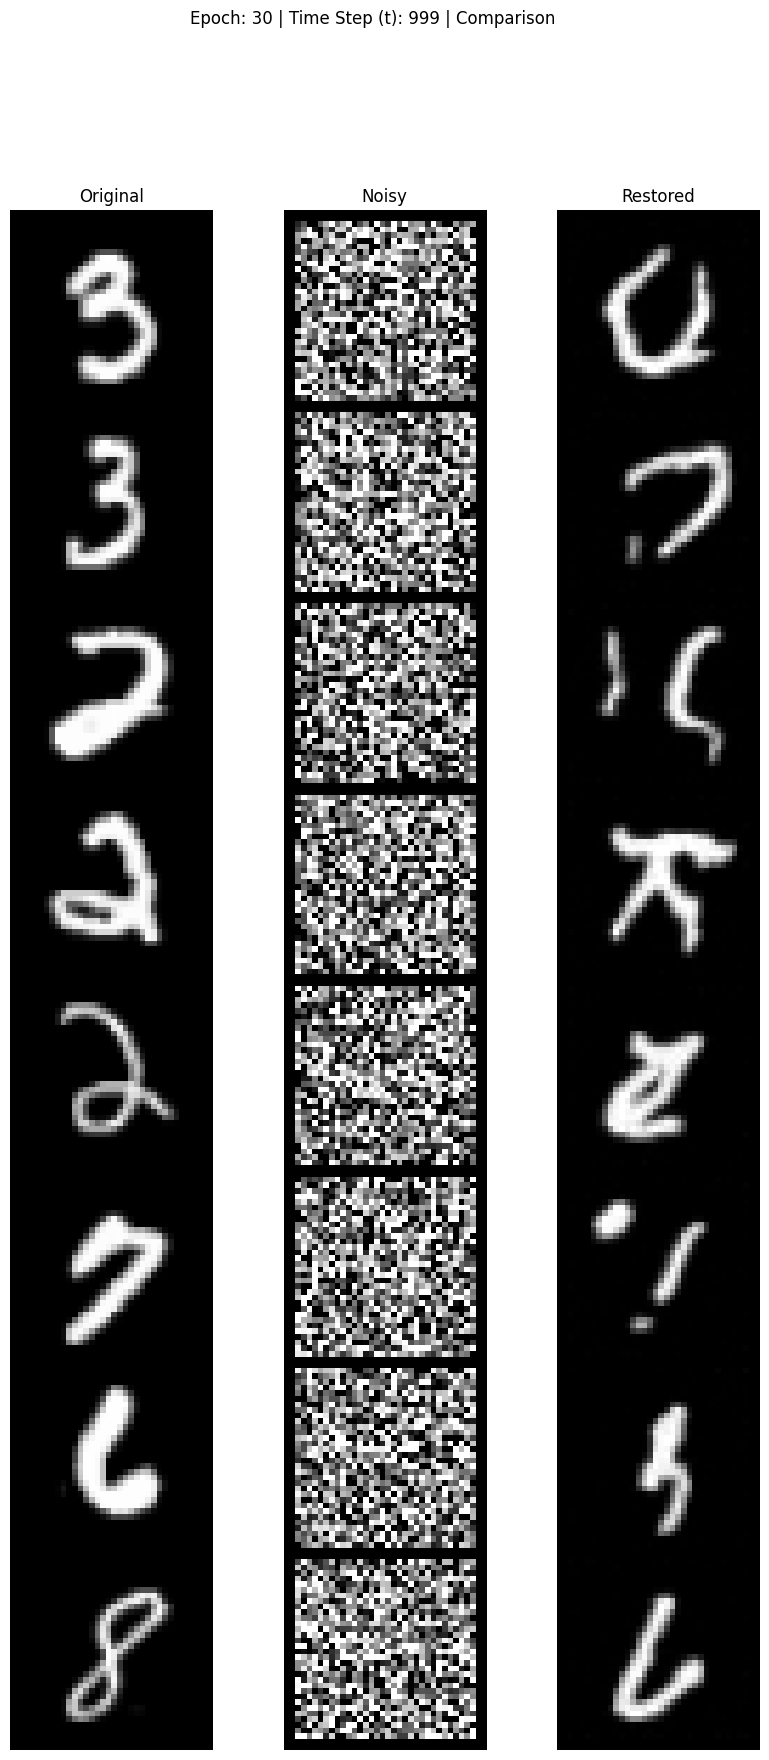

epoch:  31/50 	 iter :  50/469 	 loss: 0.021211
epoch:  31/50 	 iter : 100/469 	 loss: 0.021566
epoch:  31/50 	 iter : 150/469 	 loss: 0.021598
epoch:  31/50 	 iter : 200/469 	 loss: 0.021419
epoch:  31/50 	 iter : 250/469 	 loss: 0.021227
epoch:  31/50 	 iter : 300/469 	 loss: 0.021314
epoch:  31/50 	 iter : 350/469 	 loss: 0.021231
epoch:  31/50 	 iter : 400/469 	 loss: 0.021214
epoch:  31/50 	 iter : 450/469 	 loss: 0.021207
epoch:  31/50 	 total loss: 0.021207


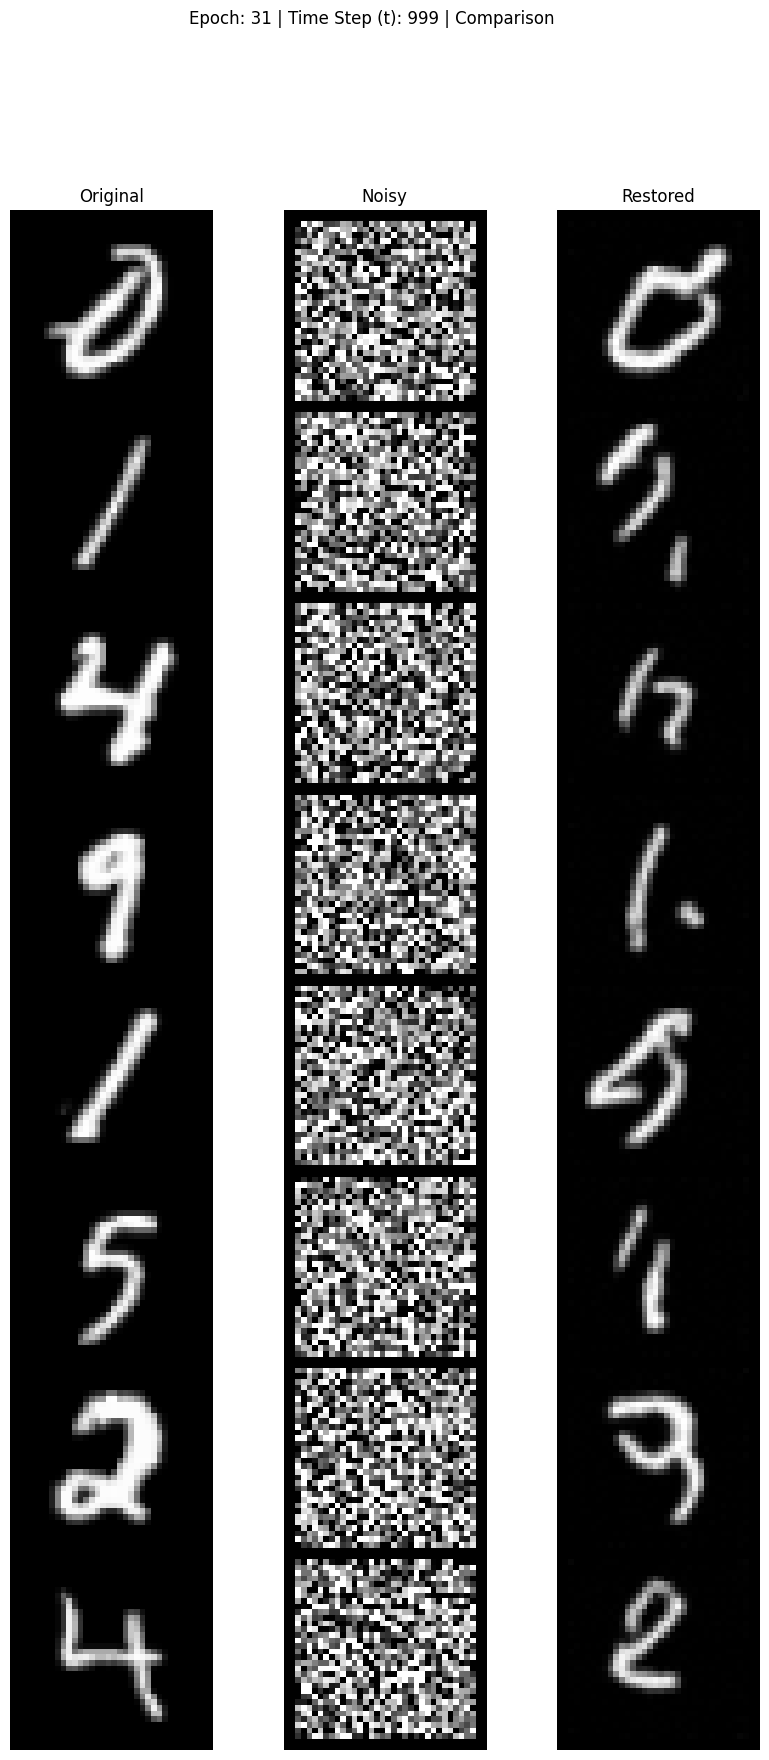

epoch:  32/50 	 iter :  50/469 	 loss: 0.020901
epoch:  32/50 	 iter : 100/469 	 loss: 0.021092
epoch:  32/50 	 iter : 150/469 	 loss: 0.021534
epoch:  32/50 	 iter : 200/469 	 loss: 0.021632
epoch:  32/50 	 iter : 250/469 	 loss: 0.021815
epoch:  32/50 	 iter : 300/469 	 loss: 0.021800
epoch:  32/50 	 iter : 350/469 	 loss: 0.021701
epoch:  32/50 	 iter : 400/469 	 loss: 0.021730
epoch:  32/50 	 iter : 450/469 	 loss: 0.021663
epoch:  32/50 	 total loss: 0.021678


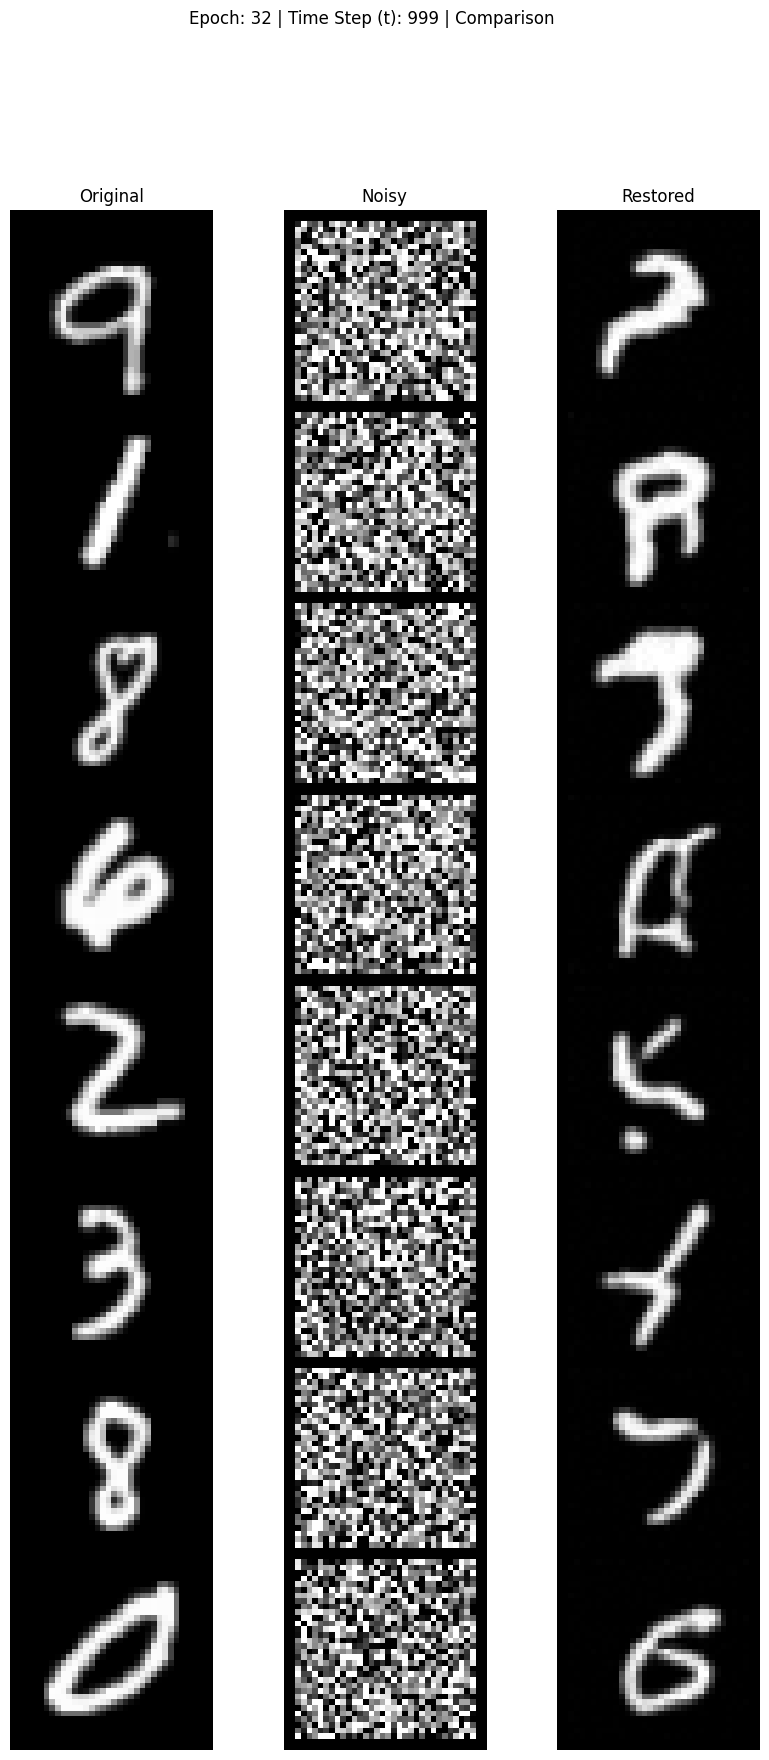

epoch:  33/50 	 iter :  50/469 	 loss: 0.021048
epoch:  33/50 	 iter : 100/469 	 loss: 0.021493
epoch:  33/50 	 iter : 150/469 	 loss: 0.021268
epoch:  33/50 	 iter : 200/469 	 loss: 0.021228
epoch:  33/50 	 iter : 250/469 	 loss: 0.021294
epoch:  33/50 	 iter : 300/469 	 loss: 0.021329
epoch:  33/50 	 iter : 350/469 	 loss: 0.021325
epoch:  33/50 	 iter : 400/469 	 loss: 0.021257
epoch:  33/50 	 iter : 450/469 	 loss: 0.021182
epoch:  33/50 	 total loss: 0.021138


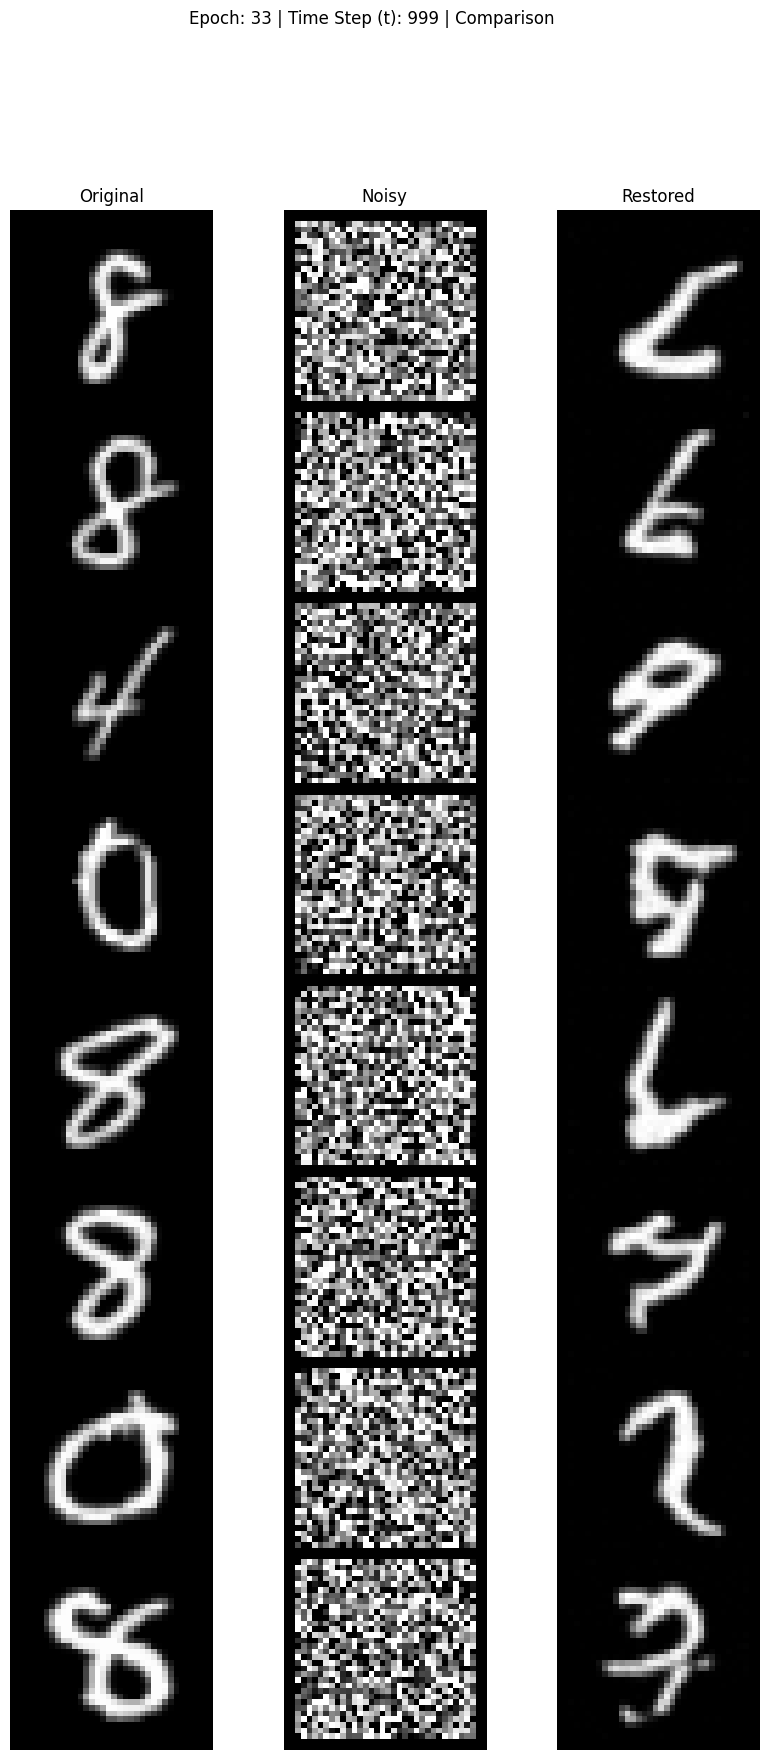

epoch:  34/50 	 iter :  50/469 	 loss: 0.020759
epoch:  34/50 	 iter : 100/469 	 loss: 0.020818
epoch:  34/50 	 iter : 150/469 	 loss: 0.020803
epoch:  34/50 	 iter : 200/469 	 loss: 0.020694
epoch:  34/50 	 iter : 250/469 	 loss: 0.020831
epoch:  34/50 	 iter : 300/469 	 loss: 0.020912
epoch:  34/50 	 iter : 350/469 	 loss: 0.020906
epoch:  34/50 	 iter : 400/469 	 loss: 0.020800
epoch:  34/50 	 iter : 450/469 	 loss: 0.020879
epoch:  34/50 	 total loss: 0.020933


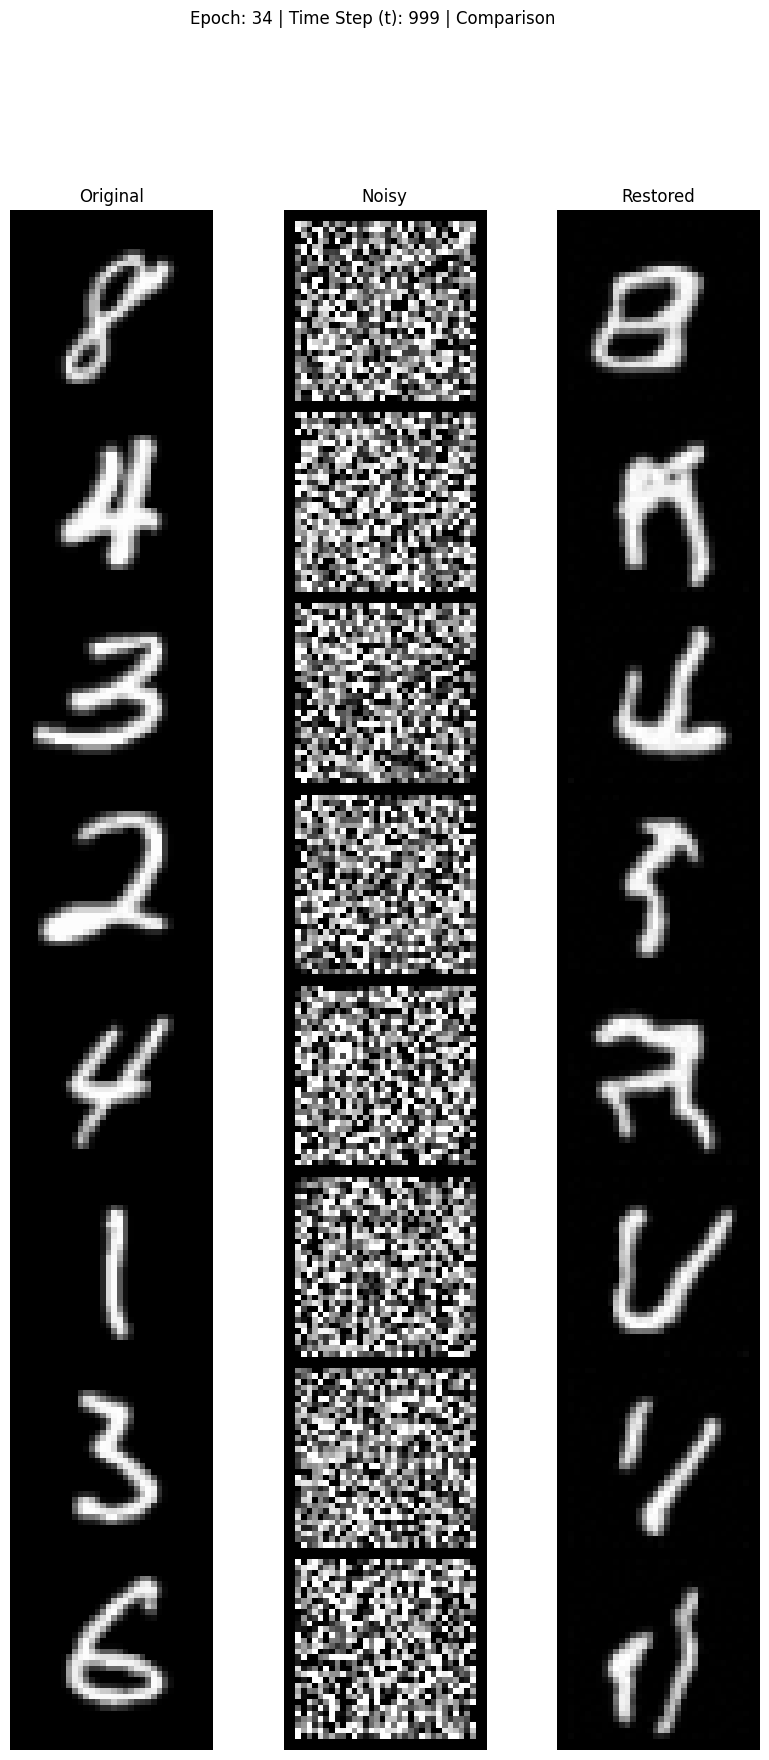

epoch:  35/50 	 iter :  50/469 	 loss: 0.022034
epoch:  35/50 	 iter : 100/469 	 loss: 0.021280
epoch:  35/50 	 iter : 150/469 	 loss: 0.021341
epoch:  35/50 	 iter : 200/469 	 loss: 0.021126
epoch:  35/50 	 iter : 250/469 	 loss: 0.021093
epoch:  35/50 	 iter : 300/469 	 loss: 0.021094
epoch:  35/50 	 iter : 350/469 	 loss: 0.021054
epoch:  35/50 	 iter : 400/469 	 loss: 0.020983
epoch:  35/50 	 iter : 450/469 	 loss: 0.020968
epoch:  35/50 	 total loss: 0.020993


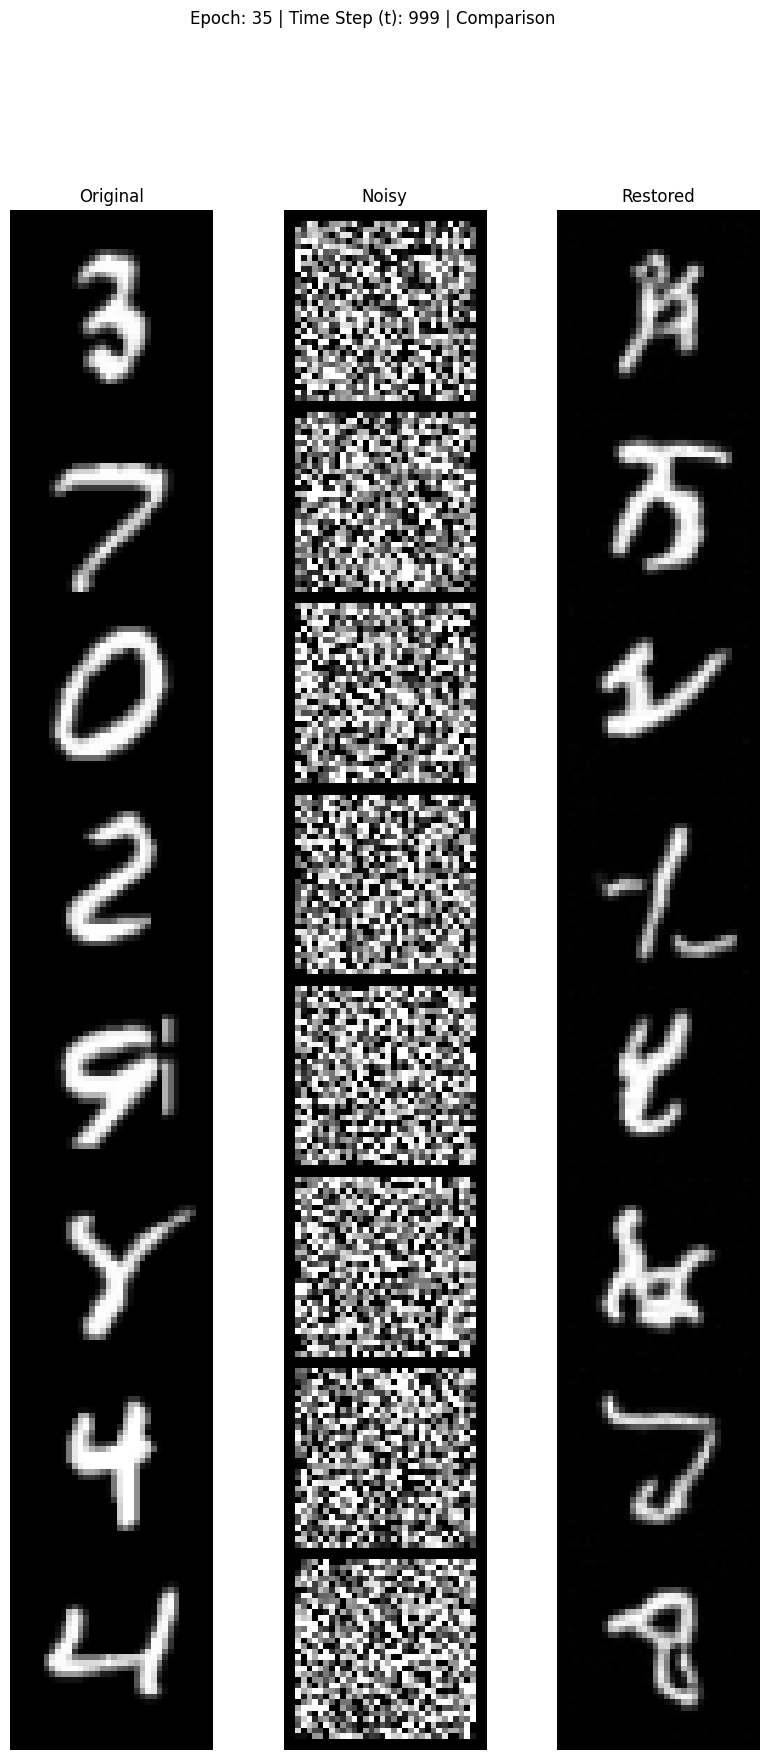

epoch:  36/50 	 iter :  50/469 	 loss: 0.021026
epoch:  36/50 	 iter : 100/469 	 loss: 0.021204
epoch:  36/50 	 iter : 150/469 	 loss: 0.021185
epoch:  36/50 	 iter : 200/469 	 loss: 0.021270
epoch:  36/50 	 iter : 250/469 	 loss: 0.021112
epoch:  36/50 	 iter : 300/469 	 loss: 0.021084
epoch:  36/50 	 iter : 350/469 	 loss: 0.021048
epoch:  36/50 	 iter : 400/469 	 loss: 0.021083
epoch:  36/50 	 iter : 450/469 	 loss: 0.020981
epoch:  36/50 	 total loss: 0.020985


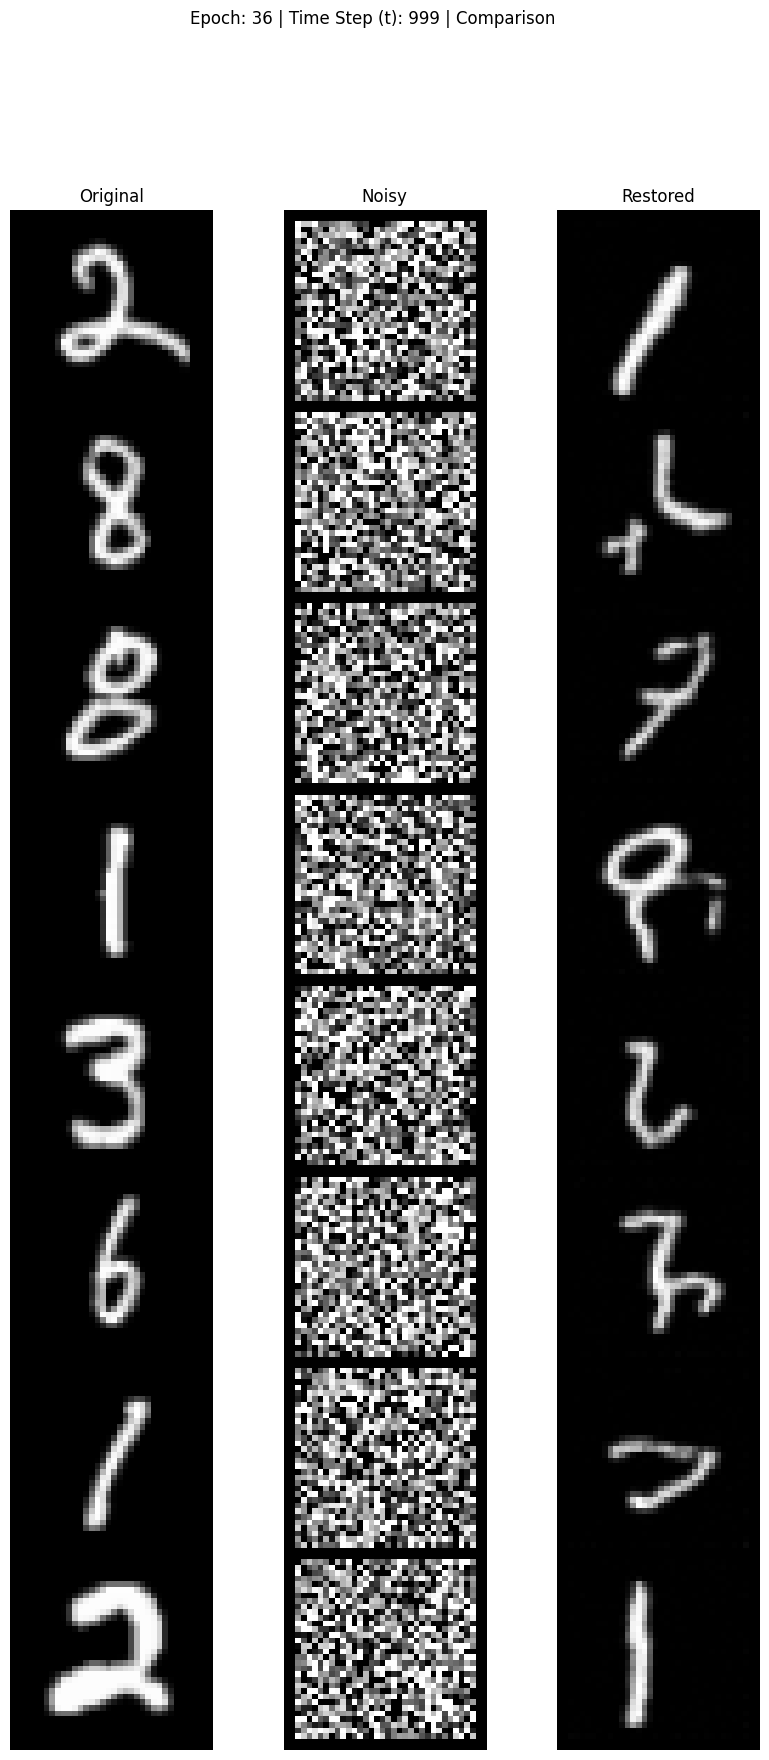

epoch:  37/50 	 iter :  50/469 	 loss: 0.020494
epoch:  37/50 	 iter : 100/469 	 loss: 0.020527
epoch:  37/50 	 iter : 150/469 	 loss: 0.020565
epoch:  37/50 	 iter : 200/469 	 loss: 0.020496
epoch:  37/50 	 iter : 250/469 	 loss: 0.020629
epoch:  37/50 	 iter : 300/469 	 loss: 0.020692
epoch:  37/50 	 iter : 350/469 	 loss: 0.020796
epoch:  37/50 	 iter : 400/469 	 loss: 0.020804
epoch:  37/50 	 iter : 450/469 	 loss: 0.020836
epoch:  37/50 	 total loss: 0.020857


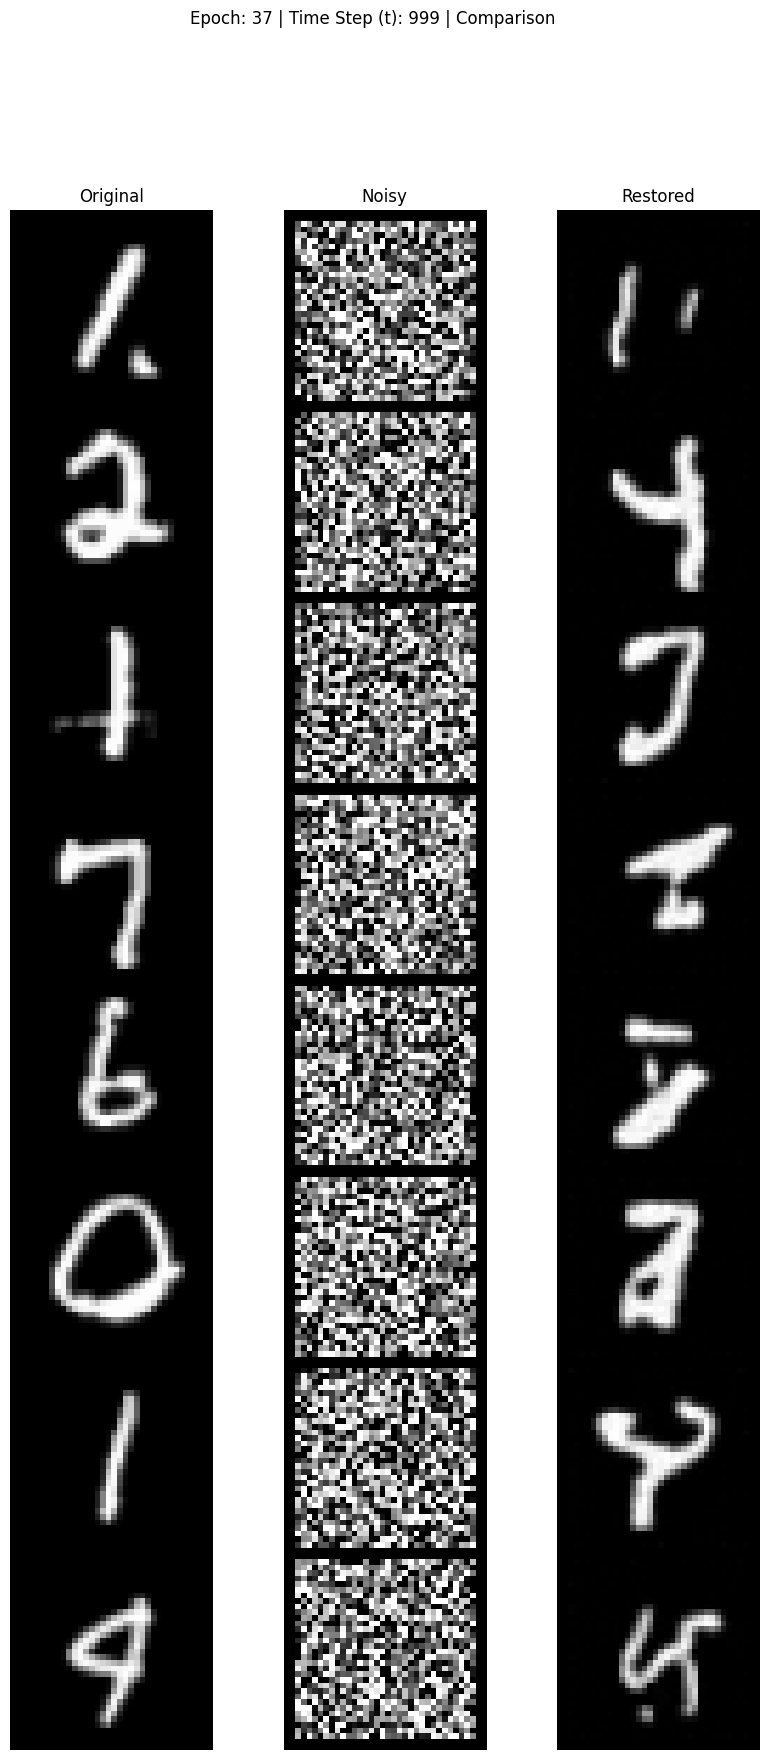

epoch:  38/50 	 iter :  50/469 	 loss: 0.020606
epoch:  38/50 	 iter : 100/469 	 loss: 0.020477
epoch:  38/50 	 iter : 150/469 	 loss: 0.020464
epoch:  38/50 	 iter : 200/469 	 loss: 0.020538
epoch:  38/50 	 iter : 250/469 	 loss: 0.020727
epoch:  38/50 	 iter : 300/469 	 loss: 0.020828
epoch:  38/50 	 iter : 350/469 	 loss: 0.020795
epoch:  38/50 	 iter : 400/469 	 loss: 0.020778
epoch:  38/50 	 iter : 450/469 	 loss: 0.020784
epoch:  38/50 	 total loss: 0.020788


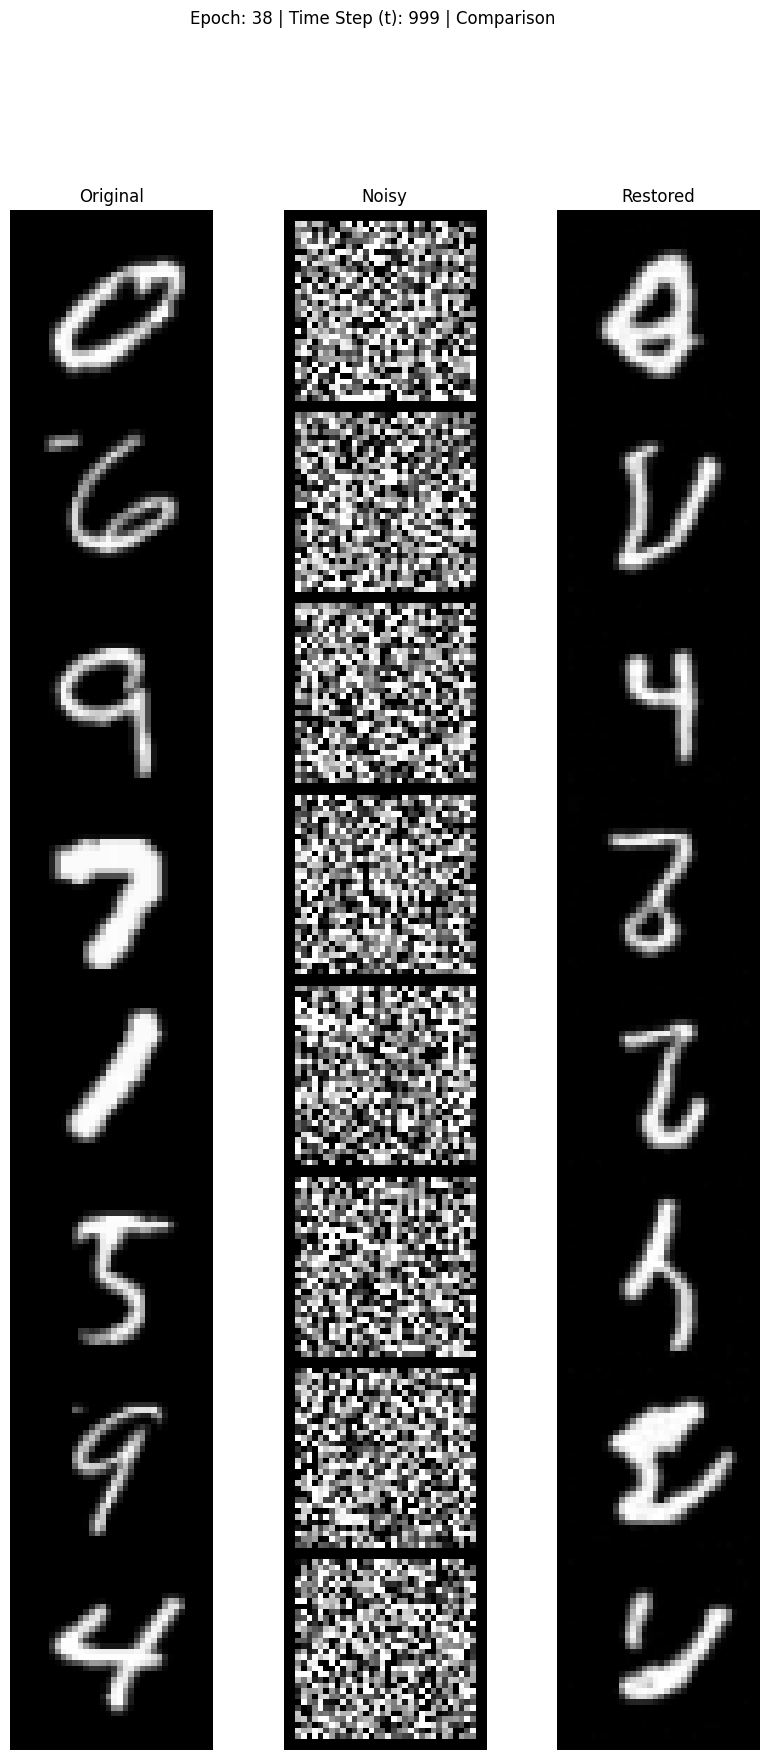

epoch:  39/50 	 iter :  50/469 	 loss: 0.020365
epoch:  39/50 	 iter : 100/469 	 loss: 0.020585
epoch:  39/50 	 iter : 150/469 	 loss: 0.020719
epoch:  39/50 	 iter : 200/469 	 loss: 0.020849
epoch:  39/50 	 iter : 250/469 	 loss: 0.020862
epoch:  39/50 	 iter : 300/469 	 loss: 0.020729
epoch:  39/50 	 iter : 350/469 	 loss: 0.020649
epoch:  39/50 	 iter : 400/469 	 loss: 0.020643
epoch:  39/50 	 iter : 450/469 	 loss: 0.020614
epoch:  39/50 	 total loss: 0.020591


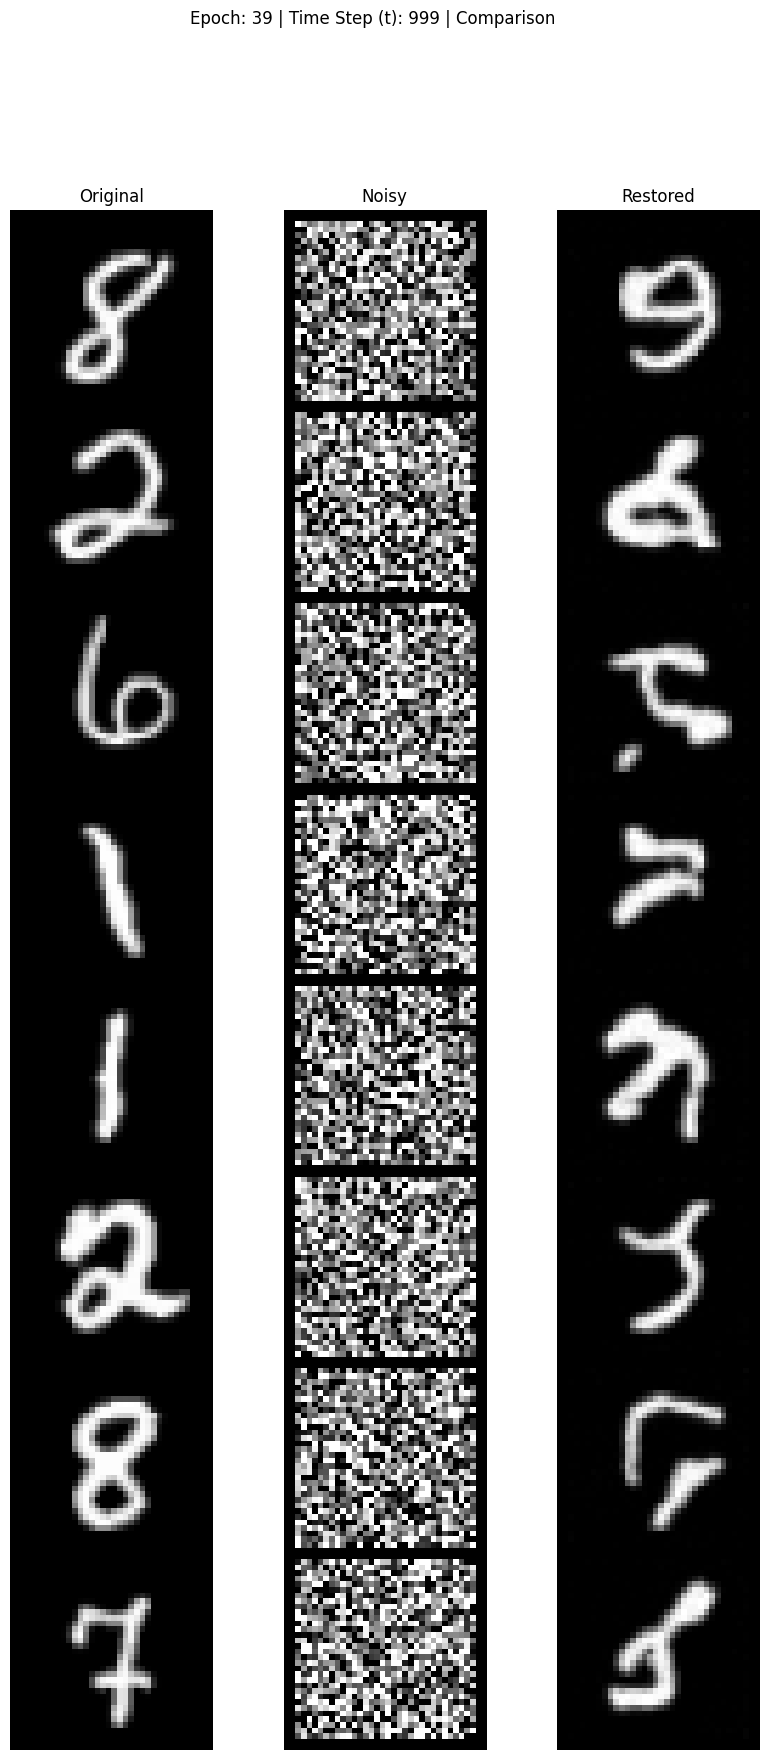

epoch:  40/50 	 iter :  50/469 	 loss: 0.021316
epoch:  40/50 	 iter : 100/469 	 loss: 0.021051
epoch:  40/50 	 iter : 150/469 	 loss: 0.020992
epoch:  40/50 	 iter : 200/469 	 loss: 0.020817
epoch:  40/50 	 iter : 250/469 	 loss: 0.020940
epoch:  40/50 	 iter : 300/469 	 loss: 0.020857
epoch:  40/50 	 iter : 350/469 	 loss: 0.020800
epoch:  40/50 	 iter : 400/469 	 loss: 0.020715
epoch:  40/50 	 iter : 450/469 	 loss: 0.020710
epoch:  40/50 	 total loss: 0.020741


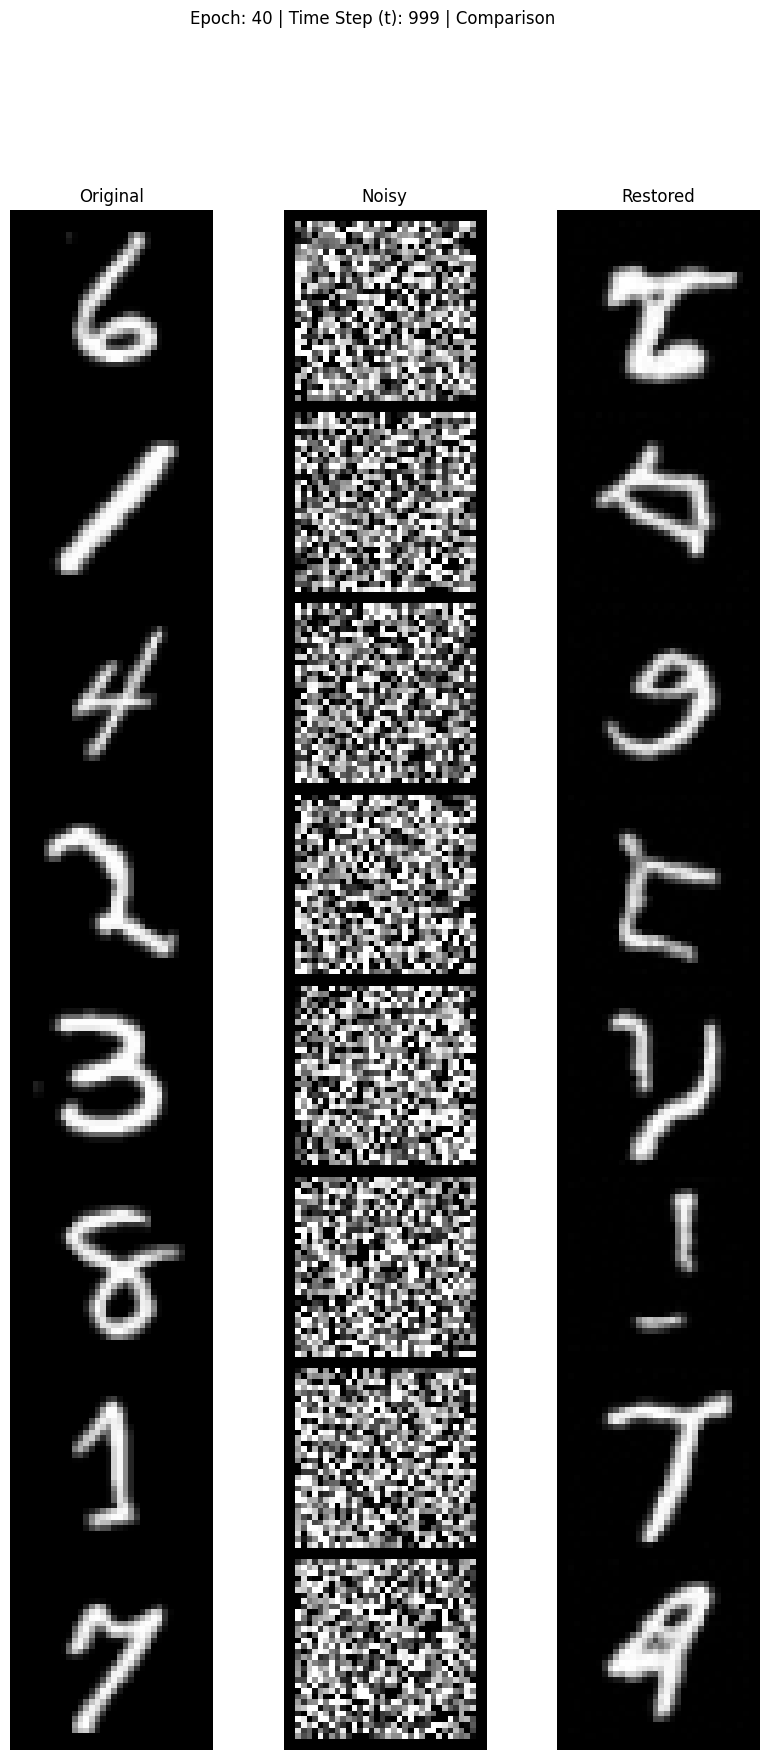

epoch:  41/50 	 iter :  50/469 	 loss: 0.020825
epoch:  41/50 	 iter : 100/469 	 loss: 0.020818
epoch:  41/50 	 iter : 150/469 	 loss: 0.020612
epoch:  41/50 	 iter : 200/469 	 loss: 0.020771
epoch:  41/50 	 iter : 250/469 	 loss: 0.020491
epoch:  41/50 	 iter : 300/469 	 loss: 0.020567
epoch:  41/50 	 iter : 350/469 	 loss: 0.020572
epoch:  41/50 	 iter : 400/469 	 loss: 0.020576
epoch:  41/50 	 iter : 450/469 	 loss: 0.020521
epoch:  41/50 	 total loss: 0.020530


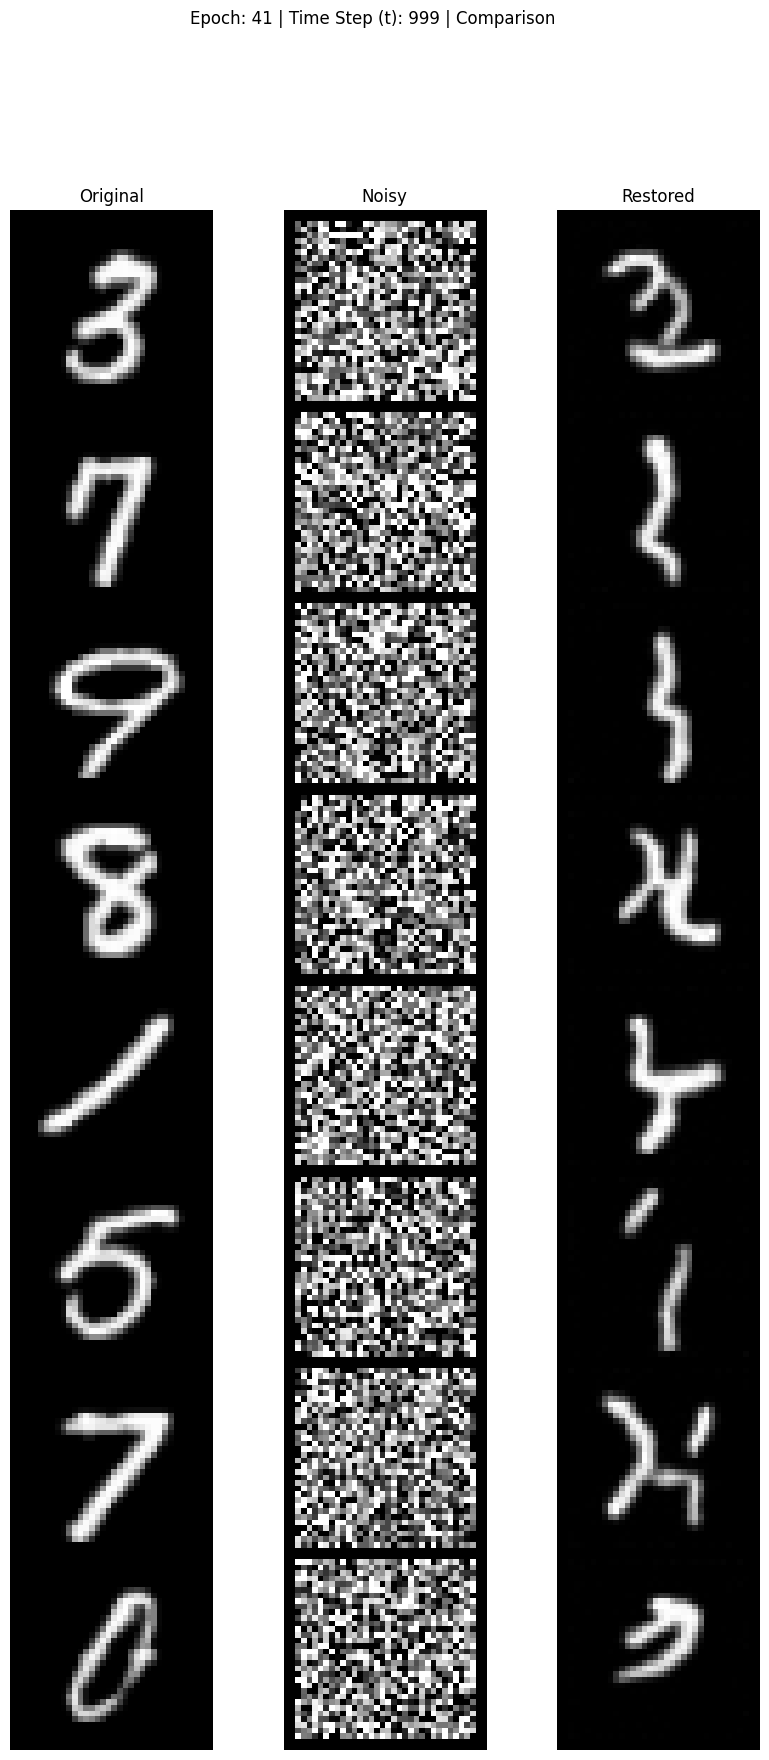

epoch:  42/50 	 iter :  50/469 	 loss: 0.020571
epoch:  42/50 	 iter : 100/469 	 loss: 0.020911
epoch:  42/50 	 iter : 150/469 	 loss: 0.020828
epoch:  42/50 	 iter : 200/469 	 loss: 0.021001
epoch:  42/50 	 iter : 250/469 	 loss: 0.020830
epoch:  42/50 	 iter : 300/469 	 loss: 0.020878
epoch:  42/50 	 iter : 350/469 	 loss: 0.020855
epoch:  42/50 	 iter : 400/469 	 loss: 0.020825
epoch:  42/50 	 iter : 450/469 	 loss: 0.020823
epoch:  42/50 	 total loss: 0.020822


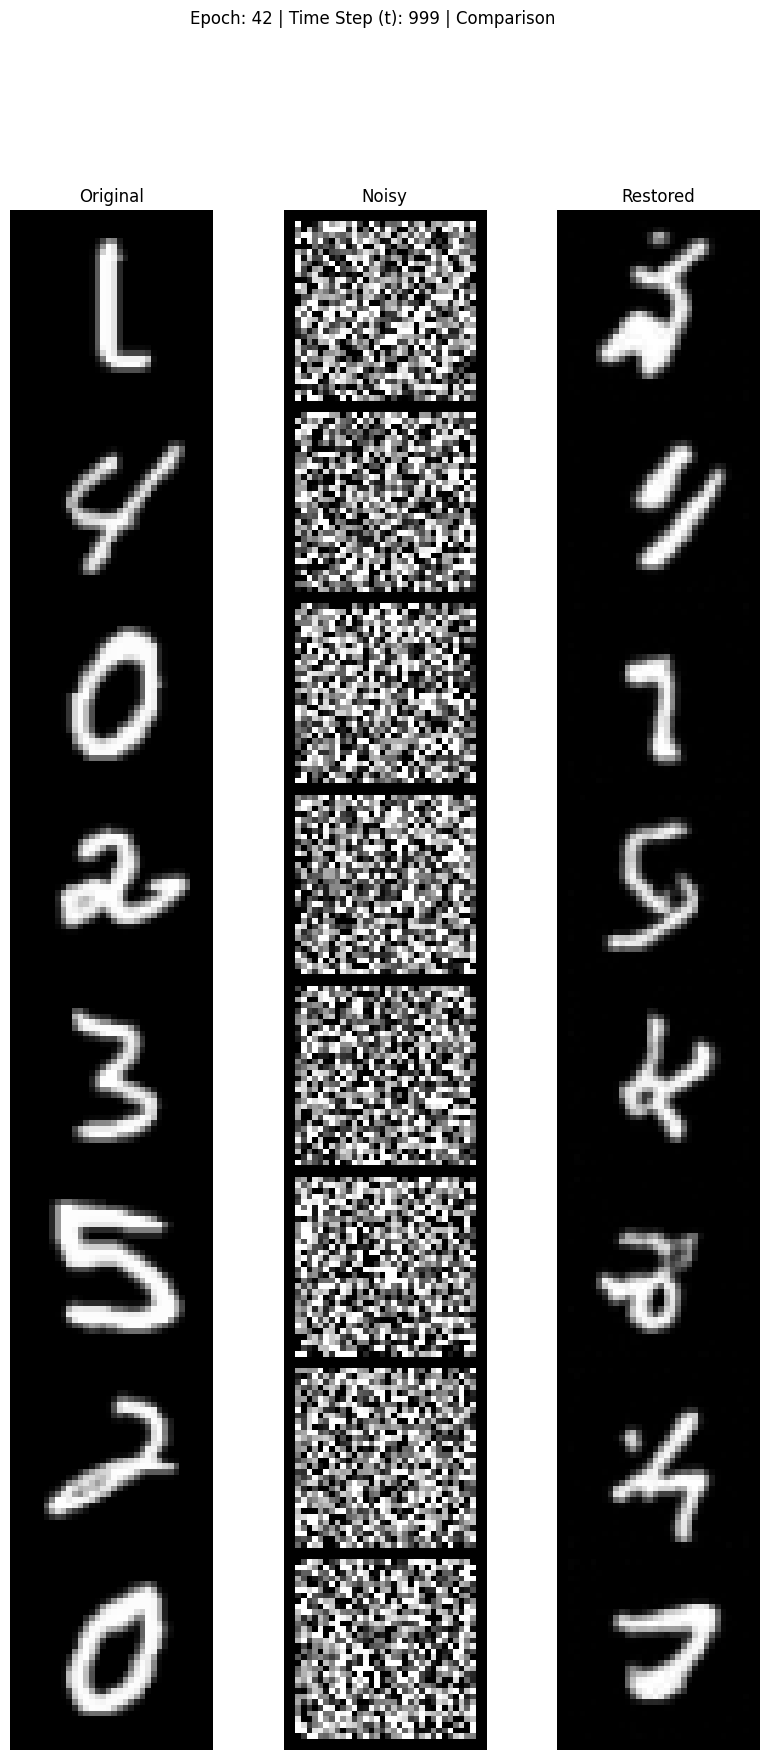

epoch:  43/50 	 iter :  50/469 	 loss: 0.019973
epoch:  43/50 	 iter : 100/469 	 loss: 0.019876
epoch:  43/50 	 iter : 150/469 	 loss: 0.020077
epoch:  43/50 	 iter : 200/469 	 loss: 0.020099
epoch:  43/50 	 iter : 250/469 	 loss: 0.020063
epoch:  43/50 	 iter : 300/469 	 loss: 0.020091
epoch:  43/50 	 iter : 350/469 	 loss: 0.020089
epoch:  43/50 	 iter : 400/469 	 loss: 0.020051
epoch:  43/50 	 iter : 450/469 	 loss: 0.020168
epoch:  43/50 	 total loss: 0.020186


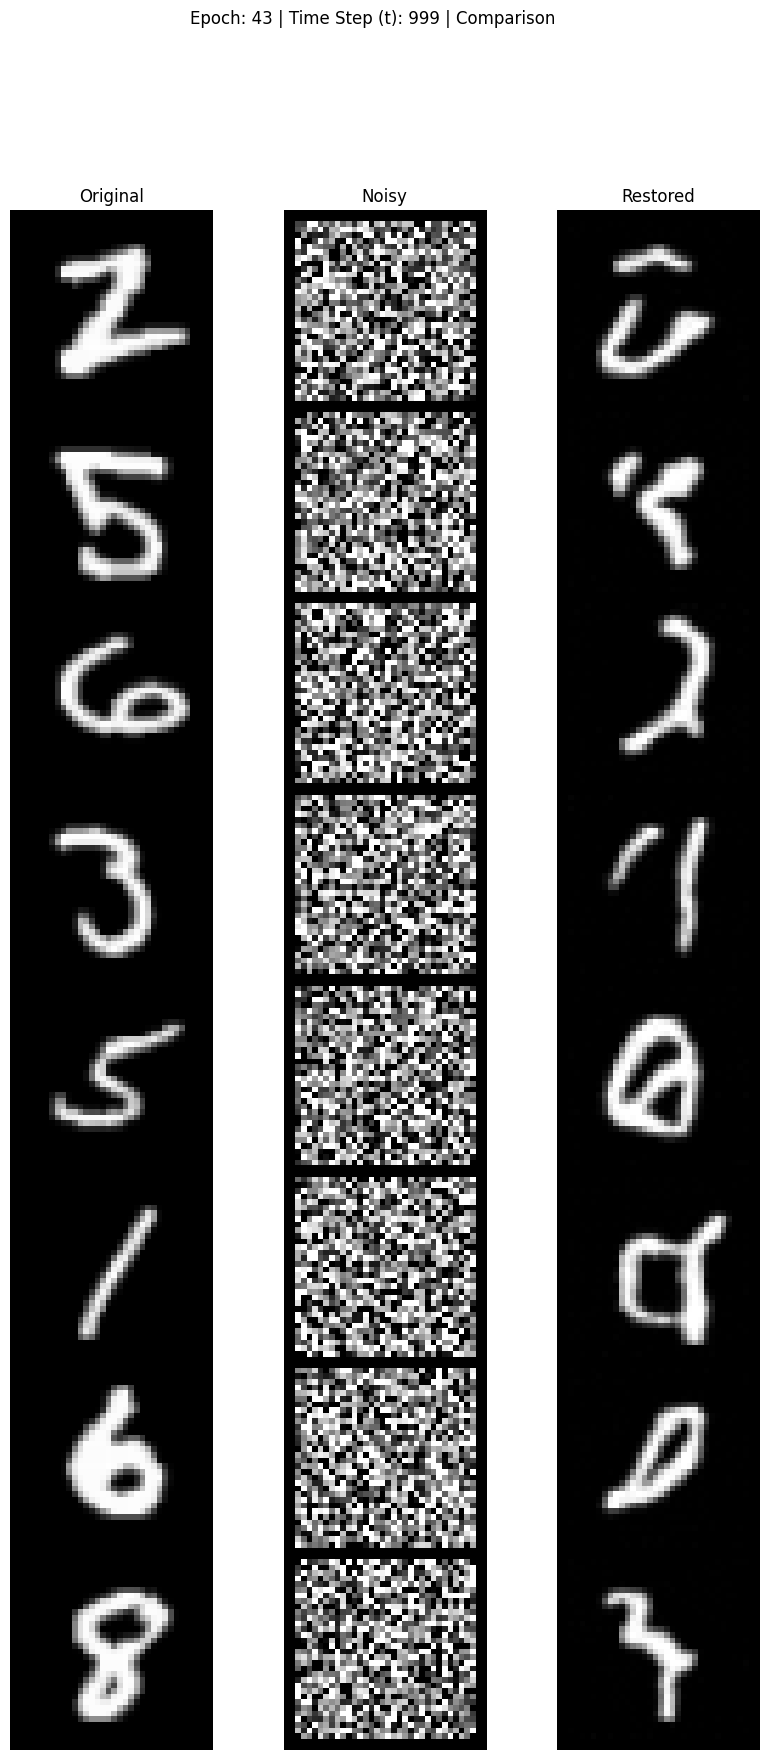

epoch:  44/50 	 iter :  50/469 	 loss: 0.020923
epoch:  44/50 	 iter : 100/469 	 loss: 0.020658
epoch:  44/50 	 iter : 150/469 	 loss: 0.020815
epoch:  44/50 	 iter : 200/469 	 loss: 0.020714
epoch:  44/50 	 iter : 250/469 	 loss: 0.020731
epoch:  44/50 	 iter : 300/469 	 loss: 0.020649
epoch:  44/50 	 iter : 350/469 	 loss: 0.020692
epoch:  44/50 	 iter : 400/469 	 loss: 0.020697
epoch:  44/50 	 iter : 450/469 	 loss: 0.020651
epoch:  44/50 	 total loss: 0.020691


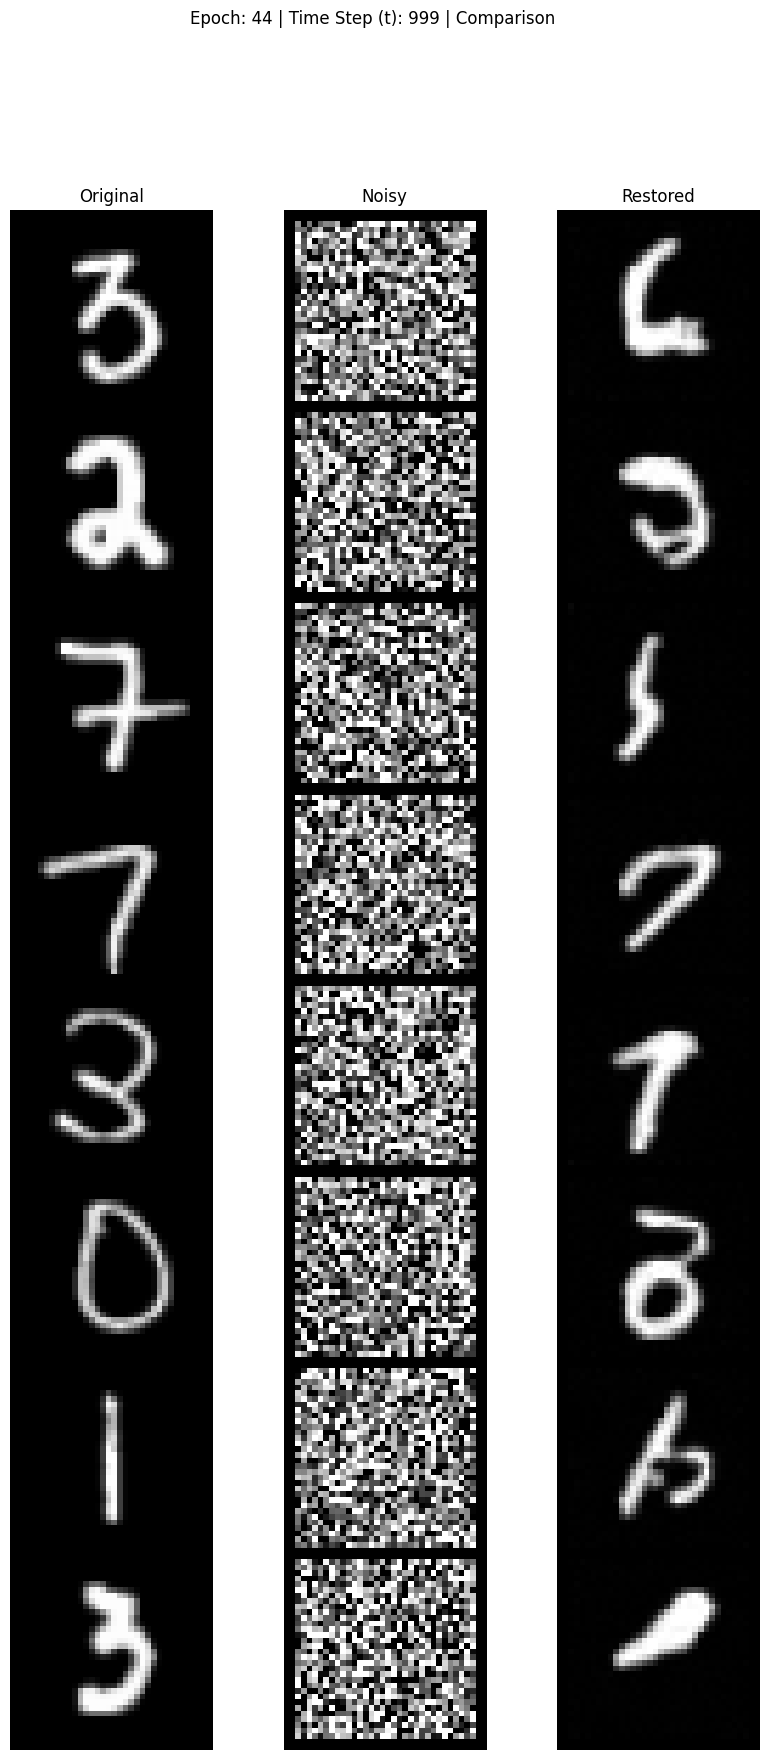

epoch:  45/50 	 iter :  50/469 	 loss: 0.020134
epoch:  45/50 	 iter : 100/469 	 loss: 0.020079
epoch:  45/50 	 iter : 150/469 	 loss: 0.019911
epoch:  45/50 	 iter : 200/469 	 loss: 0.019969
epoch:  45/50 	 iter : 250/469 	 loss: 0.020167
epoch:  45/50 	 iter : 300/469 	 loss: 0.020235
epoch:  45/50 	 iter : 350/469 	 loss: 0.020245
epoch:  45/50 	 iter : 400/469 	 loss: 0.020256
epoch:  45/50 	 iter : 450/469 	 loss: 0.020156
epoch:  45/50 	 total loss: 0.020124


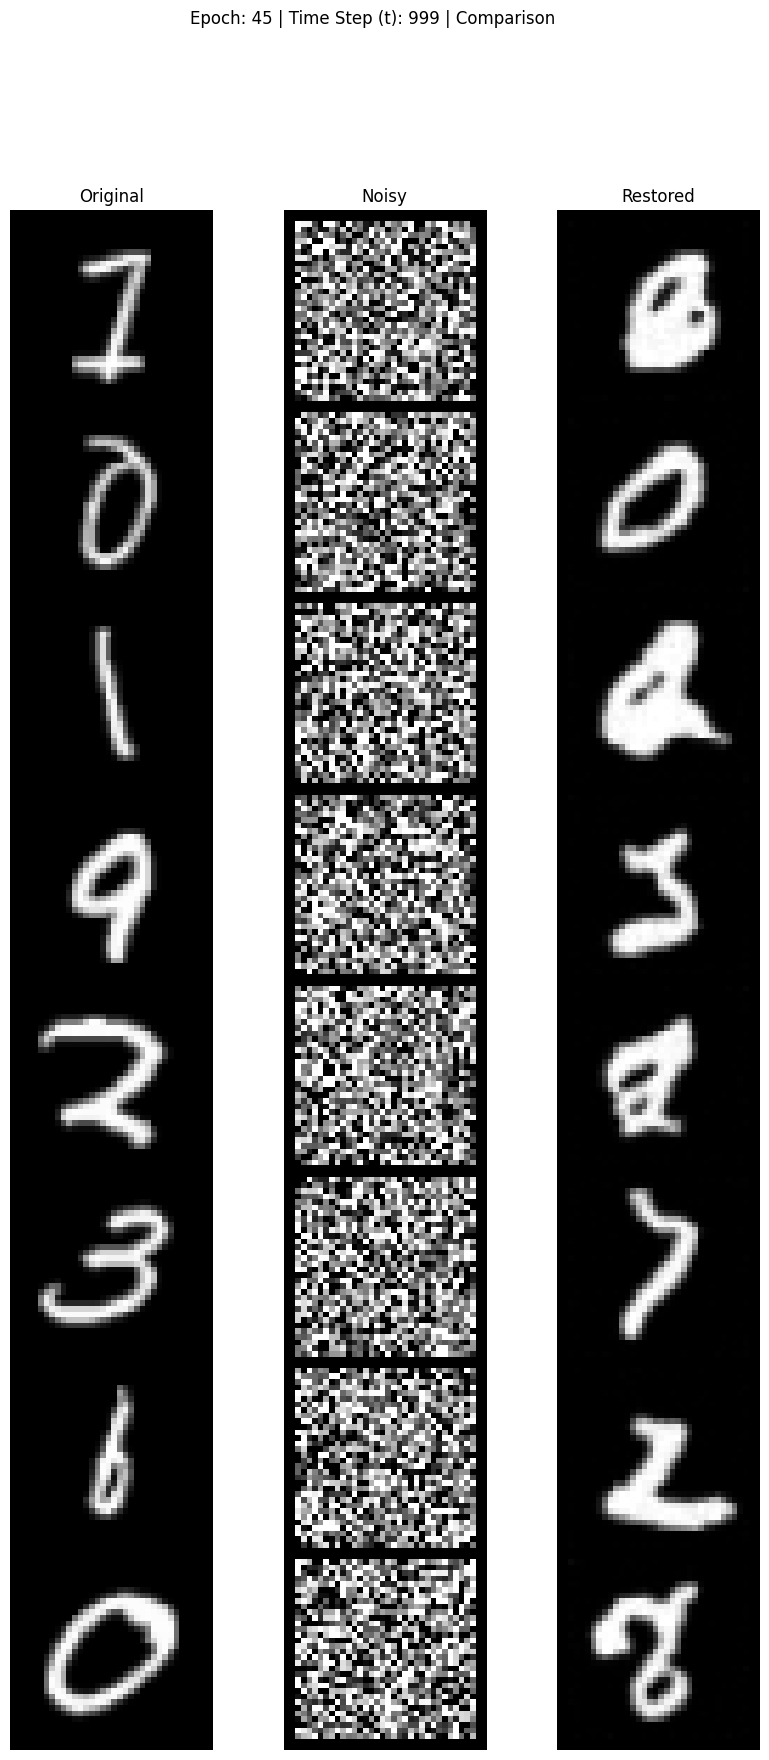

epoch:  46/50 	 iter :  50/469 	 loss: 0.020652
epoch:  46/50 	 iter : 100/469 	 loss: 0.020986
epoch:  46/50 	 iter : 150/469 	 loss: 0.020717
epoch:  46/50 	 iter : 200/469 	 loss: 0.020574
epoch:  46/50 	 iter : 250/469 	 loss: 0.020450
epoch:  46/50 	 iter : 300/469 	 loss: 0.020329
epoch:  46/50 	 iter : 350/469 	 loss: 0.020390
epoch:  46/50 	 iter : 400/469 	 loss: 0.020438
epoch:  46/50 	 iter : 450/469 	 loss: 0.020386
epoch:  46/50 	 total loss: 0.020354


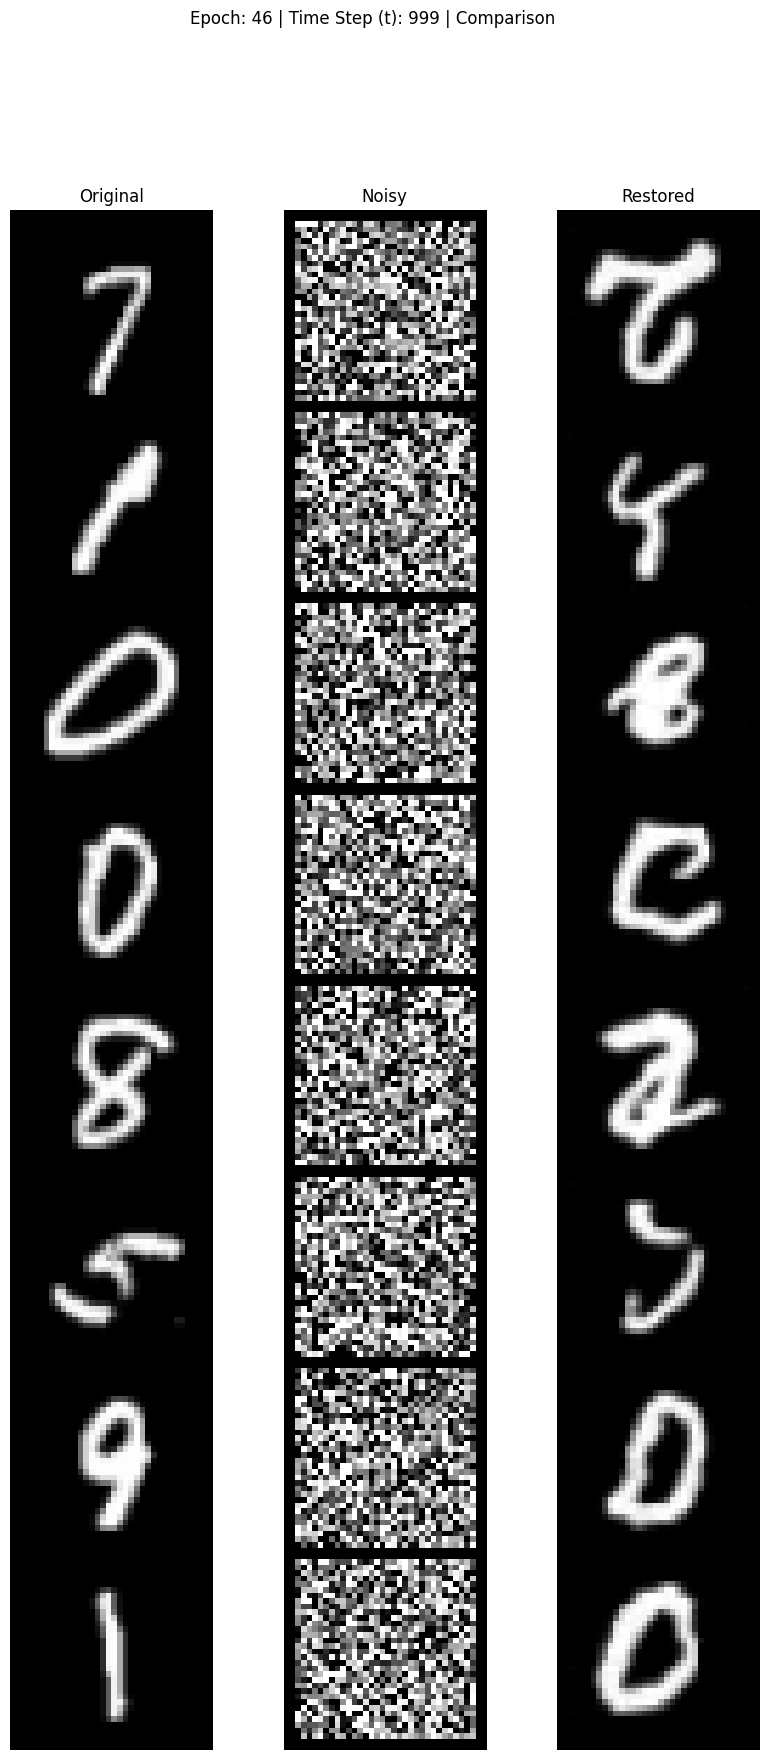

epoch:  47/50 	 iter :  50/469 	 loss: 0.020368
epoch:  47/50 	 iter : 100/469 	 loss: 0.020124
epoch:  47/50 	 iter : 150/469 	 loss: 0.020030
epoch:  47/50 	 iter : 200/469 	 loss: 0.019917
epoch:  47/50 	 iter : 250/469 	 loss: 0.019905
epoch:  47/50 	 iter : 300/469 	 loss: 0.019926
epoch:  47/50 	 iter : 350/469 	 loss: 0.019903
epoch:  47/50 	 iter : 400/469 	 loss: 0.019882
epoch:  47/50 	 iter : 450/469 	 loss: 0.019984
epoch:  47/50 	 total loss: 0.019967


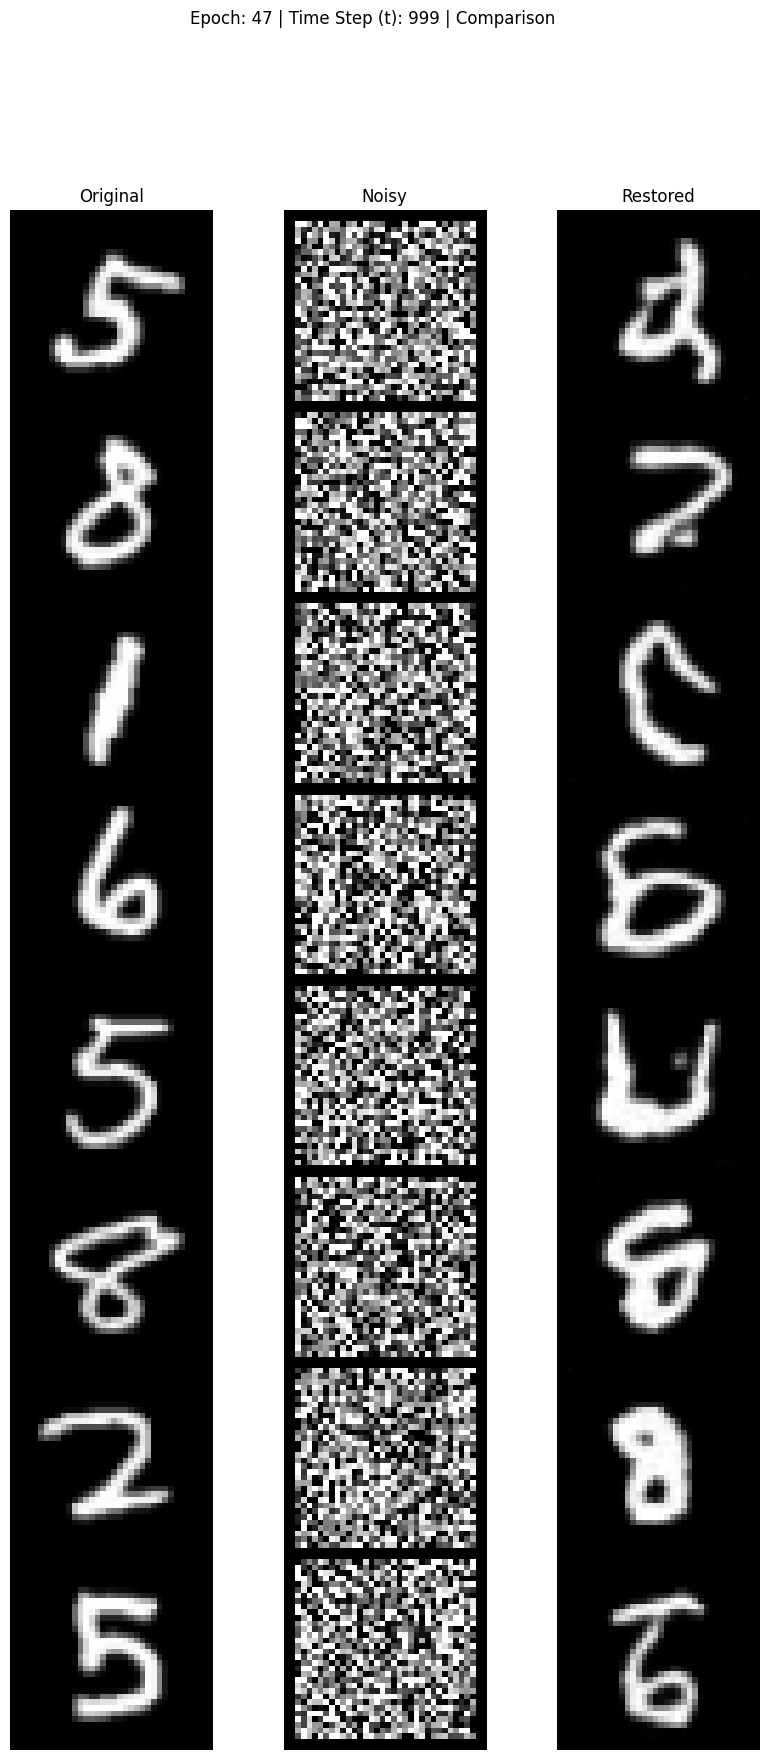

epoch:  48/50 	 iter :  50/469 	 loss: 0.019870
epoch:  48/50 	 iter : 100/469 	 loss: 0.020032
epoch:  48/50 	 iter : 150/469 	 loss: 0.019836
epoch:  48/50 	 iter : 200/469 	 loss: 0.019782
epoch:  48/50 	 iter : 250/469 	 loss: 0.019731
epoch:  48/50 	 iter : 300/469 	 loss: 0.019779
epoch:  48/50 	 iter : 350/469 	 loss: 0.019853
epoch:  48/50 	 iter : 400/469 	 loss: 0.019888
epoch:  48/50 	 iter : 450/469 	 loss: 0.019919
epoch:  48/50 	 total loss: 0.019908


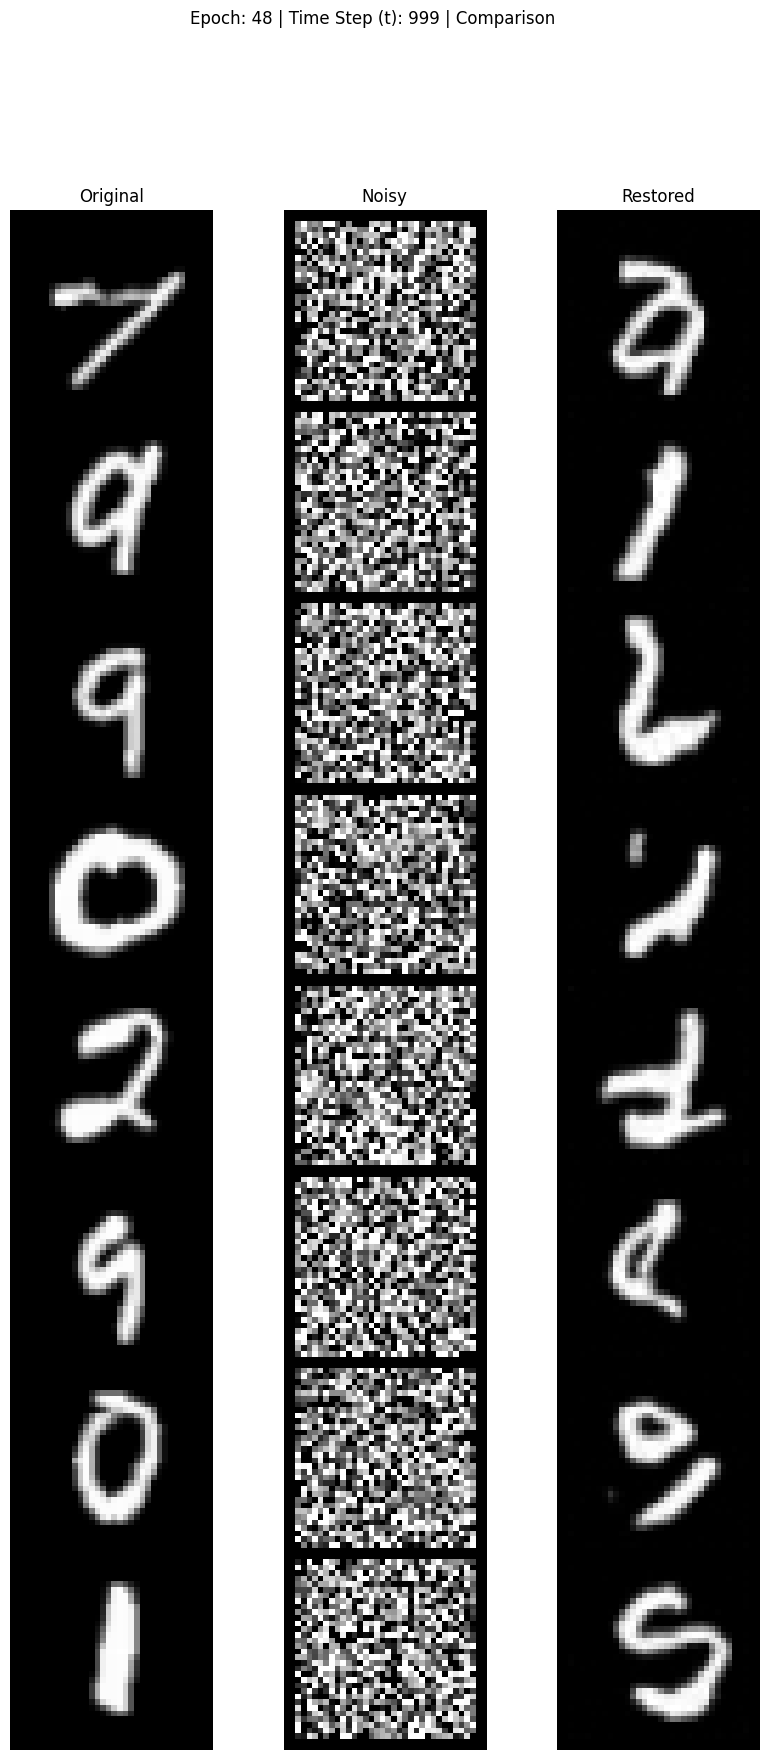

epoch:  49/50 	 iter :  50/469 	 loss: 0.020263
epoch:  49/50 	 iter : 100/469 	 loss: 0.019615
epoch:  49/50 	 iter : 150/469 	 loss: 0.019776
epoch:  49/50 	 iter : 200/469 	 loss: 0.019931
epoch:  49/50 	 iter : 250/469 	 loss: 0.020077
epoch:  49/50 	 iter : 300/469 	 loss: 0.020095
epoch:  49/50 	 iter : 350/469 	 loss: 0.020030
epoch:  49/50 	 iter : 400/469 	 loss: 0.019977
epoch:  49/50 	 iter : 450/469 	 loss: 0.019998
epoch:  49/50 	 total loss: 0.019975


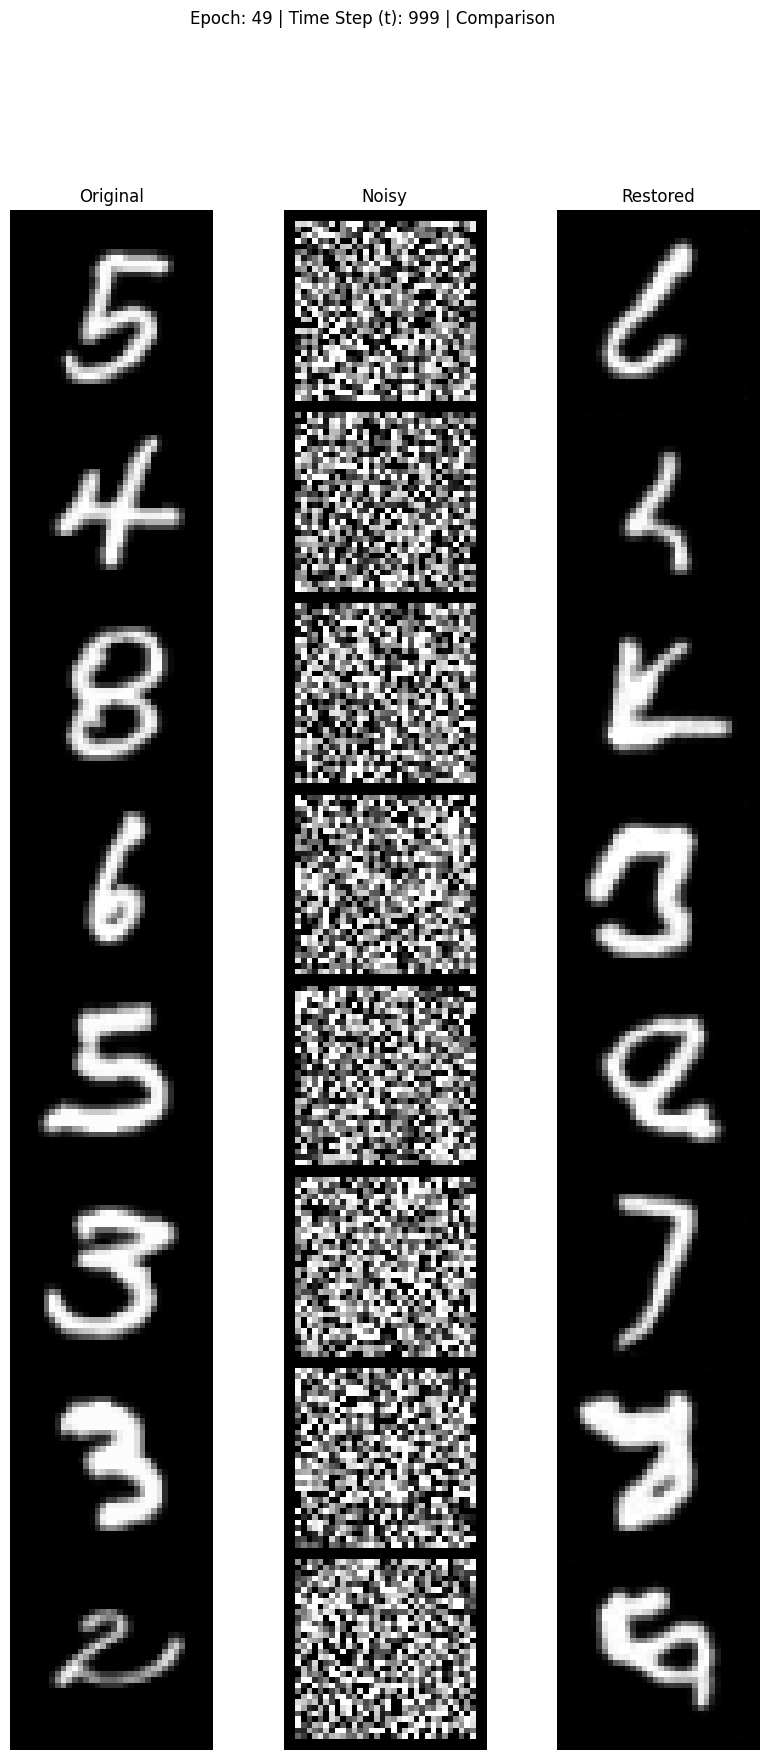

epoch:  50/50 	 iter :  50/469 	 loss: 0.020141
epoch:  50/50 	 iter : 100/469 	 loss: 0.020188
epoch:  50/50 	 iter : 150/469 	 loss: 0.020187
epoch:  50/50 	 iter : 200/469 	 loss: 0.020142
epoch:  50/50 	 iter : 250/469 	 loss: 0.020385
epoch:  50/50 	 iter : 300/469 	 loss: 0.020358
epoch:  50/50 	 iter : 350/469 	 loss: 0.020344
epoch:  50/50 	 iter : 400/469 	 loss: 0.020254
epoch:  50/50 	 iter : 450/469 	 loss: 0.020163
epoch:  50/50 	 total loss: 0.020176


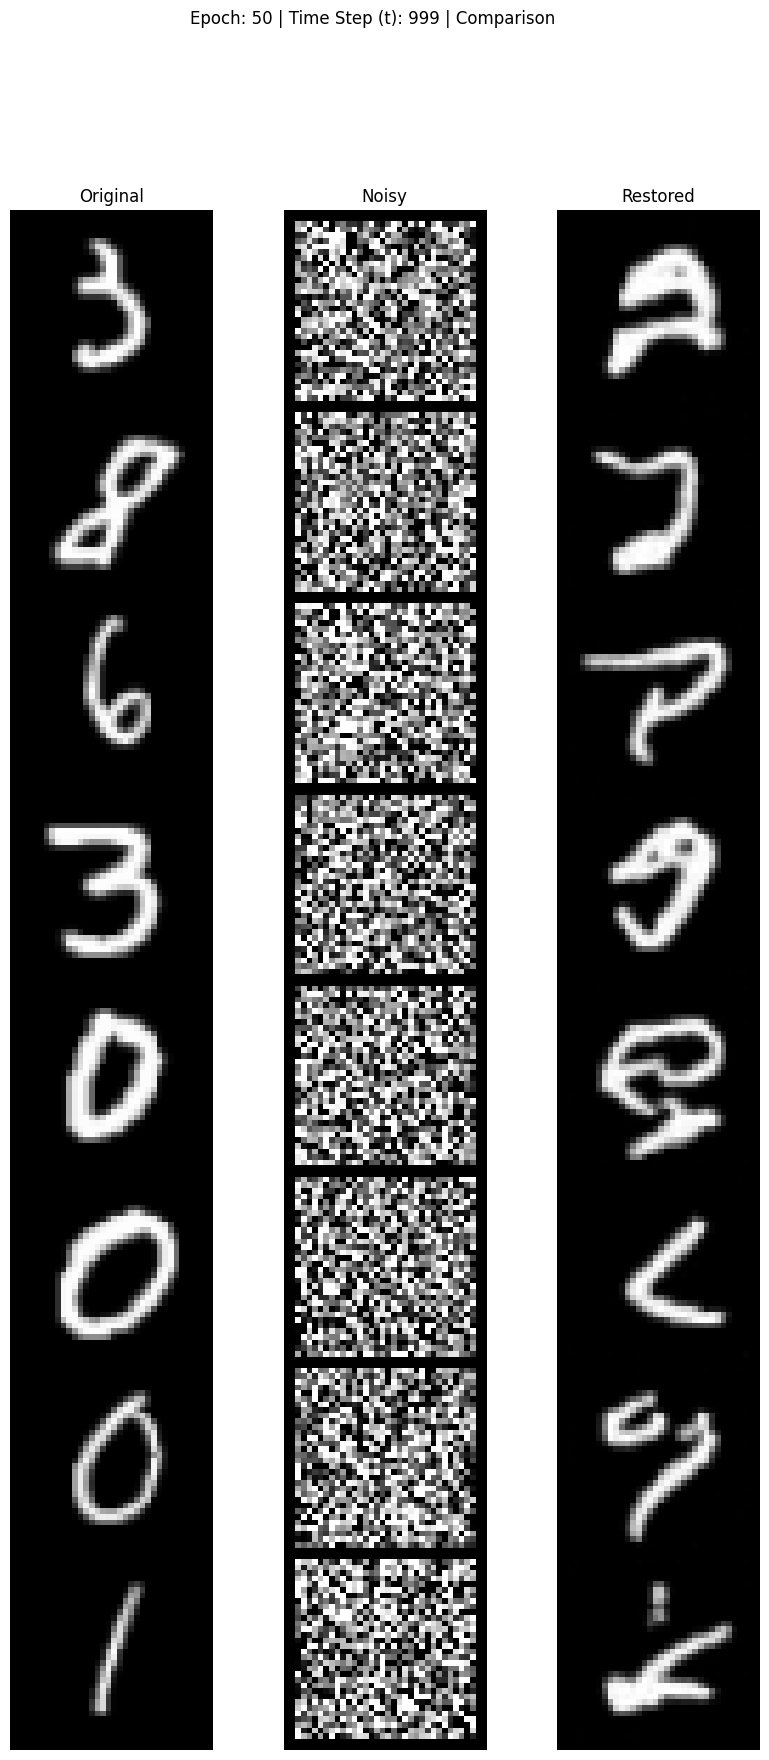

learning time (50 epoch) : 7m 32


In [16]:
epochs = 50

sample_batch_size = 8

total_time = list()
loss_list = list()

for epoch in range(1, epochs + 1):
    now = time()
    avg_loss = 0.0


    sample_x_start, _ = next(iter(trainset)) 
    sample_x_start = sample_x_start[:sample_batch_size].to(device)

    sample_t = torch.tensor([timestep - 1] * sample_batch_size, device=device).long() 

    model.train()
    for i, data in enumerate(trainset):
        x_start, _ = data
        x_start = x_start.to(device)
        batch_size = x_start.size(0)

        t = torch.randint(0, timestep, (batch_size,), device=device).long()
        
        noise = torch.randn_like(x_start)
        
        x_t = q_sample(x_start, t, noise)

        predicted_noise = model(x_t, t)

        loss = criterion(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        loss_list.append(loss.item())
        
        if (i + 1) % 50 == 0:
            current_loss = avg_loss / (i + 1)
            print(f"epoch: {epoch:3d}/{epochs} \t iter : {i+1:3d}/{len(trainset)} \t loss: {current_loss:4.6f}")

    learning_time = int(time() - now)
    total_time.append(learning_time)

    print(f"epoch: {epoch:3d}/{epochs} \t total loss: {avg_loss/len(trainset):4.6f} \t {learning_time}")

    model.eval()
    with torch.no_grad():
        sample_x_t = q_sample(sample_x_start, sample_t)
        restored_x = p_sample_loop(model, sample_x_start.shape)
        plot_images(sample_x_start, sample_x_t, restored_x, timestep - 1, epoch)
    model.train()

print(f"learning time ({epochs} epoch) : {floor(sum(total_time) / 60)}m {sum(total_time) % 60}")